# Import Necessary Libraries and Data

In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pprint import pprint
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from scipy.stats import randint as sp_randint

from sklearn.metrics import mean_squared_error, r2_score
import mlflow
from mlflow.data.pandas_dataset import PandasDataset
import hyperopt

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
dataset = pd.read_csv("data/cal_swat_climate_dataset.csv")
dataset.rename(columns={"Calibrated_SWAT_Snowmelt": "sim_snowmelt"}, inplace=True)
dataset['Date'] = pd.to_datetime(dataset['Date'])


# Exploratory Data Analysis

               DOY  Precipitation  Evapotranspiration         MaxT  \
count  6478.000000    6478.000000         6478.000000  6478.000000   
mean    181.119790       3.289554            1.782721    13.077131   
min       1.000000       0.000000            0.012400   -19.305385   
25%      90.250000       0.000000            0.629250     3.821538   
50%     180.000000       0.344615            1.550000    14.194615   
75%     270.000000       3.092308            2.720000    22.618846   
max     366.000000     113.849231            6.070000    33.268462   
std     104.876329       7.113935            1.274348    10.728194   

              MinT                           Date  Calibrated_SWAT_Streamflow  \
count  6478.000000                           6478                 6478.000000   
mean      0.976026  2001-11-15 05:54:33.232479232                   18.022557   
min     -28.971538            1993-01-01 00:00:00                    0.009484   
25%      -5.860000            1997-06-09 06:0

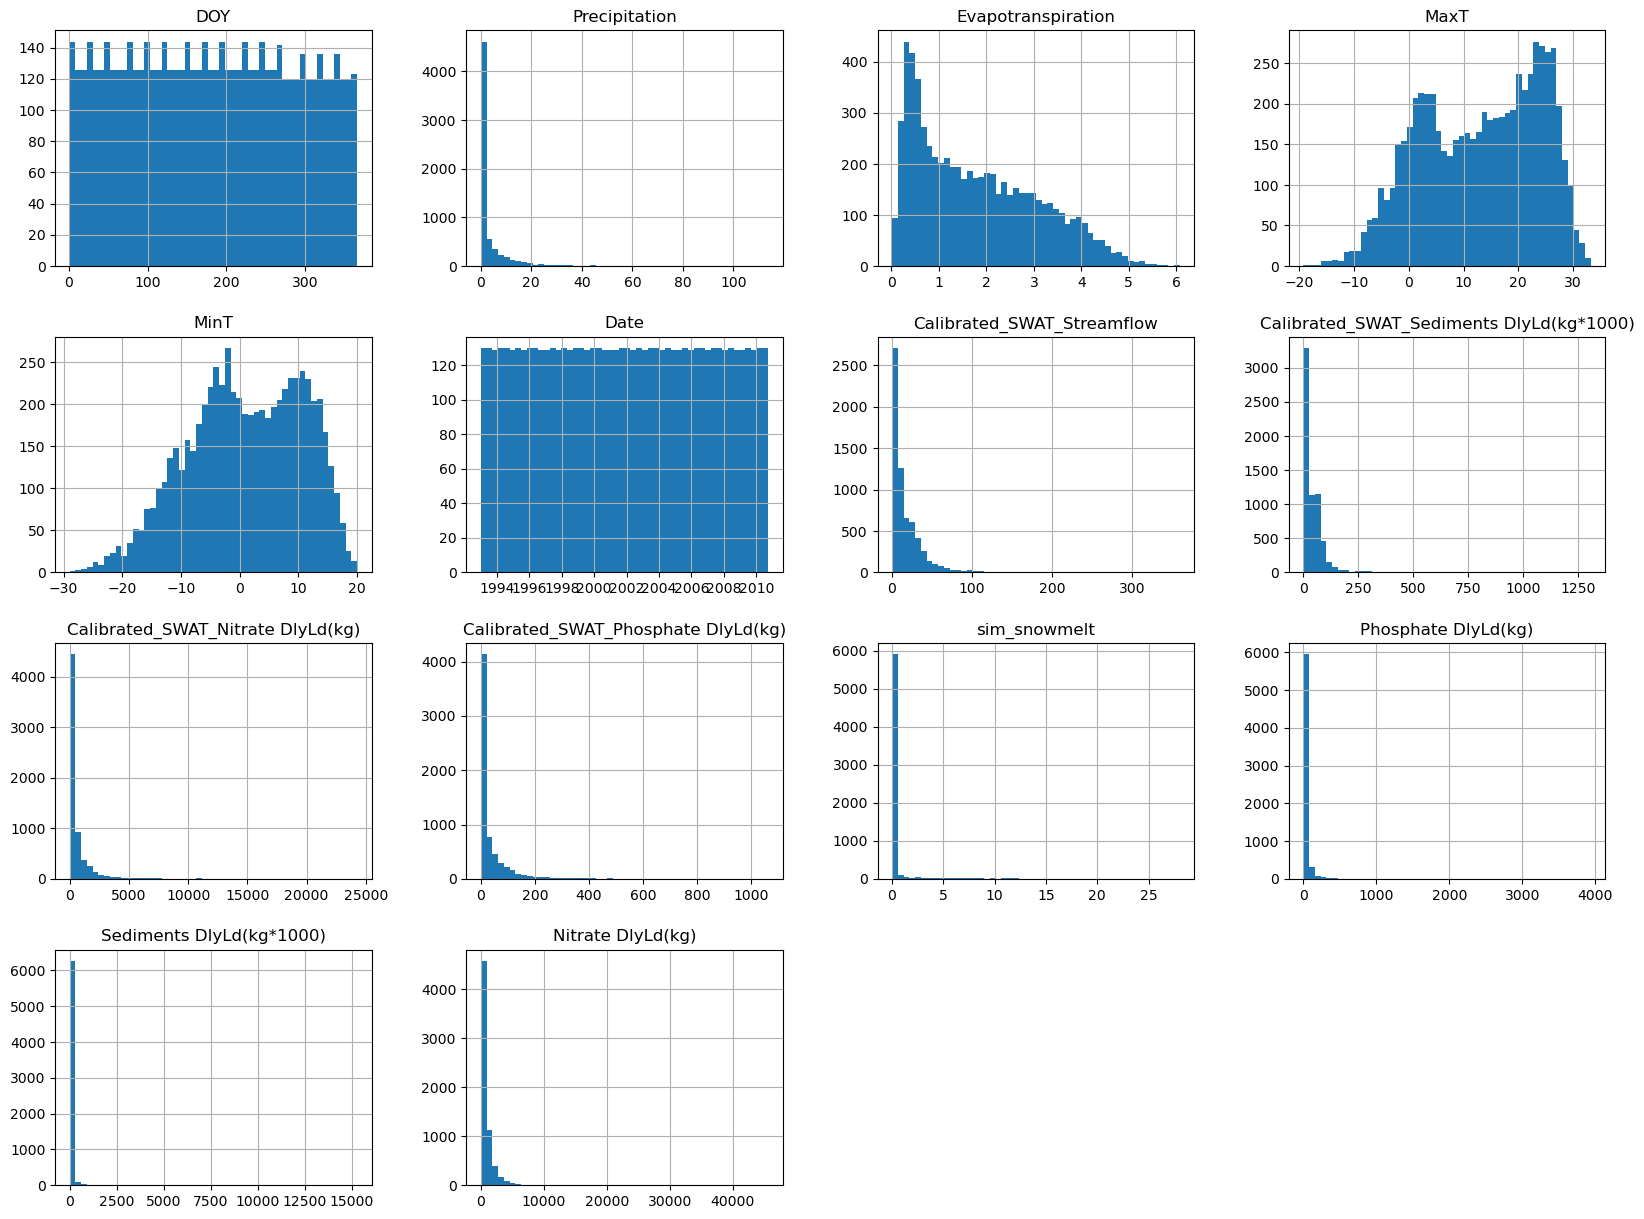

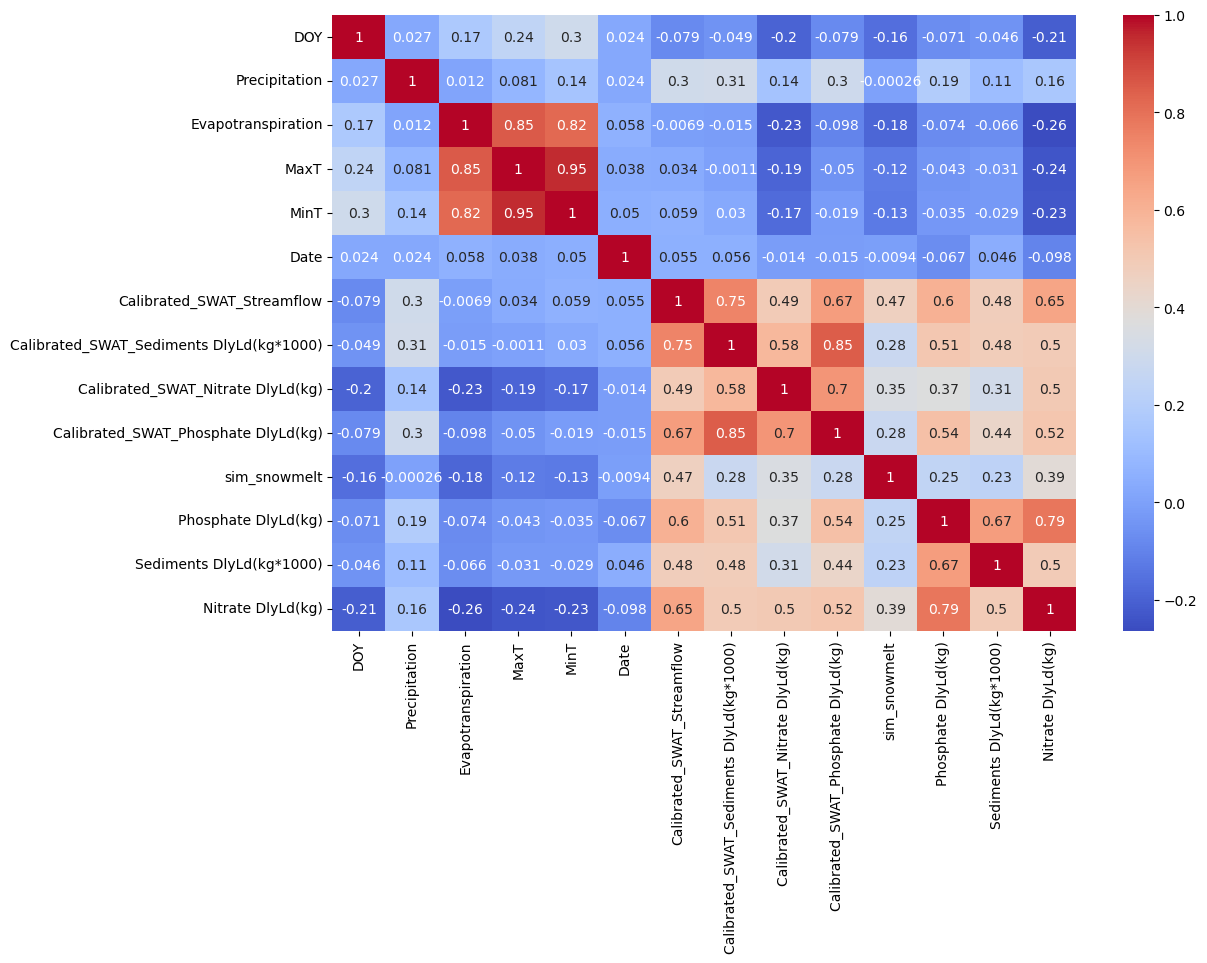

In [3]:
# Display basic statistics
print(dataset.describe())

# Check for missing values
print(dataset.isnull().sum())

# Visualize the distribution of each feature
dataset.hist(bins=50, figsize=(20, 15))
plt.show()

# Visualize correlations using a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(dataset.corr(), annot=True, cmap='coolwarm')
plt.show()

# Feature Engineering

In [4]:
dataset['Date'] = pd.to_datetime(dataset['Date'])
# dataset['year'] = dataset['Date'].dt.year
dataset['month'] = dataset['Date'].dt.month

# Create cyclic features for DOY (day of the year)
dataset['DOY_cos'] = np.cos(2 * np.pi * dataset['DOY'] / 365)
dataset['DOY_sin'] = np.sin(2 * np.pi * dataset['DOY'] / 365)

# Create cyclic features for month
dataset['month_cos'] = np.cos(2 * np.pi * dataset['month'] / 12)
dataset['month_sin'] = np.sin(2 * np.pi * dataset['month'] / 12)

# Calculate temperature range (diurnal temperature range)
dataset['Temp_range'] = dataset['MaxT'] - dataset['MinT']
dataset.drop(['DOY'], axis=1, inplace=True)
dataset.drop(['month'], axis=1, inplace=True)
# Display the updated datasetframe with new features
dataset.head()

,Precipitation,Evapotranspiration,MaxT,MinT,Date,Calibrated_SWAT_Streamflow,Calibrated_SWAT_Sediments DlyLd(kg*1000),Calibrated_SWAT_Nitrate DlyLd(kg),Calibrated_SWAT_Phosphate DlyLd(kg),sim_snowmelt,Phosphate DlyLd(kg),Sediments DlyLd(kg*1000),Nitrate DlyLd(kg),DOY_cos,DOY_sin,month_cos,month_sin,Temp_range
0,0.330769,0.517,2.445385,-10.748462,1993-01-01,36.11,72.04,874.9,49.89,0.029398,246.6620,160.755731,4579.0516,0.999852,0.017213,0.866025,0.5,13.193846
1,0.101538,0.402,-3.736154,-10.940769,1993-01-02,36.20,44.42,232.2,17.26,0.000000,147.9760,40.571564,3446.0388,0.999407,0.034422,0.866025,0.5,7.204615
2,1.456923,0.782,1.354615,-10.342308,1993-01-03,33.75,26.61,1133.0,39.99,0.000000,86.3370,22.013847,2764.1832,0.998667,0.051620,0.866025,0.5,11.696923
3,5.001538,0.378,8.511538,-1.980769,1993-01-04,34.43,32.78,1213.0,72.12,3.790000,79.8604,36.838848,2182.0100,0.997630,0.068802,0.866025,0.5,10.492308
4,12.960000,0.412,10.614615,-5.325385,1993-01-05,46.33,43.52,1135.0,116.70,1.194448,212.7420,218.350895,3680.8606,0.996298,0.085965,0.866025,0.5,15.940000


In [19]:
def create_lagged_features(dataset, lag_days):
    new_dataset = dataset.copy()
    for lag in lag_days:
        new_dataset[f'Precipitation_lag{lag}'] = new_dataset['Precipitation'].shift(lag)
        new_dataset[f'Evapotranspiration_lag{lag}'] = new_dataset['Evapotranspiration'].shift(lag)
        new_dataset[f"snowmelt_lag{lag}"] = new_dataset[
            "sim_snowmelt"
        ].shift(lag)
        new_dataset[f'MinT_lag{lag}'] = new_dataset['MinT'].shift(lag)
        new_dataset[f'MaxT_lag{lag}'] = new_dataset['MaxT'].shift(lag)
    # new_dataset.fillna(method='bfill', inplace=True)
    # shift rows up by lag_days to remove NaN values
    new_dataset = new_dataset[lag_days[-1]:]
    return new_dataset

In [28]:
def create_cumulative_features(dataset, cumulation_days):
    new_dataset = dataset.copy()
    for cumulation in cumulation_days:
        new_dataset[f'Precipitation_cum{cumulation}'] = new_dataset['Precipitation'].rolling(cumulation).sum()
        new_dataset[f'Evapotranspiration_cum{cumulation}'] = new_dataset['Evapotranspiration'].rolling(cumulation).sum()
        new_dataset[f"snowmelt_cum{cumulation}"] = (
            new_dataset["sim_snowmelt"].rolling(cumulation).sum()
        )
        # new_dataset[f'streamflow_cum{cumulation}'] = new_dataset['sim_streamflow'].rolling(cumulation).sum()
        
    # new_dataset.fillna(method='bfill', inplace=True)
    new_dataset = new_dataset[cumulation_days[-1] :]
    return new_dataset

In [36]:
import pandas as pd


def create_lagged_and_cumulative_features(dataset, lag_days, cumulation_days):
    """
    Creates lagged and cumulative features for specified columns in a Pandas DataFrame.

    Args:
        dataset (pd.DataFrame): The input DataFrame.
        lag_days (list): List of integers representing the lag days.
        cumulation_days (list): List of integers representing the cumulation days.

    Returns:
        pd.DataFrame: The DataFrame with added lagged and cumulative features.
    """

    new_dataset = dataset.copy()

    # Create lagged features
    for lag in lag_days:
        new_dataset[f"Precipitation_lag{lag}"] = new_dataset["Precipitation"].shift(lag)
        new_dataset[f"Evapotranspiration_lag{lag}"] = new_dataset[
            "Evapotranspiration"
        ].shift(lag)
        new_dataset[f"snowmelt_lag{lag}"] = new_dataset["sim_snowmelt"].shift(lag)
        new_dataset[f"MinT_lag{lag}"] = new_dataset["MinT"].shift(lag)
        new_dataset[f"MaxT_lag{lag}"] = new_dataset["MaxT"].shift(lag)

    # Create cumulative features
    for cumulation in cumulation_days:
        new_dataset[f"Precipitation_cum{cumulation}"] = (
            new_dataset["Precipitation"].rolling(cumulation).sum()
        )
        new_dataset[f"Evapotranspiration_cum{cumulation}"] = (
            new_dataset["Evapotranspiration"].rolling(cumulation).sum()
        )
        new_dataset[f"snowmelt_cum{cumulation}"] = (
            new_dataset["sim_snowmelt"].rolling(cumulation).sum()
        )

    # Calculate the maximum lag and cumulation to determine the starting row for slicing.
    max_lag = max(lag_days) if lag_days else 0
    max_cumulation = max(cumulation_days) if cumulation_days else 0
    start_row = max(max_lag, max_cumulation)

    # Slice the DataFrame to remove NaN values from lagging and cumulative features.
    new_dataset = new_dataset[start_row:]

    return new_dataset


# Helper Functions

In [ ]:
def nse_score(observed, simulated):
    """
    Calculate the Nash-Sutcliffe Efficiency (NSE) between observed and simulated data.

    Parameters:
    observed (array-like): Array of observed values.
    simulated (array-like): Array of simulated/predicted values.

    Returns:
    float: NSE value.
    """
    observed = np.asarray(observed)
    simulated = np.asarray(simulated)

    if observed.shape != simulated.shape:
        raise ValueError("Observed and simulated arrays must have the same shape.")

    numerator = np.sum((simulated - observed) ** 2)
    denominator = np.var(observed, ddof=1) * len(observed)

    nse = 1 - numerator / denominator
    return nse


def pbias_score(observed, predicted):
    """
    Calculate the percentage difference between sum of observed and sum of predicted values.

    Parameters:
    observed (numpy.ndarray): Array of observed values
    predicted (numpy.ndarray): Array of predicted values

    Returns:
    float: Percentage difference: (sum(observed) - sum(predicted)) * 100 / sum(observed)
    """
    sum_observed = np.sum(observed)
    sum_predicted = np.sum(predicted)

    if sum_observed == 0:
        raise ValueError("Sum of observed values cannot be zero (division by zero)")

    percentage_diff = (sum_observed - sum_predicted) * 100 / sum_observed

    return percentage_diff


In [22]:
def select_features(X,y, target_column, importance_threshold=0.01):
    

    # Fit a preliminary model to get feature importances
    model = XGBRegressor(
        objective="reg:squarederror",
        n_estimators=50,
        learning_rate=0.1,
        max_depth=4,
        random_state=42,
    )
    model.fit(X, y)

    # Extract feature importances
    feature_importances = pd.Series(model.feature_importances_, index=X.columns)

    # Filter features based on importance threshold
    important_features = feature_importances[
        feature_importances > importance_threshold
    ].index
    print(f"Selected features for {target_column}:\n", important_features)

    # Return data with selected features only
    return X[important_features]

In [23]:
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
import numpy as np
from sklearn.metrics import mean_absolute_error


def hyperopt_xgb_tuning(X_train, y_train):
    def objective(params):
        model = XGBRegressor(
            objective="reg:squarederror",
            n_estimators=int(params["n_estimators"]),
            max_depth=int(params["max_depth"]),
            learning_rate=params["learning_rate"],
            subsample=params["subsample"],
            colsample_bytree=params["colsample_bytree"],
            reg_alpha=params["reg_alpha"],
            reg_lambda=params["reg_lambda"],
            random_state=42,
        )
        model.fit(X_train, y_train)

        # Predictions and evaluation on training set (to speed up tuning)
        y_pred = model.predict(X_train)
        mse = mean_squared_error(y_train, y_pred)
        mae = mean_absolute_error(y_train, y_pred)

        return {"loss": mse, "status": STATUS_OK}

    # Define the parameter search space
    space = {
        "max_depth": hp.quniform("max_depth", 3, 18, 1),
        "gamma": hp.uniform("gamma", 1, 9),
        "reg_alpha": hp.quniform("reg_alpha", 40, 180, 1),
        "reg_lambda": hp.uniform("reg_lambda", 0, 1),
        "learning_rate": hp.loguniform("learning_rate", np.log(0.01), np.log(0.3)),
        "subsample": hp.uniform("subsample", 0.6, 1.0),
        "colsample_bytree": hp.uniform("colsample_bytree", 0.5, 1),
        "min_child_weight": hp.quniform("min_child_weight", 0, 10, 1),
        "n_estimators": hp.quniform(
            "n_estimators",
            100,
            300,
            10,
        ),
    }


    # Run HyperOpt optimization
    trials = Trials()
    best = fmin(
        fn=objective,
        space=space,
        algo=tpe.suggest,
        max_evals=50,
        trials=trials,
        rstate=np.random.default_rng(42),
    )

    # Return the best parameters found
    return {
        "n_estimators": int(best["n_estimators"]),
        "max_depth": int(best["max_depth"]),
        "learning_rate": best["learning_rate"],
        "subsample": best["subsample"],
        "colsample_bytree": best["colsample_bytree"],
        "reg_alpha": best["reg_alpha"],
        "reg_lambda": best["reg_lambda"],
    }


# Model Training

In [72]:
dataset_lagged = create_lagged_features(dataset, lag_days=[1, 3, 7])
dataset_lagged = create_cumulative_features(dataset_lagged, cumulation_days=[3, 7])

In [250]:
dataset_lagged = create_lagged_and_cumulative_features(
    dataset,
    lag_days=[1, 3, 7],
    cumulation_days=[3, 7],
)

In [341]:
datasets["Nitrate DlyLd(kg)"] = dataset_lagged.drop(
    ["Phosphate DlyLd(kg)", "Sediments DlyLd(kg*1000)"],
    axis=1,
)
datasets["Phosphate DlyLd(kg)"] = dataset_lagged.drop(
    ["Nitrate DlyLd(kg)", "Sediments DlyLd(kg*1000)"], axis=1
)
datasets["Sediments DlyLd(kg*1000)"] = dataset_lagged.drop(
    ["Nitrate DlyLd(kg)", "Phosphate DlyLd(kg)"], axis=1
)
for target in targets:
    datasets[target].dropna(inplace=True)

In [342]:
datasets

{'Nitrate DlyLd(kg)':       Precipitation  Evapotranspiration       MaxT       MinT       Date  \
 7          0.000000               0.234   0.605385  -7.560769 1993-01-08   
 8          0.000000               0.234  -4.139231 -11.376154 1993-01-09   
 9          2.070769               0.335  -6.650000 -12.720769 1993-01-10   
 10         2.687692               0.209  -1.008462 -10.730000 1993-01-11   
 11         3.352308               0.128   1.134615  -5.536154 1993-01-12   
 ...             ...                 ...        ...        ...        ...   
 6473       1.153846               1.560  25.570000   9.843846 2010-09-26   
 6474       0.000000               1.120  23.216154  10.510000 2010-09-27   
 6475       0.000000               1.980  30.226923  16.171538 2010-09-28   
 6476       0.000000               1.030  23.670000   7.502308 2010-09-29   
 6477       0.176923               0.786  18.566923   7.568462 2010-09-30   
 
       Calibrated_SWAT_Streamflow  Calibrated_SWAT_Se

In [80]:
features = {
    "Sediments DlyLd(kg*1000)": [
        "Calibrated_SWAT_Streamflow",
        "Calibrated_SWAT_Nitrate DlyLd(kg)",
        "Calibrated_SWAT_Phosphate DlyLd(kg)",
    ],
    "Nitrate DlyLd(kg)": [
        "Calibrated_SWAT_Streamflow",
        "Calibrated_SWAT_Sediments DlyLd(kg*1000)",
        "Calibrated_SWAT_Phosphate DlyLd(kg)",
    ],
    "Phosphate DlyLd(kg)": [
        "Calibrated_SWAT_Streamflow",
        "Calibrated_SWAT_Sediments DlyLd(kg*1000)",
        "Calibrated_SWAT_Nitrate DlyLd(kg)",
    ],
}

## XGBoost

In [278]:
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_absolute_error

# Define the target variables
targets = ["Phosphate DlyLd(kg)", "Nitrate DlyLd(kg)", "Sediments DlyLd(kg*1000)"]#, "TotalP"]

# Define the XGBoost Regressor model
rf_model = XGBRegressor(
    objective="reg:squarederror",
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
)




# Run experiments for each target variable
results = {target: {} for target in targets}
model_val_preds = {}
y_vals = {}
model_inputs = {}
model_test_preds = {}
y_tests = {}
x_tests = {}

for target in targets:
    # mlflow.set_experiment("Daily Timestep")
    # with mlflow.start_run(run_name=f"{target.split()[0]}_xgb_rem_oh_shuff"):
        

    X = datasets[target].drop(columns=["Date"] + [target], axis=1)
    y = datasets[target][["Date", target]]

    X = X.drop(
        columns=[
            col
            for col in X.columns
            if col.startswith("Calibrated_SWAT") and col not in features[target]
        ]
    )

    # Split the data into train (70%), validation (15%), and test (15%) sets
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.3, random_state=42, shuffle=False
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42, shuffle=False
    )

    y_vals[target] = y_val
    y_tests[target] = y_test

    # X = select_features(X_train, y_train[target], target)

    # print size of each dataset
    print(
        f"Size of training dataset for target variable {target}: {X_train.shape[0]}"
    )
    print(
        f"Size of validation dataset for target variable {target}: {X_val.shape[0]}"
    )
    print(f"Size of test dataset for target variable {target}: {X_test.shape[0]}")

    # print selected features
    print(f"Selected features for target variable {target}:\n", X.columns)

    X_train = X_train[X.columns]
    X_val = X_val[X.columns]
    X_test = X_test[X.columns]

    # dataset = mlflow.data.from_pandas(
    #     df=X_train,
    #     source="https://drive.google.com/drive/u/0/folders/1v2prt2WKmXuJr2eH66LevBTM7t42Wqp4",
    #     name=f"{target}_imp_features",
    # )
    # mlflow.log_input(dataset, context="training_data")
    feature_names = list(X.columns)
    # mlflow.log_dict(
    #     {f"input_features": feature_names},
    #     f"{target.split()[0]}_xgb_input_features.json",
    # )

    # Standardize the data (train/val/test separately)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    # log the scaler to mlflow
    # mlflow.sklearn.log_model(scaler, f"{target}_scaler")

    x_tests[target] = X_test

    print(f"Hyperparameter tuning for target: {target}")
    best_params = hyperopt_xgb_tuning(X_train, y_train[target])
    print("Best parameters:", best_params)

    # Train the model with the best parameters
    model = XGBRegressor(
        objective="reg:squarederror", random_state=42, **best_params
    )
    model.fit(X_train, y_train[target])

    # mlflow.log_params(best_params)

    # rf_model.fit(X_train, y_train[target])

    # Evaluate the model on the test set
    y_pred_val = model.predict(X_val)
    model_val_preds[target] = y_pred_val

    y_pred_test = model.predict(X_test)
    model_test_preds[target] = y_pred_test

    r2 = r_squared(y_test[target], y_pred_test)
    mad = median_absolute_error(y_test[target], y_pred_test)
    mae = mean_absolute_error(y_test[target], y_pred_test)
    nse = nse_score(y_test[target], y_pred_test)
    pbias = pbias_score(y_test[target], y_pred_test)

    # mlflow.log_metrics({"R2": r2, "NSE": nse, "PBIAS": pbias})

    # Store feature importances for Random Forest
    feature_importances = model.feature_importances_
    results[target] = {
        "R2": r2,
        "MAD": mad,
        "MAE": mae,
        "NSE": nse,
        "PBIAS": pbias,
        "Feature Importances": feature_importances,
        "Model": model,
        "Model Inputs": X.columns,
    }

    # mlflow.sklearn.log_model(model, "xgb_model")
        

    

# Print the final results for all target variables
pprint(results)


Size of training dataset for target variable Phosphate DlyLd(kg): 4526
Size of validation dataset for target variable Phosphate DlyLd(kg): 970
Size of test dataset for target variable Phosphate DlyLd(kg): 970
Selected features for target variable Phosphate DlyLd(kg):
 Index(['Precipitation', 'Evapotranspiration', 'MaxT', 'MinT',
       'Calibrated_SWAT_Streamflow',
       'Calibrated_SWAT_Sediments DlyLd(kg*1000)',
       'Calibrated_SWAT_Nitrate DlyLd(kg)', 'sim_snowmelt', 'DOY_cos',
       'DOY_sin', 'month_cos', 'month_sin', 'Temp_range', 'Precipitation_lag1',
       'Evapotranspiration_lag1', 'snowmelt_lag1', 'MinT_lag1', 'MaxT_lag1',
       'Precipitation_lag3', 'Evapotranspiration_lag3', 'snowmelt_lag3',
       'MinT_lag3', 'MaxT_lag3', 'Precipitation_lag7',
       'Evapotranspiration_lag7', 'snowmelt_lag7', 'MinT_lag7', 'MaxT_lag7',
       'Precipitation_cum3', 'Evapotranspiration_cum3', 'snowmelt_cum3',
       'Precipitation_cum7', 'Evapotranspiration_cum7', 'snowmelt_cum7'],
 

### Daily Timestep Results

In [279]:
# create dataframe for exp3_results only showing the metrics
results_df = pd.DataFrame(results).T.drop(
    columns=["Feature Importances", "Model", "Model Inputs"]
)
results_df


,R2,MAD,MAE,NSE,PBIAS
Phosphate DlyLd(kg),0.237212,9.474846,24.909345,-0.093305,-38.122317
Nitrate DlyLd(kg),0.57404,228.199919,431.536492,0.375962,-42.046912
Sediments DlyLd(kg*1000),0.136426,3.80273,90.114859,0.126211,52.393083


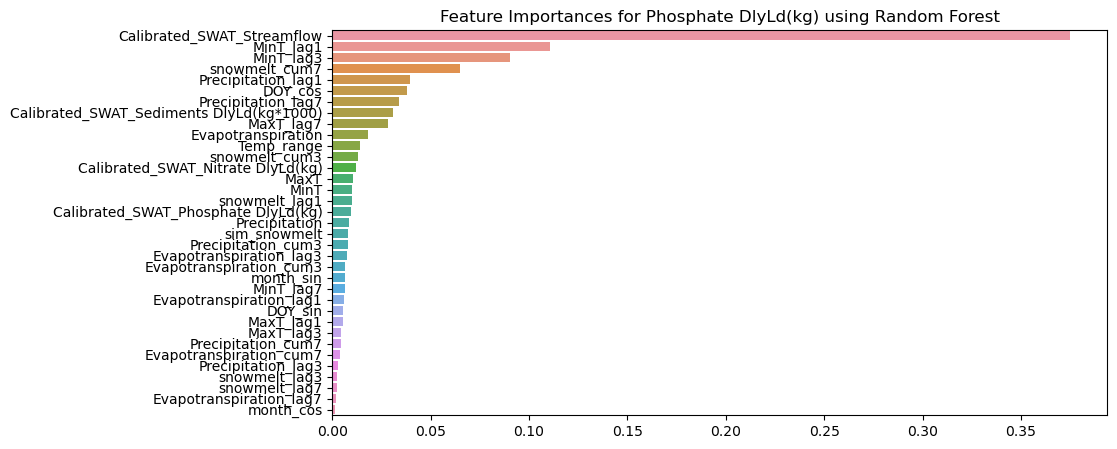

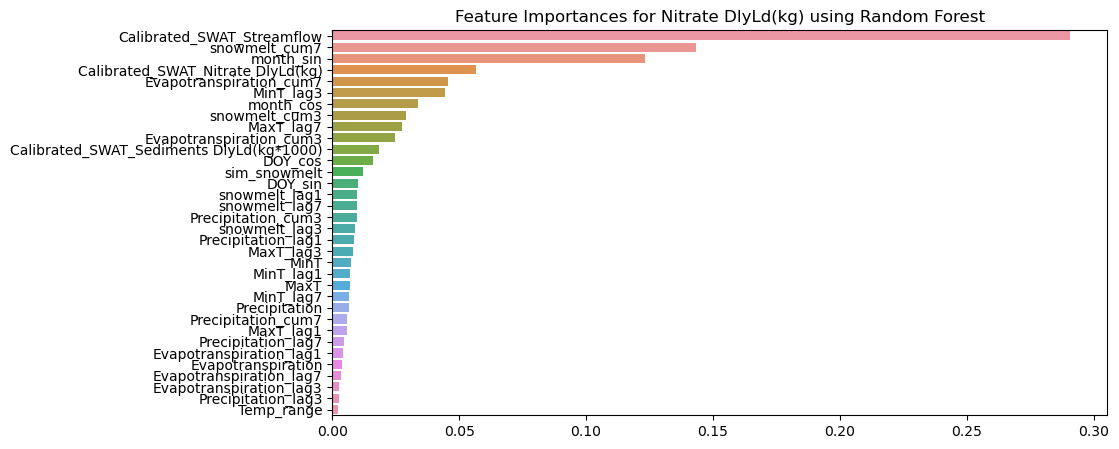

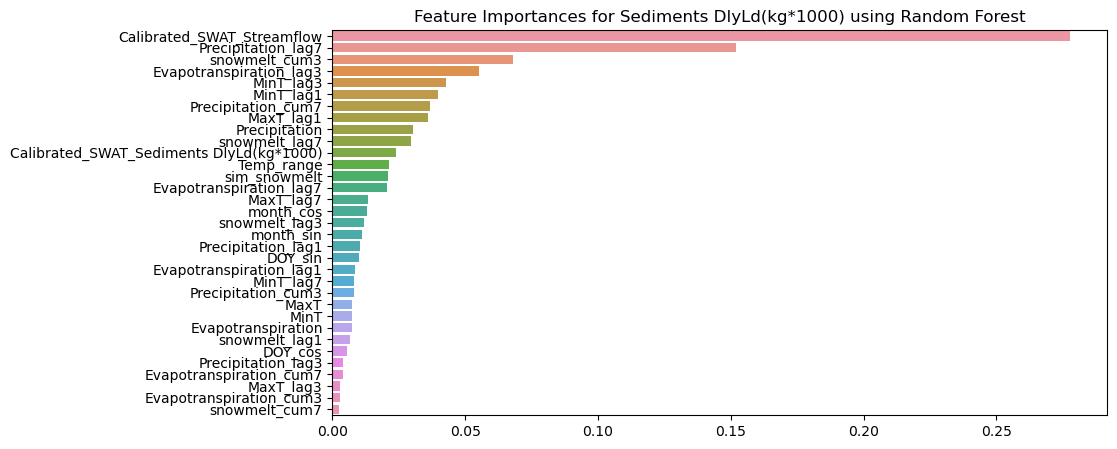

In [79]:
# plot feature importances and arrange them in descending order
for target in targets:
    feature_importances = results[target]["Feature Importances"]
    sorted_indices = np.argsort(feature_importances)[::-1]
    sorted_features = results[target]["Model Inputs"][sorted_indices]
    sorted_importances = feature_importances[sorted_indices]

    plt.figure(figsize=(10, 5))
    sns.barplot(x=sorted_importances, y=sorted_features)
    plt.title(f"Feature Importances for {target} using Random Forest")
    plt.show()


# Aggregated Data

## Monthly Aggregations

In [281]:
monthly_aggregates = {}
for target in targets:
    mlflow.set_experiment("Monthly Timestep")
    with mlflow.start_run(run_name=f"{target.split()[0]}_rf"):
        # Create a dataframe for the monthly aggregates
        monthly_aggregates[target] = pd.DataFrame(
            {
                "Date": y_tests[target]['Date'],
                "Observed": y_tests[target][target],
                "Predicted": model_test_preds[target],
            },
            index=y_tests[target].index,
        )
        monthly_aggregates[target].set_index("Date", inplace=True)
        monthly_aggregates[target] = monthly_aggregates[target].resample("M").mean()

        r2 = r_squared(
            monthly_aggregates[target]["Observed"],
            monthly_aggregates[target]["Predicted"],
        )
        nse = nse_score(
            monthly_aggregates[target]["Observed"], monthly_aggregates[target]["Predicted"]
        )

        pbias = pbias_score(
            monthly_aggregates[target]["Observed"], monthly_aggregates[target]["Predicted"]
        )

        mlflow.log_metrics({"R2": r2, "NSE": nse, "PBIAS": pbias})

        print(f"R2 score for {target} monthly aggregates: {r2}")

        print(f"NSE score for {target} monthly aggregates: {nse}")

        print(f"PBIAS score for {target} monthly aggregates: {pbias}")
        print("------------------------------------------")
        print("\n")

R2 score for Phosphate DlyLd(kg) monthly aggregates: 0.6568619489282165
NSE score for Phosphate DlyLd(kg) monthly aggregates: 0.5242242556688017
PBIAS score for Phosphate DlyLd(kg) monthly aggregates: -37.18169603817114
------------------------------------------


R2 score for Nitrate DlyLd(kg) monthly aggregates: 0.7847229342986927
NSE score for Nitrate DlyLd(kg) monthly aggregates: 0.6003244868622746
PBIAS score for Nitrate DlyLd(kg) monthly aggregates: -40.979981648391785
------------------------------------------


R2 score for Sediments DlyLd(kg*1000) monthly aggregates: 0.7371331640032688
NSE score for Sediments DlyLd(kg*1000) monthly aggregates: 0.3921426490694059
PBIAS score for Sediments DlyLd(kg*1000) monthly aggregates: 53.05763289952364
------------------------------------------




/var/folders/6l/d525srpn1tl8c1jw2pxxkr3m0000gn/T/ipykernel_90288/1603992585.py:15: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



In [282]:
import pandas as pd
from sklearn.metrics import r2_score, mean_absolute_error, median_absolute_error

monthly_aggregate_metrics = {}
monthly_aggregates = {}
monthly_observed_aggregates = {}
for target in targets:
    # Your data: daily timestep
    df = pd.DataFrame(
        {
            "date": y_tests[target]["Date"],  # datetime
            "Observed": y_tests[target][target],  # observed daily load (kg/day)
            "Predicted": model_test_preds[
                target
            ],  # predicted daily load (kg/day)
        }
    )

    # Convert date if needed
    df["date"] = pd.to_datetime(df["date"])

    # Extract year-month for grouping
    df["month"] = df["date"].dt.to_period("M")

    # Aggregate daily loads into monthly totals
    monthly_df = (
        df.groupby("month").agg({"Observed": "sum", "Predicted": "sum"}).reset_index()
    )

    monthly_aggregates[target] = monthly_df

    # Calculate metrics on monthly loads
    monthly_r2 = r2_score(monthly_df["Observed"], monthly_df["Predicted"])
    monthly_medae = median_absolute_error(
        monthly_df["Observed"], monthly_df["Predicted"]
    )
    monthly_nse = nse_score(monthly_df["Observed"], monthly_df["Predicted"])
    monthly_pbias = pbias_score(monthly_df["Observed"], monthly_df["Predicted"])

    monthly_aggregate_metrics[target] = {
        "R2": monthly_r2,
        "MedAE": monthly_medae,
        "NSE": monthly_nse,
        "PBIAS": monthly_pbias,
    }


monthly_aggregate_metrics_df = pd.DataFrame(monthly_aggregate_metrics).T
monthly_aggregate_metrics_df


,R2,MedAE,NSE,PBIAS
Phosphate DlyLd(kg),0.492145,310.776373,0.508016,-38.122317
Nitrate DlyLd(kg),0.578546,8922.162467,0.591716,-42.046912
Sediments DlyLd(kg*1000),0.386016,201.972203,0.405203,52.393087


In [ ]:
for target in targets:
    # compute r2 score for monthly aggregates

    plt.figure(figsize=(12, 6))
    plt.plot(monthly_aggregates[target].index, monthly_aggregates[target]["Observed"], label="Observed")
    plt.plot(monthly_aggregates[target].index, monthly_aggregates[target]["Predicted"], label="Predicted")
    plt.title(f"Monthly Aggregates for {target}")
    plt.legend()
    plt.show()

# Random Forest

In [ ]:
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np


def hyperopt_rf_tuning(X_train, y_train):
    def objective(params):
        model = RandomForestRegressor(
            n_estimators=int(params["n_estimators"]),
            max_depth=int(params["max_depth"]),
            min_samples_split=int(params["min_samples_split"]),
            min_samples_leaf=int(params["min_samples_leaf"]),
            max_features=params["max_features"],
            random_state=42,
        )
        model.fit(X_train, y_train)

        y_pred = model.predict(X_train)
        mse = mean_squared_error(y_train, y_pred)

        return {"loss": mse, "status": STATUS_OK}

    space = {
        "n_estimators": hp.quniform("n_estimators", 50, 300, 10),
        "max_depth": hp.quniform("max_depth", 5, 30, 1),
        "min_samples_split": hp.quniform("min_samples_split", 2, 10, 1),
        "min_samples_leaf": hp.quniform("min_samples_leaf", 1, 5, 1),
        "max_features": hp.choice("max_features", ["sqrt", "log2", None]),
    }

    trials = Trials()
    best = fmin(
        fn=objective,
        space=space,
        algo=tpe.suggest,
        max_evals=50,
        trials=trials,
        rstate=np.random.default_rng(42),
    )

    return {
        "n_estimators": int(best["n_estimators"]),
        "max_depth": int(best["max_depth"]),
        "min_samples_split": int(best["min_samples_split"]),
        "min_samples_leaf": int(best["min_samples_leaf"]),
        "max_features": ["sqrt", "log2", None][best["max_features"]],
    }


In [ ]:
features = {
    "Sediments DlyLd(kg*1000)": [
        "Calibrated_SWAT_Streamflow",
        # "Calibrated_SWAT_Sediments DlyLd(kg*1000)",
    ],
    "Nitrate DlyLd(kg)": [
        "Calibrated_SWAT_Streamflow",
        "Calibrated_SWAT_Sediments DlyLd(kg*1000)",
        # "Calibrated_SWAT_Nitrate DlyLd(kg)",
    ],
    "Phosphate DlyLd(kg)": [
        "Calibrated_SWAT_Streamflow",
        # "Calibrated_SWAT_Sediments DlyLd(kg*1000)",
        # "Calibrated_SWAT_Nitrate DlyLd(kg)",
        # "Calibrated_SWAT_Phosphate DlyLd(kg)",
    ],
    "TotalP": [
        "Calibrated_SWAT_Streamflow",
        # "Calibrated_SWAT_Sediments DlyLd(kg*1000)",
        # "Calibrated_SWAT_Nitrate DlyLd(kg)",
        # "Calibrated_SWAT_Phosphate DlyLd(kg)",
        # "Calibrated_SWAT_TotalP",
    ],
}


In [ ]:
targets = [
    "Phosphate DlyLd(kg)",
    "Nitrate DlyLd(kg)",
    "Sediments DlyLd(kg*1000)",
    # "TotalP",
]
# Define the Random Forest model
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=6,
    random_state=42,
)

results = {target: {} for target in targets}
model_val_preds = {}
y_vals = {}
model_inputs = {}
model_test_preds = {}
y_tests = {}

for target in targets:
    mlflow.set_experiment("Daily Timestep")
    with mlflow.start_run(run_name=f"{target.split()[0]}_rf_post_val_shuff"):
        X = dataset_lagged.drop(columns=["Date"] + targets, axis=1)
        y = dataset_lagged[["Date", target]]

        X = X.drop(
            columns=[
                col
                for col in X.columns
                if col.startswith("Calibrated_SWAT") and col not in features[target]
            ]
        )

        X_dev, X_test, y_dev, y_test = train_test_split(
            X, y, test_size=0.15, random_state=42, shuffle=False
        )

        X_train, X_val, y_train, y_val = train_test_split(
            X_dev, y_dev, test_size=0.15, random_state=42, shuffle=False
        )

        y_tests[target] = y_test
        y_vals[target] = y_val

        X = select_features(X_train, y_train[target], target)
        X_train = X_train[X.columns]
        X_val = X_val[X.columns]
        X_test = X_test[X.columns]

        

        feature_names = list(X.columns)
        mlflow.log_dict(
            {f"input_features": feature_names},
            f"{target.split()[0]}_rf_input_features.json",
        )

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)
        X_test = scaler.transform(X_test)

        # log the scaler to mlflow
      

        
        print(f"Hyperparameter tuning for target: {target}")
        best_params = hyperopt_rf_tuning(X_train, y_train[target])
        print("Best parameters:", best_params)

        model = RandomForestRegressor(random_state=42, **best_params)
        model.fit(X_train, y_train[target])

       

        y_pred_val = model.predict(X_val)
        model_val_preds[target] = y_pred_val

        y_pred_test = model.predict(X_test)
        model_test_preds[target] = y_pred_test

        r2 = r2_score(y_test[target], y_pred_test)
        nse = nse_score(y_test[target], y_pred_test)
        pbias = pbias_score(y_test[target], y_pred_test)

       

        feature_importances = model.feature_importances_
        results[target] = {
            "R2": r2,
            "NSE": nse,
            "PBIAS": pbias,
            "Feature Importances": feature_importances,
            "Model": model,
            "Model Inputs": X.columns,
        }


In [ ]:
results_df = pd.DataFrame(results).T
results_df

In [ ]:
for target in targets:
    print(target)
    y_test = dataset_lagged[dataset_lagged['Date'] >= '2008-02-01'][target]
    y_pred = model_test_preds[target]
    r2 = r2_score(y_test, y_pred)
    print(f"R2 score for {target}: {r2}")
    print("\n")

In [ ]:
#import mae and mse
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

# calculate mae
mae = mean_absolute_error(y_tests["Sediments DlyLd(kg*1000)"]['Sediments DlyLd(kg*1000)'].values, model_test_preds["Sediments DlyLd(kg*1000)"])
mape = mean_absolute_percentage_error(y_tests["Sediments DlyLd(kg*1000)"]['Sediments DlyLd(kg*1000)'].values, model_test_preds["Sediments DlyLd(kg*1000)"])
r2 = r2_score(y_tests["Sediments DlyLd(kg*1000)"]['Sediments DlyLd(kg*1000)'].values, model_test_preds["Sediments DlyLd(kg*1000)"])
print(f"MAE: {mae}")
print(f"MAPE: {mape}")
print(f"R2: {r2}")

In [ ]:
# plot sediments y_test vs y_pred
plt.figure(figsize=(12, 6))
plt.plot(
    y_tests["Sediments DlyLd(kg*1000)"]["Sediments DlyLd(kg*1000)"].values,
    label="Observed",
)
plt.plot(model_test_preds['Sediments DlyLd(kg*1000)'], label="Predicted")
plt.title("Nitrate DlyLd(kg) Observed vs Predicted")
plt.legend()
plt.show()

In [ ]:
import pandas as pd
from sklearn.metrics import r2_score, mean_absolute_error, median_absolute_error

monthly_aggregate_metrics = {}
monthly_aggregates = {}
monthly_observed_aggregates = {}
for target in targets:
    # Your data: daily timestep
    df = pd.DataFrame(
        {
            "date": y_tests[target]["Date"],  # datetime
            "Observed": y_tests[target][target],  # observed daily load (kg/day)
            "Predicted": model_test_preds[
                target
            ],  # predicted daily load (kg/day)
        }
    )

    # Convert date if needed
    df["date"] = pd.to_datetime(df["date"])

    # Extract year-month for grouping
    df["month"] = df["date"].dt.to_period("M")

    # Aggregate daily loads into monthly totals
    monthly_df = (
        df.groupby("month").agg({"Observed": "sum", "Predicted": "sum"}).reset_index()
    )

    monthly_aggregates[target] = monthly_df

    # Calculate metrics on monthly loads
    monthly_r2 = r2_score(monthly_df["Observed"], monthly_df["Predicted"])
    monthly_medae = median_absolute_error(
        monthly_df["Observed"], monthly_df["Predicted"]
    )
    monthly_nse = nse_score(monthly_df["Observed"], monthly_df["Predicted"])
    monthly_pbias = pbias_score(monthly_df["Observed"], monthly_df["Predicted"])

    monthly_aggregate_metrics[target] = {
        "R2": monthly_r2,
        "MedAE": monthly_medae,
        "NSE": monthly_nse,
        "PBIAS": monthly_pbias,
    }


monthly_aggregate_metrics_df = pd.DataFrame(monthly_aggregate_metrics).T
monthly_aggregate_metrics_df


In [ ]:
# sklearn partial dependence plot for the RandomForest model
from sklearn.inspection import PartialDependenceDisplay

# Select the top 2 features for the partial dependence plot
# features = ["Calibrated_SWAT_Streamflow", "Calibrated_SWAT_Sediments DlyLd(kg*1000)"]
features = results["Nitrate DlyLd(kg)"]["Model Inputs"]
features = features[3:4]
# Plot the partial dependence
# fig, ax = plt.subplots(figsize=(12, 6))
display = PartialDependenceDisplay.from_estimator(
    results["Nitrate DlyLd(kg)"]["Model"], X_train, features=features, feature_names=results["Nitrate DlyLd(kg)"]["Model Inputs"])
    
    


# TabNet

In [344]:
features = {
    "Sediments DlyLd(kg*1000)": [
        "Calibrated_SWAT_Streamflow",
        "Calibrated_SWAT_Nitrate DlyLd(kg)",
        "Calibrated_SWAT_Phosphate DlyLd(kg)",
    ],
    "Nitrate DlyLd(kg)": [
        "Calibrated_SWAT_Streamflow",
        "Calibrated_SWAT_Sediments DlyLd(kg*1000)",
        "Calibrated_SWAT_Phosphate DlyLd(kg)",
    ],
    "Phosphate DlyLd(kg)": [
        "Calibrated_SWAT_Streamflow",
        "Calibrated_SWAT_Sediments DlyLd(kg*1000)",
        "Calibrated_SWAT_Nitrate DlyLd(kg)",
    ],
}


In [219]:
import torch

if torch.backends.mps.is_available():
    device = torch.device("mps")

In [228]:
from pytorch_tabnet.tab_model import TabNetRegressor
import torch


def hyperopt_tabnet_tuning(X_train, y_train):

    y_train = y_train.values.reshape(-1, 1)
    def objective(params):
        model = TabNetRegressor(
            n_d=int(params["n_d"]),
            n_a=int(params["n_a"]),
            n_steps=int(params["n_steps"]),
            gamma=params["gamma"],
            lambda_sparse=params["lambda_sparse"],
            optimizer_fn=torch.optim.Adam,
            optimizer_params={"lr": params["lr"]},
            seed=42,
        )
        model.fit(
            X_train=X_train,
            y_train=y_train,
            max_epochs=50,
            patience=5,
            batch_size=256,
        )

        y_pred = model.predict(X_train)
        mae = mean_absolute_error(y_train, y_pred)

        return {"loss": mae, "status": STATUS_OK}

    space = {
        "n_d": hp.quniform("n_d", 8, 64, 8),
        "n_a": hp.quniform("n_a", 8, 64, 8),
        "n_steps": hp.quniform("n_steps", 3, 10, 1),
        "gamma": hp.uniform("gamma", 1.0, 2.0),
        "lambda_sparse": hp.uniform("lambda_sparse", 1e-6, 1e-3),
        "lr": hp.loguniform("lr", np.log(0.001), np.log(0.1)),
    }

    trials = Trials()
    best = fmin(
        fn=objective,
        space=space,
        algo=tpe.suggest,
        max_evals=5,
        trials=trials,
        rstate=np.random.default_rng(42),
    )

    return {
        "n_d": int(best["n_d"]),
        "n_a": int(best["n_a"]),
        "n_steps": int(best["n_steps"]),
        "gamma": best["gamma"],
        "lambda_sparse": best["lambda_sparse"],
        "lr": best["lr"],
    }


In [310]:
from sklearn.metrics import mean_absolute_percentage_error
# Define the TabNet model (parameters will be set during tuning)
tabnet_model = TabNetRegressor(seed=42)
tabnet_results = {target: {} for target in targets}
tabnet_y_tests = {}
tabnet_model_test_preds = {}
for target in targets:
    mlflow.set_experiment("Daily Timestep")
    with mlflow.start_run(run_name=f"{target.split()[0]}_tabnet"):
        X = datasets[target].drop(columns=["Date"] + [target], axis=1)
        y = datasets[target][["Date", target]]

        X = X.drop(
            columns=[
                col
                for col in X.columns
                if col.startswith("Calibrated_SWAT") and col not in features[target]
            ]
        )

        # Split the data
        X_train, X_temp, y_train, y_temp = train_test_split(
            X, y, test_size=0.4, random_state=42, shuffle=False
        )
        X_val, X_test, y_val, y_test = train_test_split(
            X_temp, y_temp, test_size=0.75, random_state=42, shuffle=False
        )
        y_vals[target] = y_val
        tabnet_y_tests[target] = y_test

        if target != 'Phosphate DlyLd(kg)':
            X = select_features(X_train, y_train[target], target)
            X_train = X_train[X.columns]
            X_val = X_val[X.columns]
            X_test = X_test[X.columns]

        feature_names = list(X.columns)
        mlflow.log_dict(
            {f"input_features": feature_names},
            f"{target.split()[0]}_tabnet_input_features.json",
        )

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)
        X_test = scaler.transform(X_test)

        print(f"Hyperparameter tuning for target: {target}")
        best_params = hyperopt_tabnet_tuning(X_train, y_train[target])
        print("Best parameters:", best_params)

        # model = TabNetRegressor(seed=42, **best_params)
        model = TabNetRegressor(
            n_d=best_params["n_d"],
            n_a=best_params["n_a"],
            n_steps=best_params["n_steps"],
            gamma=best_params["gamma"],
            lambda_sparse=best_params["lambda_sparse"],
            optimizer_fn=torch.optim.Adam,
            optimizer_params={"lr": best_params["lr"]},
            seed=42,
        )
        model.fit(
            X_train=X_train,
            y_train=y_train[target].values.reshape(-1, 1),
            max_epochs=50,
            patience=5,
            batch_size=256,
        )

        mlflow.log_params(best_params)

        y_pred_val = model.predict(X_val).flatten()
        model_val_preds[target] = y_pred_val

        y_pred_test = model.predict(X_test).flatten()
        tabnet_model_test_preds[target] = y_pred_test

        r2 = r2_score(y_test[target], y_pred_test)
        nse = nse_score(y_test[target], y_pred_test)
        pbias = pbias_score(y_test[target], y_pred_test)
        medae = median_absolute_error(y_test[target], y_pred_test)


        mlflow.log_metrics({"R2": r2, "NSE": nse, "PBIAS": pbias})

        tabnet_results[target] = {
            "R2": r2,
            "MEDAE": medae,
            "NSE": nse,
            "PBIAS": pbias,
            # "MAPE" : mean_absolute_percentage_error(y_test[target], y_pred_test),
            "Model": model,
            "Model Inputs": X.columns,
        }


/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning:

Device used : cpu



Hyperparameter tuning for target: Phosphate DlyLd(kg)
  0%|          | 0/5 [00:00<?, ?trial/s, best loss=?]

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning:

Device used : cpu


/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning:

No early stopping will be performed, last training weights will be used.




epoch 0  | loss: 10719.25838|  0:00:01s              
epoch 1  | loss: 9310.32994|  0:00:02s               
epoch 2  | loss: 9205.39139|  0:00:04s               
  0%|          | 0/5 [00:04<?, ?trial/s, best loss=?]


KeyboardInterrupt: 

In [86]:
# create dataframe for exp3_results only showing the metrics (all features)
tabnet_results_df = pd.DataFrame(tabnet_results).T.drop(columns=["Model", "Model Inputs"])
tabnet_results_df


,R2,MEDAE,NSE,PBIAS
Phosphate DlyLd(kg),0.218313,8.468998,0.219119,-25.055203
Nitrate DlyLd(kg),0.571549,219.600828,0.57199,-29.608698
Sediments DlyLd(kg*1000),0.133239,6.665938,0.134132,68.527599


Phosphate DlyLd(kg)


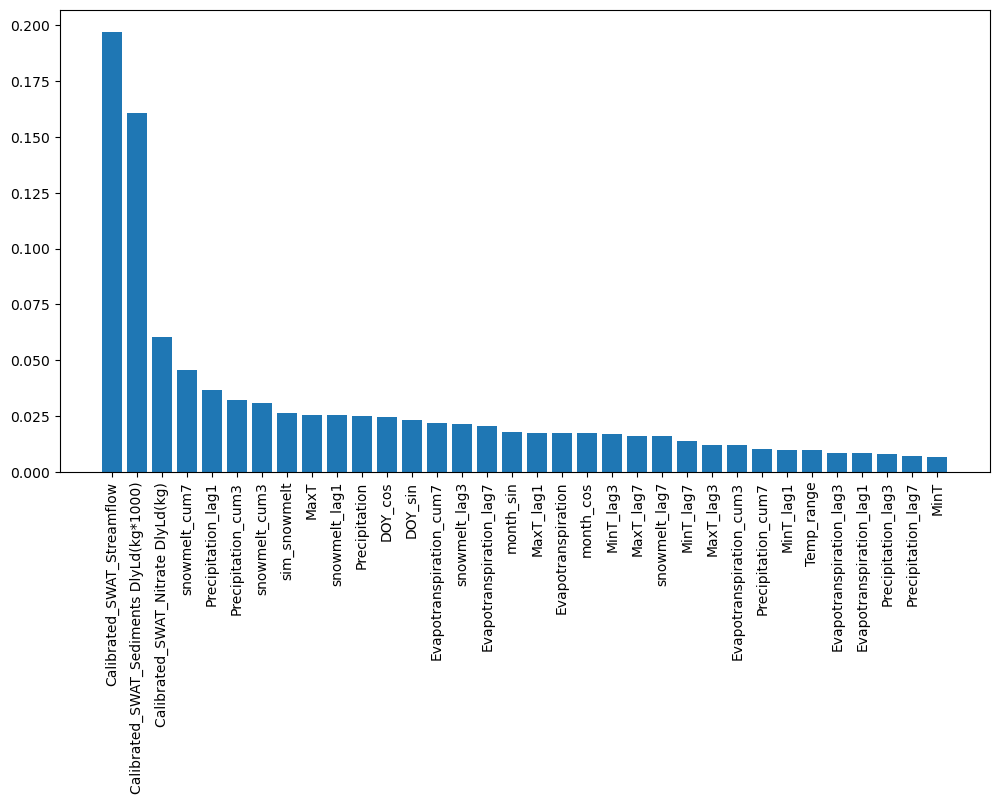

Nitrate DlyLd(kg)


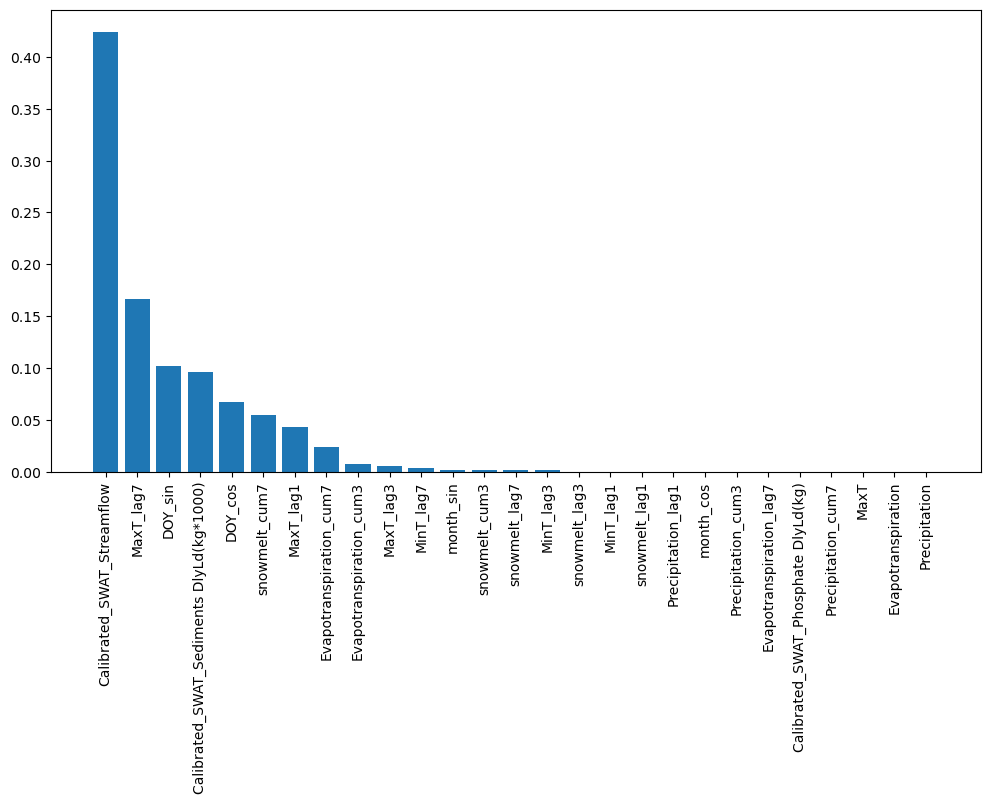

Sediments DlyLd(kg*1000)


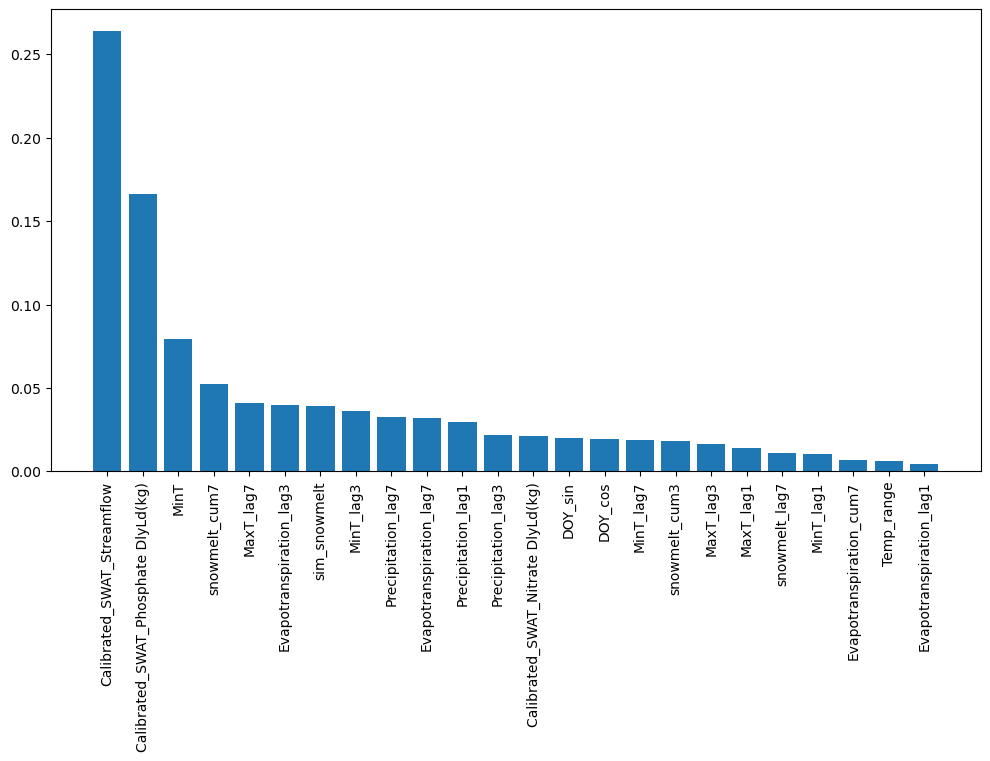

In [91]:
for target in targets:
    feat_importances = tabnet_results.get(target).get("Model").feature_importances_
    print(f"{target}")
    indices = np.argsort(feat_importances)[::-1]
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(range(len(feat_importances)), feat_importances[indices])
    ax.set_xticks(range(len(feat_importances)))
    ax.set_xticklabels(np.array(tabnet_results.get(target).get("Model Inputs"))[indices], rotation=90)

    plt.show()


In [258]:
import pandas as pd
from sklearn.metrics import r2_score, mean_absolute_error, median_absolute_error

monthly_aggregate_tabnet_metrics = {}
tabnet_monthly_aggregates  = {}
monthly_observed_aggregates = {}
for target in targets:
# Your data: daily timestep
    df = pd.DataFrame(
        {
            "date": tabnet_y_tests[target]["Date"],  # datetime
            "Observed": tabnet_y_tests[target][target],  # observed daily load (kg/day)
            "Predicted": tabnet_model_test_preds[target],  # predicted daily load (kg/day)
        }
    )

    # Convert date if needed
    df["date"] = pd.to_datetime(df["date"])

    # Extract year-month for grouping
    df["month"] = df["date"].dt.to_period("M")

    # Aggregate daily loads into monthly totals
    monthly_df = (
        df.groupby("month").agg({"Observed": "sum", "Predicted": "sum"}).reset_index()
    )
    

    tabnet_monthly_aggregates[target] = monthly_df

    # Calculate metrics on monthly loads
    monthly_r2 = r2_score(monthly_df["Observed"], monthly_df["Predicted"])
    monthly_medae = median_absolute_error(monthly_df["Observed"], monthly_df["Predicted"])
    monthly_nse = nse_score(monthly_df["Observed"], monthly_df["Predicted"])
    monthly_pbias = pbias_score(monthly_df["Observed"], monthly_df["Predicted"])

    monthly_aggregate_tabnet_metrics[target] = {
        "R2": monthly_r2,
        "MedAE": monthly_medae,
        "NSE": monthly_nse,
        "PBIAS": monthly_pbias,
    }


monthly_aggregate_tabnet_metrics_df = pd.DataFrame(monthly_aggregate_tabnet_metrics).T
monthly_aggregate_tabnet_metrics_df


KeyError: 'Phosphate DlyLd(kg)'

In [332]:
swat_daily_outputs = dataset_lagged[[f for f in dataset_lagged.columns if 'Calibrated_SWAT' in f or f == "Date"]].copy()

swat_monthly_loadings = pd.DataFrame(
    {
        "Date": swat_daily_outputs["Date"],
        "Calibrated_SWAT_Sediments DlyLd(kg*1000)": swat_daily_outputs["Calibrated_SWAT_Sediments DlyLd(kg*1000)"],
        "Calibrated_SWAT_Nitrate DlyLd(kg)": swat_daily_outputs["Calibrated_SWAT_Nitrate DlyLd(kg)"],
        "Calibrated_SWAT_Phosphate DlyLd(kg)": swat_daily_outputs["Calibrated_SWAT_Phosphate DlyLd(kg)"],
        # "Calibrated_SWAT_TotalP": swat_daily_outputs["Calibrated_SWAT_TotalP"],
    }
)

swat_monthly_loadings["Date"] = pd.to_datetime(swat_monthly_loadings["Date"])
swat_monthly_loadings["month"] = swat_monthly_loadings["Date"].dt.to_period("M")

swat_monthly_aggregates = swat_monthly_loadings.groupby("month").agg(
    {
        "Calibrated_SWAT_Sediments DlyLd(kg*1000)": "sum",
        "Calibrated_SWAT_Nitrate DlyLd(kg)": "sum",
        "Calibrated_SWAT_Phosphate DlyLd(kg)": "sum",
        # "Calibrated_SWAT_TotalP": "sum",
    }
).reset_index()

swat_monthly_aggregates = swat_monthly_aggregates[swat_monthly_aggregates["month"] >= "2005-06"].reset_index()


In [335]:
swat_monthly_metrics = {}

from scipy.stats import pearsonr


def r_squared(observed, simulated):
    return pearsonr(observed, simulated)[0] ** 2


for target in targets:
    r2 = r_squared(
        ann_monthly_aggregates[target]["Observed"],
        swat_monthly_aggregates[f'Calibrated_SWAT_{target}'],
    )
    mae = mean_absolute_error(
        ann_monthly_aggregates[target]["Observed"],
        swat_monthly_aggregates[f'Calibrated_SWAT_{target}'],
    )
    nse = nse_score(
        ann_monthly_aggregates[target]["Observed"],
        swat_monthly_aggregates[f'Calibrated_SWAT_{target}'],
    )
    pbias = pbias_score(
        ann_monthly_aggregates[target]["Observed"],
        swat_monthly_aggregates[f'Calibrated_SWAT_{target}'],
    )

    mape = mean_absolute_percentage_error(
        ann_monthly_aggregates[target]["Observed"],
        swat_monthly_aggregates[f'Calibrated_SWAT_{target}'],
    )

    swat_monthly_metrics[target] = {
        "R2": r2,
        "MAE": mae,
        "NSE": nse,
        "PBIAS": pbias,
        "MAPE": mape,
        
    }

swat_monthly_metrics_df = pd.DataFrame(swat_monthly_metrics).T
swat_monthly_metrics_df

,R2,MAE,NSE,PBIAS,MAPE
Phosphate DlyLd(kg),0.508042,524.127495,0.099956,-44.129934,1.722166
Nitrate DlyLd(kg),0.590518,9882.066108,0.510390,14.520411,0.446726
Sediments DlyLd(kg*1000),0.511763,2324.984694,0.153622,51.022839,3.779998


In [338]:
swat_monthly_aggregates


,index,month,Calibrated_SWAT_Sediments DlyLd(kg*1000),Calibrated_SWAT_Nitrate DlyLd(kg),Calibrated_SWAT_Phosphate DlyLd(kg)
0,149,2005-06,557.9230,3621.90,386.9020
1,150,2005-07,709.1270,5608.33,511.9424
2,151,2005-08,233.4840,2303.00,277.8975
3,152,2005-09,704.8540,4343.76,403.4930
4,153,2005-10,3984.2090,35734.57,3629.7873
...,...,...,...,...,...
59,208,2010-05,1195.5400,7261.88,625.8140
60,209,2010-06,911.1360,4694.41,620.9230
61,210,2010-07,838.8940,5838.00,641.8988
62,211,2010-08,1304.6350,11510.20,1326.0223


In [232]:
swat_monthly_metrics_df.round(3)


,R2,MedAE,NSE,PBIAS
Phosphate DlyLd(kg),0.516,436.857,0.531,-25.996
Nitrate DlyLd(kg),0.525,5428.134,0.539,2.284
Sediments DlyLd(kg*1000),0.132,748.639,0.159,55.432


In [95]:
import plotly.express as px

for target in targets:
    # Create a DataFrame for plotting
    plot_df = tabnet_monthly_aggregates[target].copy()
    plot_df["SWAT Simulation"] = swat_monthly_aggregates[f"Calibrated_SWAT_{target}"].values

    # Plot using Plotly Express
    fig = px.line(
        plot_df,
        x=plot_df["month"].astype("datetime64[ns]"),
        y=["Observed", "Predicted", "SWAT Simulation"],
        labels={"value": "Loadings", "month": "Month"},
        title=f"Monthly Loadings for {target}",
    )
    fig.update_layout(legend_title_text="Legend")
    fig.show()


/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  v = v.dt.to_pydatetime()


/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



# NGBoost

In [ ]:
features = {
    "Sediments DlyLd(kg*1000)": [
        "Calibrated_SWAT_Streamflow",
        
        "Calibrated_SWAT_Nitrate DlyLd(kg)",
        "Calibrated_SWAT_Phosphate DlyLd(kg)",
        
    ],
    "Nitrate DlyLd(kg)": [
        "Calibrated_SWAT_Streamflow",
        "Calibrated_SWAT_Sediments DlyLd(kg*1000)",
        
        "Calibrated_SWAT_Phosphate DlyLd(kg)",
    
    ],
    "Phosphate DlyLd(kg)": [
        "Calibrated_SWAT_Streamflow",
        "Calibrated_SWAT_Sediments DlyLd(kg*1000)",
        "Calibrated_SWAT_Nitrate DlyLd(kg)",
    
    
    ],
}


In [354]:
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK, space_eval
from ngboost import NGBRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.tree import DecisionTreeRegressor


def hyperopt_rf_tuning(X_train, y_train, X_val, y_val):


    default_params = {"n_estimators": 20, "verbose_eval": 0, "random_state": 42}


    def objective(params):

        params.update(default_params)
        
        ngb = NGBRegressor(**params).fit(
            X_train,
            y_train,
            X_val=X_val,
            Y_val=y_val,
            early_stopping_rounds=2,
        )
        
        loss = ngb.evals_result["val"]["LOGSCORE"][ngb.best_val_loss_itr]
        results = {"loss": loss, "status": STATUS_OK}
        return results
    

    b1 = DecisionTreeRegressor(criterion='friedman_mse', max_depth=2)
    b2 = DecisionTreeRegressor(criterion='friedman_mse', max_depth=3)
    b3 = DecisionTreeRegressor(criterion='friedman_mse', max_depth=4)

    space = {
        "n_estimators": hp.choice("n_estimators", [250, 500, 100]),
        'Base':hp.choice('Base', [b1, b2, b3]),
        "learning_rate": hp.uniform("learning_rate", 0.05, 0.1),
        "minibatch_frac": hp.choice("minibatch_frac", [1.0, 0.5]),
    }

    trials = Trials()
    best = fmin(
        fn=objective,
        space=space,
        algo=tpe.suggest,
        max_evals=50,
        trials=trials,
        rstate=np.random.default_rng(42),
    )
    best_params = space_eval(space, best)
    return best_params

In [355]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from ngboost import NGBRegressor
from ngboost.distns import Normal


targets = [
    "Phosphate DlyLd(kg)",
    "Nitrate DlyLd(kg)",
    "Sediments DlyLd(kg*1000)",
    # "TotalP",
]

results = {target: {} for target in targets}
model_val_preds = {}
y_vals = {}
model_inputs = {}
model_test_preds = {}
y_tests = {}
y_dists = {}

for target in targets:
    # mlflow.set_experiment("Daily Timestep")
    # with mlflow.start_run(run_name=f"{target.split()[0]}_rf_post_val_shuff"):
    X = dataset_lagged.drop(columns=["Date"] + targets, axis=1)
    y = dataset_lagged[["Date", target]]

    X = X.drop(
        columns=[
            col
            for col in X.columns
            if col.startswith("Calibrated_SWAT") and col not in features[target]
        ]
    )

    # Drop rows with NaN values
    y_clean = y.dropna()
    X_clean = X.loc[y_clean.index]
    
    # Split the data
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.4, random_state=42, shuffle=False
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.75, random_state=42, shuffle=False
    )
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


    y_tests[target] = y_test
    y_vals[target] = y_val

    # X = select_features(X_train, y_train[target], target)
    X_train = X_train[X.columns]
    X_val = X_val[X.columns]
    X_test = X_test[X.columns]

    feature_names = list(X.columns)
    # mlflow.log_dict(
    #     {f"input_features": feature_names},
    #     f"{target.split()[0]}_rf_input_features.json",
    # )

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    # log the scaler to mlflow
    # mlflow.sklearn.log_model(scaler, f"{target}_scaler")


    print(f"Hyperparameter tuning for target: {target}")
    best_params = hyperopt_rf_tuning(X_train, y_train[target], X_val, y_val[target])
    
    


    print("Best parameters:", best_params)
    

    # model = RandomForestRegressor(random_state=42, **best_params)
    model = NGBRegressor(Dist=Normal, **best_params)
    model.fit(X_train, y_train[target])
 

    # mlflow.log_params(best_params)

    # y_pred_val = model.predict(X_val)
    # model_val_preds[target] = y_pred_val

    y_pred_test = model.predict(X_test)
    model_test_preds[target] = y_pred_test
    y_dist = model.pred_dist(X_test)

    r2 = r_squared(y_test[target], y_pred_test)
    mad = median_absolute_error(y_test[target], y_pred_test)
    mae = mean_absolute_error(y_test[target], y_pred_test)
    mse = mean_squared_error(y_test[target], y_pred_test)
    nse = nse_score(y_test[target], y_pred_test)
    pbias = pbias_score(y_test[target], y_pred_test)
    test_NLL = -y_dist.logpdf(y_test[target]).mean()

    # mlflow.log_metrics({"R2": r2, "NSE": nse, "PBIAS": pbias})

    feature_importances_loc = model.feature_importances_[0]
    feature_importances_scale = model.feature_importances_[1]
    results[target] = {
        "R2": r2,
        "MAD": mad,
        "MAE": mae,
        "MSE": mse,
        "NLL": test_NLL,
        "NSE": nse,
        "PBIAS": pbias,
        "Feature Importances_loc": feature_importances_loc,
        "Feature Importances_scale": feature_importances_scale,
        "Model": model,
        "Model Inputs": X.columns,
    }

    # mlflow.sklearn.log_model(model, "rf_model")


Hyperparameter tuning for target: Phosphate DlyLd(kg)
  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square


/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:70: RuntimeWarning:

overflow encountered in exp




  2%|▏         | 1/50 [00:01<00:53,  1.09s/trial, best loss: 5.072724050035543]

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square


/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:70: RuntimeWarning:

overflow encountered in exp




  4%|▍         | 2/50 [00:02<00:59,  1.25s/trial, best loss: 5.023415532333374]

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square


/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square




  6%|▌         | 3/50 [00:03<00:48,  1.04s/trial, best loss: 5.016030562683775]

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square


/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:70: RuntimeWarning:

overflow encountered in exp




  8%|▊         | 4/50 [00:04<00:50,  1.10s/trial, best loss: 5.016030562683775]

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square


/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square




 10%|█         | 5/50 [00:05<00:41,  1.07trial/s, best loss: 5.016030562683775]

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square




 12%|█▏        | 6/50 [00:05<00:38,  1.15trial/s, best loss: 5.016030562683775]

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square




 14%|█▍        | 7/50 [00:07<00:47,  1.11s/trial, best loss: 4.925964001252888]

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square


/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square




== Early stopping achieved.                                                    
== Best iteration / VAL14 (val_loss=4.9622)                                    
 16%|█▌        | 8/50 [00:08<00:41,  1.02trial/s, best loss: 4.925964001252888]

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square




 18%|█▊        | 9/50 [00:08<00:33,  1.23trial/s, best loss: 4.890843928028781]

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square


/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:70: RuntimeWarning:

overflow encountered in exp




 20%|██        | 10/50 [00:10<00:43,  1.08s/trial, best loss: 4.890843928028781]

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square


/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:70: RuntimeWarning:

overflow encountered in exp




 22%|██▏       | 11/50 [00:12<01:00,  1.56s/trial, best loss: 4.890843928028781]

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square


/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:70: RuntimeWarning:

overflow encountered in exp




 24%|██▍       | 12/50 [00:14<00:54,  1.43s/trial, best loss: 4.890843928028781]

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square


/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square




 26%|██▌       | 13/50 [00:16<01:01,  1.65s/trial, best loss: 4.78845811823842] 

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square


/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:70: RuntimeWarning:

overflow encountered in exp




 28%|██▊       | 14/50 [00:17<00:53,  1.50s/trial, best loss: 4.78845811823842]

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square


/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square




== Early stopping achieved.                                                    
== Best iteration / VAL12 (val_loss=5.0760)                                    
 30%|███       | 15/50 [00:17<00:43,  1.24s/trial, best loss: 4.78845811823842]

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square


/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:70: RuntimeWarning:

overflow encountered in exp




 32%|███▏      | 16/50 [00:18<00:35,  1.05s/trial, best loss: 4.78845811823842]

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square




 34%|███▍      | 17/50 [00:19<00:28,  1.14trial/s, best loss: 4.78845811823842]

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square


/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:70: RuntimeWarning:

overflow encountered in exp




 36%|███▌      | 18/50 [00:21<00:43,  1.37s/trial, best loss: 4.78845811823842]

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square


/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:70: RuntimeWarning:

overflow encountered in exp




 38%|███▊      | 19/50 [00:24<00:56,  1.82s/trial, best loss: 4.78845811823842]

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square


/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:70: RuntimeWarning:

overflow encountered in exp




 40%|████      | 20/50 [00:27<01:08,  2.27s/trial, best loss: 4.78845811823842]

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square


/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:70: RuntimeWarning:

overflow encountered in exp




 42%|████▏     | 21/50 [00:28<00:56,  1.95s/trial, best loss: 4.78845811823842]

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square


/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:70: RuntimeWarning:

overflow encountered in exp




 44%|████▍     | 22/50 [00:29<00:44,  1.60s/trial, best loss: 4.78845811823842]

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square


/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:70: RuntimeWarning:

overflow encountered in exp




 46%|████▌     | 23/50 [00:30<00:36,  1.33s/trial, best loss: 4.78845811823842]

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square




 48%|████▊     | 24/50 [00:30<00:27,  1.07s/trial, best loss: 4.78845811823842]

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square


/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:70: RuntimeWarning:

overflow encountered in exp




 50%|█████     | 25/50 [00:32<00:27,  1.11s/trial, best loss: 4.78845811823842]

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square


/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square




 52%|█████▏    | 26/50 [00:32<00:24,  1.01s/trial, best loss: 4.78845811823842]

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square


/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square




 54%|█████▍    | 27/50 [00:33<00:21,  1.05trial/s, best loss: 4.78845811823842]

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square


/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square




 56%|█████▌    | 28/50 [00:34<00:20,  1.07trial/s, best loss: 4.78845811823842]

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square


/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square




 58%|█████▊    | 29/50 [00:35<00:18,  1.13trial/s, best loss: 4.78845811823842]

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square


/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square




 60%|██████    | 30/50 [00:36<00:17,  1.17trial/s, best loss: 4.78845811823842]

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square


/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square




 62%|██████▏   | 31/50 [00:37<00:19,  1.02s/trial, best loss: 4.78845811823842]

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square


/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square




 64%|██████▍   | 32/50 [00:38<00:17,  1.04trial/s, best loss: 4.78845811823842]

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square


/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square




 66%|██████▌   | 33/50 [00:39<00:15,  1.07trial/s, best loss: 4.78845811823842]

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square


/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square




 68%|██████▊   | 34/50 [00:40<00:14,  1.13trial/s, best loss: 4.78845811823842]

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square


/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square




 70%|███████   | 35/50 [00:40<00:12,  1.17trial/s, best loss: 4.78845811823842]

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square


/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square




 72%|███████▏  | 36/50 [00:41<00:11,  1.20trial/s, best loss: 4.78845811823842]

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square


/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square




== Early stopping achieved.                                                    
== Best iteration / VAL14 (val_loss=5.0088)                                    
 74%|███████▍  | 37/50 [00:42<00:10,  1.27trial/s, best loss: 4.78845811823842]

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square


/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square




 76%|███████▌  | 38/50 [00:43<00:11,  1.05trial/s, best loss: 4.78845811823842]

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square


/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:70: RuntimeWarning:

overflow encountered in exp




 78%|███████▊  | 39/50 [00:45<00:12,  1.14s/trial, best loss: 4.78845811823842]

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square


/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square




 80%|████████  | 40/50 [00:46<00:10,  1.10s/trial, best loss: 4.78845811823842]

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square


/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square




== Early stopping achieved.                                                    
== Best iteration / VAL14 (val_loss=4.9671)                                    
 82%|████████▏ | 41/50 [00:46<00:08,  1.04trial/s, best loss: 4.78845811823842]

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square


/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:70: RuntimeWarning:

overflow encountered in exp




 84%|████████▍ | 42/50 [00:49<00:10,  1.34s/trial, best loss: 4.78845811823842]

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square


/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square




 86%|████████▌ | 43/50 [00:49<00:08,  1.18s/trial, best loss: 4.78845811823842]

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square


/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square




 88%|████████▊ | 44/50 [00:50<00:06,  1.07s/trial, best loss: 4.78845811823842]

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square


/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:70: RuntimeWarning:

overflow encountered in exp




 90%|█████████ | 45/50 [00:52<00:05,  1.15s/trial, best loss: 4.78845811823842]

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square


/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square




 92%|█████████▏| 46/50 [00:52<00:04,  1.04s/trial, best loss: 4.78845811823842]

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square


/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square




 94%|█████████▍| 47/50 [00:53<00:02,  1.04trial/s, best loss: 4.785276639728089]

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square


/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:70: RuntimeWarning:

overflow encountered in exp




 96%|█████████▌| 48/50 [00:55<00:02,  1.22s/trial, best loss: 4.785276639728089]

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square


/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:70: RuntimeWarning:

overflow encountered in exp




 98%|█████████▊| 49/50 [00:56<00:01,  1.04s/trial, best loss: 4.785276639728089]

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square


/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square




100%|██████████| 50/50 [00:56<00:00,  1.14s/trial, best loss: 4.785276639728089]
Best parameters: {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.08905048350017838, 'minibatch_frac': 1.0, 'n_estimators': 100}
[iter 0] loss=6.2740 val_loss=0.0000 scale=1.0000 norm=39.1189


/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square



Hyperparameter tuning for target: Nitrate DlyLd(kg)
  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square




  2%|▏         | 1/50 [00:00<00:28,  1.69trial/s, best loss: 7.617773487111971]

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square




  4%|▍         | 2/50 [00:01<00:49,  1.04s/trial, best loss: 7.580968521622036]

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square




  6%|▌         | 3/50 [00:03<00:51,  1.09s/trial, best loss: 7.580968521622036]

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square




  8%|▊         | 4/50 [00:04<00:55,  1.21s/trial, best loss: 7.580968521622036]

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square




 10%|█         | 5/50 [00:04<00:42,  1.06trial/s, best loss: 7.580968521622036]

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square




 12%|█▏        | 6/50 [00:05<00:35,  1.22trial/s, best loss: 7.580968521622036]

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square




 14%|█▍        | 7/50 [00:06<00:30,  1.42trial/s, best loss: 7.580968521622036]

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square




 16%|█▌        | 8/50 [00:06<00:30,  1.38trial/s, best loss: 7.580968521622036]

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square




 18%|█▊        | 9/50 [00:07<00:25,  1.58trial/s, best loss: 7.580968521622036]

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square




 20%|██        | 10/50 [00:10<00:55,  1.39s/trial, best loss: 7.580968521622036]

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square




 22%|██▏       | 11/50 [00:12<01:03,  1.62s/trial, best loss: 7.580968521622036]

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square


/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:70: RuntimeWarning:

overflow encountered in exp




 24%|██▍       | 12/50 [00:13<00:54,  1.43s/trial, best loss: 7.580968521622036]

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square




 26%|██▌       | 13/50 [00:14<00:46,  1.25s/trial, best loss: 7.580968521622036]

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square




 28%|██▊       | 14/50 [00:16<00:52,  1.45s/trial, best loss: 7.580968521622036]

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square




 30%|███       | 15/50 [00:16<00:43,  1.24s/trial, best loss: 7.580968521622036]

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square




 32%|███▏      | 16/50 [00:17<00:36,  1.07s/trial, best loss: 7.561523128836474]

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square




 34%|███▍      | 17/50 [00:18<00:29,  1.11trial/s, best loss: 7.561523128836474]

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square




 36%|███▌      | 18/50 [00:20<00:44,  1.40s/trial, best loss: 7.561523128836474]

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square




 38%|███▊      | 19/50 [00:21<00:42,  1.37s/trial, best loss: 7.561523128836474]

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square




 40%|████      | 20/50 [00:23<00:40,  1.35s/trial, best loss: 7.561523128836474]

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square




 42%|████▏     | 21/50 [00:23<00:32,  1.11s/trial, best loss: 7.561523128836474]

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square




 44%|████▍     | 22/50 [00:24<00:26,  1.05trial/s, best loss: 7.561523128836474]

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square




 46%|████▌     | 23/50 [00:25<00:23,  1.17trial/s, best loss: 7.561523128836474]

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square




 48%|████▊     | 24/50 [00:25<00:19,  1.30trial/s, best loss: 7.561523128836474]

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square




 50%|█████     | 25/50 [00:26<00:21,  1.18trial/s, best loss: 7.561523128836474]

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square




 52%|█████▏    | 26/50 [00:27<00:19,  1.22trial/s, best loss: 7.561523128836474]

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square




 54%|█████▍    | 27/50 [00:28<00:17,  1.32trial/s, best loss: 7.561523128836474]

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square




 56%|█████▌    | 28/50 [00:29<00:21,  1.03trial/s, best loss: 7.561523128836474]

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square




 58%|█████▊    | 29/50 [00:30<00:18,  1.15trial/s, best loss: 7.561523128836474]

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square




 60%|██████    | 30/50 [00:31<00:18,  1.08trial/s, best loss: 7.561523128836474]

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square




 62%|██████▏   | 31/50 [00:31<00:15,  1.23trial/s, best loss: 7.561523128836474]

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square




 64%|██████▍   | 32/50 [00:33<00:17,  1.05trial/s, best loss: 7.561523128836474]

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square




 66%|██████▌   | 33/50 [00:34<00:17,  1.00s/trial, best loss: 7.561523128836474]

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square




 68%|██████▊   | 34/50 [00:34<00:13,  1.15trial/s, best loss: 7.561523128836474]

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square




 70%|███████   | 35/50 [00:35<00:13,  1.10trial/s, best loss: 7.561523128836474]

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square




 72%|███████▏  | 36/50 [00:36<00:11,  1.25trial/s, best loss: 7.561523128836474]

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square




 74%|███████▍  | 37/50 [00:37<00:12,  1.03trial/s, best loss: 7.561523128836474]

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square




 76%|███████▌  | 38/50 [00:38<00:10,  1.19trial/s, best loss: 7.561523128836474]

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square




 78%|███████▊  | 39/50 [00:39<00:09,  1.12trial/s, best loss: 7.5486221841531185]

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square




 80%|████████  | 40/50 [00:39<00:07,  1.34trial/s, best loss: 7.5486221841531185]

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square




 82%|████████▏ | 41/50 [00:40<00:08,  1.10trial/s, best loss: 7.5486221841531185]

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square




 84%|████████▍ | 42/50 [00:41<00:06,  1.21trial/s, best loss: 7.5486221841531185]

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square




 86%|████████▌ | 43/50 [00:42<00:05,  1.20trial/s, best loss: 7.5486221841531185]

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square


/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:70: RuntimeWarning:

overflow encountered in exp




 88%|████████▊ | 44/50 [00:43<00:04,  1.26trial/s, best loss: 7.5486221841531185]

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square




 90%|█████████ | 45/50 [00:44<00:04,  1.13trial/s, best loss: 7.5486221841531185]

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square




 92%|█████████▏| 46/50 [00:44<00:03,  1.19trial/s, best loss: 7.5486221841531185]

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square




 94%|█████████▍| 47/50 [00:45<00:02,  1.09trial/s, best loss: 7.5486221841531185]

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square




 96%|█████████▌| 48/50 [00:47<00:02,  1.03s/trial, best loss: 7.5486221841531185]

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square




 98%|█████████▊| 49/50 [00:47<00:00,  1.07trial/s, best loss: 7.5486221841531185]

/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square




100%|██████████| 50/50 [00:48<00:00,  1.02trial/s, best loss: 7.5486221841531185]
Best parameters: {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.09784107182479629, 'minibatch_frac': 1.0, 'n_estimators': 100}
[iter 0] loss=8.8577 val_loss=0.0000 scale=1.0000 norm=829.2624


/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning:

overflow encountered in square



Hyperparameter tuning for target: Sediments DlyLd(kg*1000)
  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

job exception: Input y contains NaN.



  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]


ValueError: Input y contains NaN.

In [304]:
# create dataframe for exp3_results only showing the metrics
results_df = pd.DataFrame(results).T.drop(
    columns=[
        "Model",
        "Model Inputs",
        "Feature Importances_loc",
        "Feature Importances_scale",
    ]
)
results_df


,R2,MAD,MAE,MSE,NLL,NSE,PBIAS
Phosphate DlyLd(kg),0.277086,8.276754,22.338195,4058.560509,5.506913,0.13219,-31.013005
Nitrate DlyLd(kg),0.627687,262.699898,429.811164,520750.003291,8.435024,0.433442,-43.03264
Sediments DlyLd(kg*1000),0.237908,4.183448,86.424639,378696.465282,23.307687,0.19415,53.827176


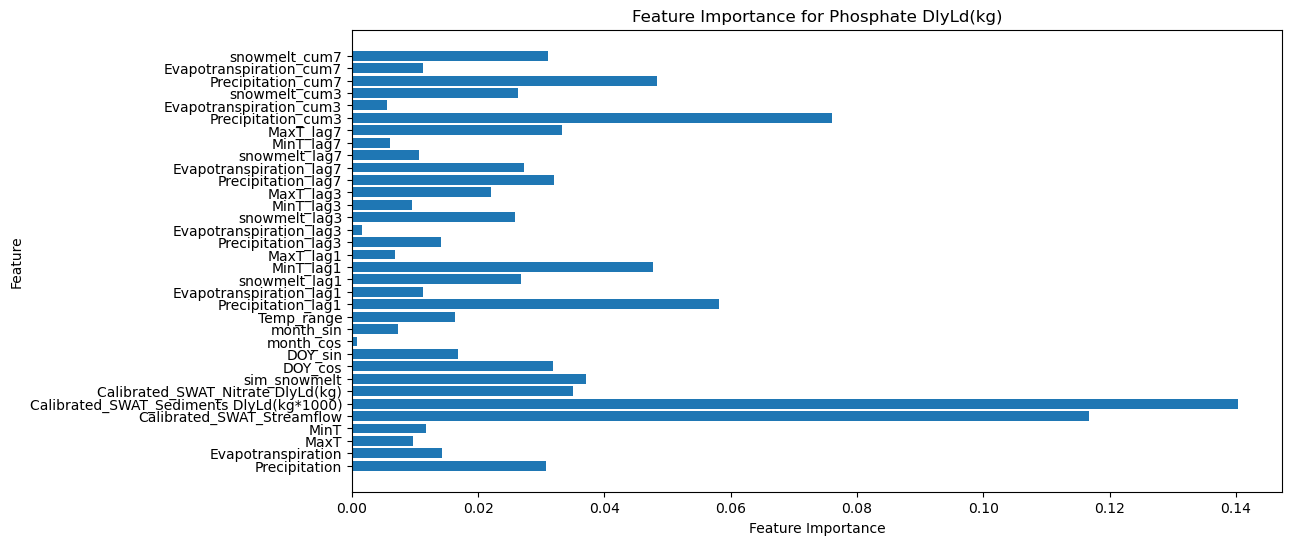

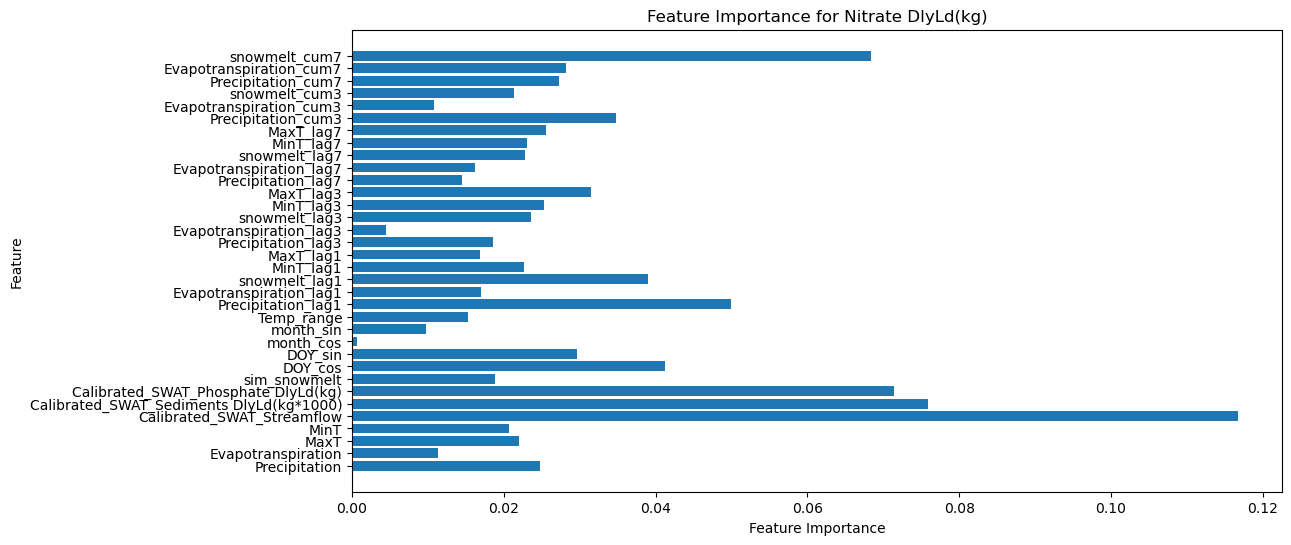

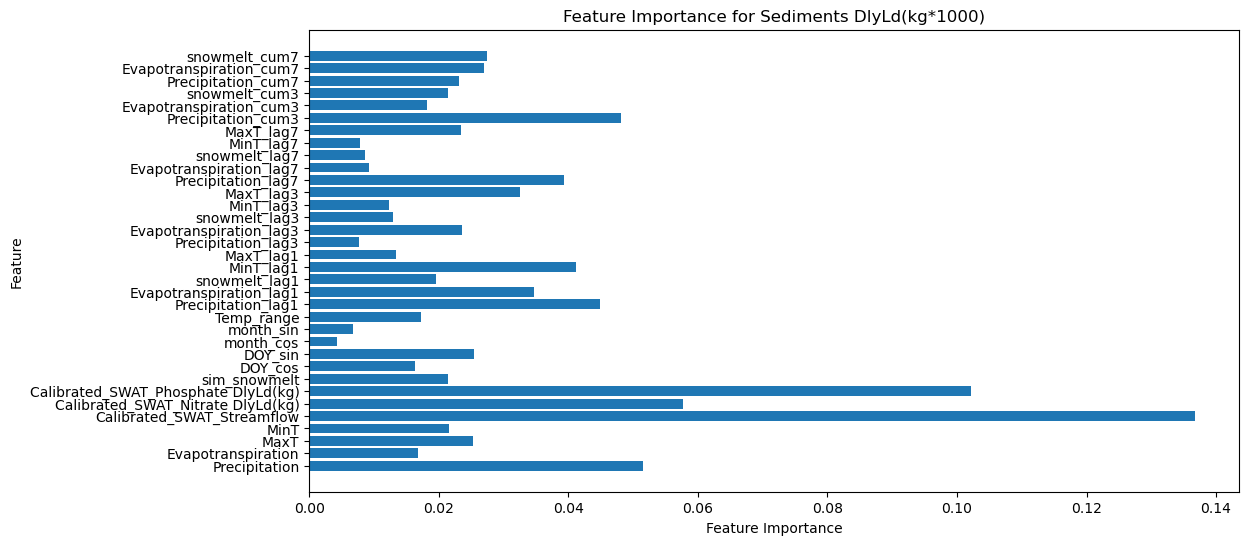

In [305]:
# plot feature importance bar charts

for target in targets:
    feature_importances = results[target]["Feature Importances_loc"]
    feature_names = results[target]["Model Inputs"]
    plt.figure(figsize=(12, 6))
    plt.barh(feature_names, feature_importances)
    plt.xlabel("Feature Importance")
    plt.ylabel("Feature")
    plt.title(f"Feature Importance for {target}")
    plt.show()

In [307]:
import pandas as pd
from sklearn.metrics import r2_score, mean_absolute_error, median_absolute_error

monthly_aggregate_metrics = {}
monthly_aggregates = {}
monthly_observed_aggregates = {}
for target in targets:
    # Your data: daily timestep
    df = pd.DataFrame(
        {
            "date": y_tests[target]["Date"],  # datetime
            "Observed": y_tests[target][target],  # observed daily load (kg/day)
            "Predicted": model_test_preds[
                target
            ],  # predicted daily load (kg/day)
        }
    )

    # Convert date if needed
    df["date"] = pd.to_datetime(df["date"])

    # Extract year-month for grouping
    df["month"] = df["date"].dt.to_period("M")

    # Aggregate daily loads into monthly totals
    monthly_df = (
        df.groupby("month").agg({"Observed": "sum", "Predicted": "sum"}).reset_index()
    )

    monthly_aggregates[target] = monthly_df

    # Calculate metrics on monthly loads
    monthly_r2 = r2_score(monthly_df["Observed"], monthly_df["Predicted"])
    monthly_medae = median_absolute_error(
        monthly_df["Observed"], monthly_df["Predicted"]
    )
    monthly_nse = nse_score(monthly_df["Observed"], monthly_df["Predicted"])
    monthly_pbias = pbias_score(monthly_df["Observed"], monthly_df["Predicted"])

    monthly_aggregate_metrics[target] = {
        "R2": monthly_r2,
        "MedAE": monthly_medae,
        "NSE": monthly_nse,
        "PBIAS": monthly_pbias,
        "MAE": mean_absolute_error(monthly_df["Observed"], monthly_df["Predicted"]),
        "MAPE": mean_absolute_percentage_error(monthly_df["Observed"], monthly_df["Predicted"])
    }


monthly_aggregate_metrics_df = pd.DataFrame(monthly_aggregate_metrics).T
monthly_aggregate_metrics_df


,R2,MedAE,NSE,PBIAS,MAE,MAPE
Phosphate DlyLd(kg),0.653618,271.885016,0.664442,-31.013005,376.179981,0.962374
Nitrate DlyLd(kg),0.525138,9488.942978,0.539977,-43.032640,10363.730970,0.656992
Sediments DlyLd(kg*1000),0.384092,316.926999,0.403339,53.827176,2155.347746,0.900599


# Feed Forward Neural Network

In [346]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from early_stopping_pytorch import EarlyStopping
from tqdm import tqdm


class learnKappa_layers1(nn.Module):
    def __init__(self, In_nodes, Hid, Out_nodes):
        super(learnKappa_layers1, self).__init__()
        self.linear1 = nn.Linear(In_nodes, Hid)  # Input to hidden layer
        self.linear2 = nn.Linear(Hid, Out_nodes)  # Hidden to output layer
        self.dropout = nn.Dropout(0.20)  # Dropout to reduce overfitting

    def forward(self, x):
        x2 = self.linear1(x)
        h1 = torch.relu(x2)  # ReLU activation
        # h1 = self.dropout(h1)
        y_pred = self.linear2(h1)  # Output predictions
        return y_pred


class learnKappa_layers2(nn.Module):
    def __init__(self, In_nodes, Hid, Out_nodes):
        super(learnKappa_layers2, self).__init__()
        self.linear1 = nn.Linear(In_nodes, Hid)
        self.linear2 = nn.Linear(Hid, Hid)
        self.linear3 = nn.Linear(Hid, Out_nodes)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x2 = self.linear1(x)
        h1 = torch.relu(x2)
        h1 = self.dropout(h1)
        h2 = self.linear2(h1)
        h3 = torch.relu(h2)
        h3 = self.dropout(h3)
        y_pred = self.linear3(h3)
        return y_pred


def modeltrain_loss(
    in_nodes,
    hid_nodes,
    out_nodes,
    lr,
    epochs,
    X_train,
    y_train,
    X_val,
    y_val,
    model,
    patience=400,
):
    criterion = nn.SmoothL1Loss()  # Loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)  # Optimizer
    early_stopping = EarlyStopping(patience=patience, verbose=True)

    # Create arrays to store loss values
    train_losses = []
    val_losses = []

    with tqdm(total=epochs) as pbar:
        for epoch in range(epochs):
            # Training mode
            model.train()
            optimizer.zero_grad()
            y_pred = model(X_train)
            # Reshape y_pred if needed to match y_train
            y_pred = y_pred.reshape(-1)
            loss = criterion(y_pred, y_train)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

            # Validation mode
            model.eval()
            with torch.no_grad():
                y_val_pred = model(X_val)
                # Reshape y_val_pred if needed to match y_val
                y_val_pred = y_val_pred.reshape(-1)
                val_loss = criterion(y_val_pred, y_val)
                val_losses.append(val_loss.item())

            # Update progress bar
            pbar.update(1)
            pbar.set_description(
                f"Epoch {epoch + 1}/{epochs} | Train Loss: {loss.item():.4f} | Val Loss: {val_loss.item():.4f}"
            )

            # Early stopping
            early_stopping(val_loss, model)
            if early_stopping.early_stop:
                print(f"Early stopping at epoch {epoch + 1}")
                break

    return model, (train_losses, val_losses)


# Define targets before the loop
targets = [
    "Phosphate DlyLd(kg)",
    "Nitrate DlyLd(kg)",
    "Sediments DlyLd(kg*1000)",
]
y_vals = {}
ann_results = {target: {} for target in targets}
ann_y_tests = {}
ann_model_test_preds = {}

# Assuming dataset_lagged is defined elsewhere and available

# Train NN for each target
for target in targets:
    print(f"Training model for target: {target}")

    torch.manual_seed(10)
    X = datasets[target].drop(columns=["Date"] + [target], axis=1)
    y = datasets[target][["Date", target]]

    X = X.drop(
        columns=[
            col
            for col in X.columns
            if col.startswith("Calibrated_SWAT") and col not in features[target]
        ]
    )

    # Split the data
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.4, random_state=42, shuffle=False
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.75, random_state=42, shuffle=False
    )
    y_vals[target] = y_val
    ann_y_tests[target] = y_test

    feature_names = list(X.columns)

    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    # Log transform target variable
    log_transform = False
    if target in [
        # "Sediments DlyLd(kg*1000)",
        # "Nitrate DlyLd(kg)",
        # "Phosphate DlyLd(kg)",
    ]:
        log_transform = True

    if log_transform:
        # Add a small constant to handle negative values
        min_val = min(y_train[target].min(), y_val[target].min())
        offset = abs(min_val) + 1 if min_val < 0 else 0
        y_train_log = np.log1p(y_train[target] + offset).values
        y_val_log = np.log1p(y_val[target] + offset).values
        y_test_log = np.log1p(y_test[target] + offset).values  # Also transform test

        y_train_tensor = torch.tensor(y_train_log, dtype=torch.float32)
        y_val_tensor = torch.tensor(y_val_log, dtype=torch.float32)
        y_test_tensor = torch.tensor(
            y_test_log, dtype=torch.float32
        )  # Use transformed test

        # Store the offset for inverse transformation
        y_transformers = {target: {"offset": offset, "log_transform": True}}
    else:
        y_train_tensor = torch.tensor(y_train[target].values, dtype=torch.float32)
        y_val_tensor = torch.tensor(y_val[target].values, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test[target].values, dtype=torch.float32)
        y_transformers = {target: {"offset": 0, "log_transform": False}}

    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

    epochs, lr = 5000, 1e-2  # Adjusted learning rate from 1e-01 to 1e-3
    in_nod, hid_nod, o_nod = X_train_tensor.shape[1], 16, 1

    model = learnKappa_layers1(in_nod, hid_nod, o_nod)
    model, loss_arrays = modeltrain_loss(
        in_nod,
        hid_nod,
        o_nod,
        lr,
        epochs,
        X_train_tensor,
        y_train_tensor,
        X_val_tensor,
        y_val_tensor,
        model,
        patience=500,  # Reduced patience from 1000 to 100
    )

    # Evaluate model on test set
    model.eval()
    with torch.no_grad():
        test_predictions = model(X_test_tensor).reshape(-1).numpy()

    # Inverse transform predictions
    if y_transformers[target]["log_transform"]:
        y_pred_test = np.expm1(test_predictions) - y_transformers[target]["offset"]
    else:
        y_pred_test = test_predictions

    # Store results
    ann_model_test_preds[target] = y_pred_test

    # Calculate metrics
    observed = y_test[target].values

    # Calculate R² using sklearn function
    # r2 = r2_score(observed, y_pred_test)

    # Calculate NSE using the external function (assuming it's defined)
    nse = nse_score(observed, y_pred_test)

    # Calculate PBIAS using the external function (assuming it's defined)
    pbias_value = pbias_score(observed, y_pred_test)

    ann_results[target] = {
        "r2": r_squared(observed, y_pred_test),
        "nse": nse,
        "pbias": pbias_value,
        "mape": mean_absolute_percentage_error(observed, y_pred_test),
        "mae": mean_absolute_error(observed, y_pred_test),
        "model_inputs": feature_names,
        # "model": model,
        # "scaler": scaler,
        # "loss_arrays": loss_arrays,
    }

    print(f"Completed training for {target}:")

    print(f"  R²: {r2:.4f}")
    print(f"  NSE: {nse:.4f}")
    print(f"  PBIAS: {pbias_value:.4f}%")

    # # plot training curves
    # plt.figure(figsize=(12, 6))
    # plt.plot(loss_arrays[0], label="Train Loss")
    # plt.plot(loss_arrays[1], label="Validation Loss")
    # plt.xlabel("Epochs")
    # plt.ylabel("Loss")
    # plt.title(f"Training and Validation Loss for {target}")
    # plt.legend()
    # plt.show()


Training model for target: Phosphate DlyLd(kg)


Epoch 38/5000 | Train Loss: 29.0790 | Val Loss: 26.1770:   1%|          | 38/5000 [00:00<00:18, 269.50it/s]

Validation loss decreased (inf --> 33.167305).  Saving model ...
Validation loss decreased (33.167305 --> 33.081047).  Saving model ...
Validation loss decreased (33.081047 --> 32.986000).  Saving model ...
Validation loss decreased (32.986000 --> 32.873413).  Saving model ...
Validation loss decreased (32.873413 --> 32.743034).  Saving model ...
Validation loss decreased (32.743034 --> 32.598721).  Saving model ...
Validation loss decreased (32.598721 --> 32.440575).  Saving model ...
Validation loss decreased (32.440575 --> 32.268269).  Saving model ...
Validation loss decreased (32.268269 --> 32.081554).  Saving model ...
Validation loss decreased (32.081554 --> 31.880369).  Saving model ...
Validation loss decreased (31.880369 --> 31.664888).  Saving model ...
Validation loss decreased (31.664888 --> 31.435862).  Saving model ...
Validation loss decreased (31.435862 --> 31.194378).  Saving model ...
Validation loss decreased (31.194378 --> 30.941929).  Saving model ...
Validation l

Epoch 44/5000 | Train Loss: 28.8085 | Val Loss: 26.0764:   1%|          | 44/5000 [00:00<00:18, 269.50it/s]

Validation loss decreased (26.177011 --> 26.141174).  Saving model ...
Validation loss decreased (26.141174 --> 26.116014).  Saving model ...
Validation loss decreased (26.116014 --> 26.098461).  Saving model ...
Validation loss decreased (26.098461 --> 26.086388).  Saving model ...
Validation loss decreased (26.086388 --> 26.079346).  Saving model ...
Validation loss decreased (26.079346 --> 26.076410).  Saving model ...


Epoch 114/5000 | Train Loss: 26.5401 | Val Loss: 24.6878:   2%|▏         | 114/5000 [00:00<00:15, 316.59it/s]

Validation loss decreased (26.076410 --> 26.076078).  Saving model ...
EarlyStopping counter: 1 out of 500
EarlyStopping counter: 2 out of 500
EarlyStopping counter: 3 out of 500
Validation loss decreased (26.076078 --> 26.074369).  Saving model ...
Validation loss decreased (26.074369 --> 26.069340).  Saving model ...
Validation loss decreased (26.069340 --> 26.061436).  Saving model ...
Validation loss decreased (26.061436 --> 26.050446).  Saving model ...
Validation loss decreased (26.050446 --> 26.036335).  Saving model ...
Validation loss decreased (26.036335 --> 26.019165).  Saving model ...
Validation loss decreased (26.019165 --> 25.999111).  Saving model ...
Validation loss decreased (25.999111 --> 25.976423).  Saving model ...
Validation loss decreased (25.976423 --> 25.951437).  Saving model ...
Validation loss decreased (25.951437 --> 25.924530).  Saving model ...
Validation loss decreased (25.924530 --> 25.896076).  Saving model ...
Validation loss decreased (25.896076 -->

Epoch 124/5000 | Train Loss: 26.1782 | Val Loss: 24.5323:   2%|▏         | 124/5000 [00:00<00:15, 316.59it/s]

Validation loss decreased (24.687817 --> 24.670486).  Saving model ...
Validation loss decreased (24.670486 --> 24.653433).  Saving model ...
Validation loss decreased (24.653433 --> 24.636717).  Saving model ...
Validation loss decreased (24.636717 --> 24.620380).  Saving model ...
Validation loss decreased (24.620380 --> 24.604441).  Saving model ...
Validation loss decreased (24.604441 --> 24.588955).  Saving model ...
Validation loss decreased (24.588955 --> 24.573977).  Saving model ...
Validation loss decreased (24.573977 --> 24.559511).  Saving model ...
Validation loss decreased (24.559511 --> 24.545609).  Saving model ...
Validation loss decreased (24.545609 --> 24.532282).  Saving model ...


Epoch 164/5000 | Train Loss: 24.8145 | Val Loss: 24.1798:   3%|▎         | 164/5000 [00:00<00:15, 318.34it/s]

Validation loss decreased (24.532282 --> 24.519552).  Saving model ...
Validation loss decreased (24.519552 --> 24.507408).  Saving model ...
Validation loss decreased (24.507408 --> 24.495850).  Saving model ...
Validation loss decreased (24.495850 --> 24.484863).  Saving model ...
Validation loss decreased (24.484863 --> 24.474543).  Saving model ...
Validation loss decreased (24.474543 --> 24.464945).  Saving model ...
Validation loss decreased (24.464945 --> 24.456072).  Saving model ...
Validation loss decreased (24.456072 --> 24.447880).  Saving model ...
Validation loss decreased (24.447880 --> 24.440273).  Saving model ...
Validation loss decreased (24.440273 --> 24.433167).  Saving model ...
Validation loss decreased (24.433167 --> 24.426420).  Saving model ...
Validation loss decreased (24.426420 --> 24.419918).  Saving model ...
Validation loss decreased (24.419918 --> 24.413563).  Saving model ...
Validation loss decreased (24.413563 --> 24.407310).  Saving model ...
Valida

Epoch 230/5000 | Train Loss: 23.2293 | Val Loss: 22.6781:   5%|▍         | 230/5000 [00:01<00:28, 168.35it/s]

Validation loss decreased (24.179773 --> 24.167215).  Saving model ...
Validation loss decreased (24.167215 --> 24.154125).  Saving model ...
Validation loss decreased (24.154125 --> 24.140526).  Saving model ...
Validation loss decreased (24.140526 --> 24.126469).  Saving model ...
Validation loss decreased (24.126469 --> 24.111988).  Saving model ...
Validation loss decreased (24.111988 --> 24.097124).  Saving model ...
Validation loss decreased (24.097124 --> 24.081926).  Saving model ...
Validation loss decreased (24.081926 --> 24.066439).  Saving model ...
Validation loss decreased (24.066439 --> 24.050730).  Saving model ...
Validation loss decreased (24.050730 --> 24.034964).  Saving model ...
Validation loss decreased (24.034964 --> 24.019192).  Saving model ...
Validation loss decreased (24.019192 --> 24.003422).  Saving model ...
Validation loss decreased (24.003422 --> 23.987658).  Saving model ...
Validation loss decreased (23.987658 --> 23.971872).  Saving model ...
Valida

Epoch 315/5000 | Train Loss: 22.0500 | Val Loss: 21.5670:   6%|▋         | 315/5000 [00:01<00:15, 297.63it/s]

Validation loss decreased (22.678083 --> 22.653326).  Saving model ...
Validation loss decreased (22.653326 --> 22.629086).  Saving model ...
Validation loss decreased (22.629086 --> 22.605194).  Saving model ...
Validation loss decreased (22.605194 --> 22.581532).  Saving model ...
Validation loss decreased (22.581532 --> 22.558517).  Saving model ...
Validation loss decreased (22.558517 --> 22.536049).  Saving model ...
Validation loss decreased (22.536049 --> 22.514149).  Saving model ...
Validation loss decreased (22.514149 --> 22.492687).  Saving model ...
Validation loss decreased (22.492687 --> 22.471409).  Saving model ...
Validation loss decreased (22.471409 --> 22.450182).  Saving model ...
Validation loss decreased (22.450182 --> 22.428970).  Saving model ...
Validation loss decreased (22.428970 --> 22.407669).  Saving model ...
Validation loss decreased (22.407669 --> 22.386335).  Saving model ...
Validation loss decreased (22.386335 --> 22.365063).  Saving model ...
Valida

Epoch 408/5000 | Train Loss: 21.6069 | Val Loss: 21.4246:   8%|▊         | 408/5000 [00:01<00:12, 377.82it/s]

Validation loss decreased (21.566967 --> 21.561104).  Saving model ...
Validation loss decreased (21.561104 --> 21.555399).  Saving model ...
Validation loss decreased (21.555399 --> 21.550962).  Saving model ...
Validation loss decreased (21.550962 --> 21.548023).  Saving model ...
Validation loss decreased (21.548023 --> 21.546566).  Saving model ...
EarlyStopping counter: 1 out of 500
EarlyStopping counter: 2 out of 500
EarlyStopping counter: 3 out of 500
EarlyStopping counter: 4 out of 500
EarlyStopping counter: 5 out of 500
EarlyStopping counter: 6 out of 500
EarlyStopping counter: 7 out of 500
EarlyStopping counter: 8 out of 500
EarlyStopping counter: 9 out of 500
EarlyStopping counter: 10 out of 500
EarlyStopping counter: 11 out of 500
EarlyStopping counter: 12 out of 500
EarlyStopping counter: 13 out of 500
EarlyStopping counter: 14 out of 500
EarlyStopping counter: 15 out of 500
EarlyStopping counter: 16 out of 500
EarlyStopping counter: 17 out of 500
Validation loss decreased

Epoch 437/5000 | Train Loss: 21.5007 | Val Loss: 21.3574:   9%|▊         | 437/5000 [00:01<00:12, 377.82it/s]

Validation loss decreased (21.424561 --> 21.422325).  Saving model ...
Validation loss decreased (21.422325 --> 21.420918).  Saving model ...
Validation loss decreased (21.420918 --> 21.420139).  Saving model ...
Validation loss decreased (21.420139 --> 21.419779).  Saving model ...
Validation loss decreased (21.419779 --> 21.419741).  Saving model ...
Validation loss decreased (21.419741 --> 21.419460).  Saving model ...
Validation loss decreased (21.419460 --> 21.418320).  Saving model ...
Validation loss decreased (21.418320 --> 21.416319).  Saving model ...
Validation loss decreased (21.416319 --> 21.413292).  Saving model ...
Validation loss decreased (21.413292 --> 21.409370).  Saving model ...
Validation loss decreased (21.409370 --> 21.405216).  Saving model ...
Validation loss decreased (21.405216 --> 21.401342).  Saving model ...
Validation loss decreased (21.401342 --> 21.398781).  Saving model ...
Validation loss decreased (21.398781 --> 21.397005).  Saving model ...
Valida

Epoch 449/5000 | Train Loss: 21.4488 | Val Loss: 21.2697:   9%|▉         | 449/5000 [00:01<00:25, 180.84it/s]

Validation loss decreased (21.357359 --> 21.354338).  Saving model ...
Validation loss decreased (21.354338 --> 21.349876).  Saving model ...
Validation loss decreased (21.349876 --> 21.343891).  Saving model ...
Validation loss decreased (21.343891 --> 21.336058).  Saving model ...
Validation loss decreased (21.336058 --> 21.327152).  Saving model ...
Validation loss decreased (21.327152 --> 21.317989).  Saving model ...
Validation loss decreased (21.317989 --> 21.308937).  Saving model ...
Validation loss decreased (21.308937 --> 21.300550).  Saving model ...
Validation loss decreased (21.300550 --> 21.292709).  Saving model ...
Validation loss decreased (21.292709 --> 21.285313).  Saving model ...
Validation loss decreased (21.285313 --> 21.277752).  Saving model ...
Validation loss decreased (21.277752 --> 21.269693).  Saving model ...


Epoch 452/5000 | Train Loss: 21.4336 | Val Loss: 21.2451:   9%|▉         | 452/5000 [00:02<00:25, 180.84it/s]

Validation loss decreased (21.269693 --> 21.261568).  Saving model ...
Validation loss decreased (21.261568 --> 21.253216).  Saving model ...


Epoch 481/5000 | Train Loss: 21.2913 | Val Loss: 21.1195:  10%|▉         | 481/5000 [00:02<00:34, 130.94it/s]

Validation loss decreased (21.253216 --> 21.245079).  Saving model ...
Validation loss decreased (21.245079 --> 21.237349).  Saving model ...
Validation loss decreased (21.237349 --> 21.230196).  Saving model ...
Validation loss decreased (21.230196 --> 21.222513).  Saving model ...
Validation loss decreased (21.222513 --> 21.214912).  Saving model ...
Validation loss decreased (21.214912 --> 21.207289).  Saving model ...
Validation loss decreased (21.207289 --> 21.200584).  Saving model ...
Validation loss decreased (21.200584 --> 21.194529).  Saving model ...
Validation loss decreased (21.194529 --> 21.189663).  Saving model ...
Validation loss decreased (21.189663 --> 21.186472).  Saving model ...
Validation loss decreased (21.186472 --> 21.184044).  Saving model ...
Validation loss decreased (21.184044 --> 21.181971).  Saving model ...
Validation loss decreased (21.181971 --> 21.179029).  Saving model ...
Validation loss decreased (21.179029 --> 21.175653).  Saving model ...
Valida

Epoch 558/5000 | Train Loss: 20.9811 | Val Loss: 20.8424:  11%|█         | 558/5000 [00:02<00:22, 197.61it/s]

Validation loss decreased (21.119534 --> 21.116608).  Saving model ...
Validation loss decreased (21.116608 --> 21.113575).  Saving model ...
Validation loss decreased (21.113575 --> 21.109907).  Saving model ...
Validation loss decreased (21.109907 --> 21.105993).  Saving model ...
Validation loss decreased (21.105993 --> 21.102251).  Saving model ...
Validation loss decreased (21.102251 --> 21.098492).  Saving model ...
Validation loss decreased (21.098492 --> 21.094891).  Saving model ...
Validation loss decreased (21.094891 --> 21.091599).  Saving model ...
Validation loss decreased (21.091599 --> 21.088640).  Saving model ...
Validation loss decreased (21.088640 --> 21.085608).  Saving model ...
Validation loss decreased (21.085608 --> 21.082865).  Saving model ...
Validation loss decreased (21.082865 --> 21.079111).  Saving model ...
Validation loss decreased (21.079111 --> 21.074215).  Saving model ...
Validation loss decreased (21.074215 --> 21.068880).  Saving model ...
Valida

Epoch 633/5000 | Train Loss: 20.7155 | Val Loss: 20.7111:  13%|█▎        | 633/5000 [00:02<00:18, 240.32it/s]

Validation loss decreased (20.842377 --> 20.837667).  Saving model ...
Validation loss decreased (20.837667 --> 20.832689).  Saving model ...
Validation loss decreased (20.832689 --> 20.827858).  Saving model ...
Validation loss decreased (20.827858 --> 20.822401).  Saving model ...
Validation loss decreased (20.822401 --> 20.816448).  Saving model ...
Validation loss decreased (20.816448 --> 20.810207).  Saving model ...
Validation loss decreased (20.810207 --> 20.804749).  Saving model ...
Validation loss decreased (20.804749 --> 20.801096).  Saving model ...
Validation loss decreased (20.801096 --> 20.799515).  Saving model ...
Validation loss decreased (20.799515 --> 20.799248).  Saving model ...
Validation loss decreased (20.799248 --> 20.799210).  Saving model ...
Validation loss decreased (20.799210 --> 20.798975).  Saving model ...
Validation loss decreased (20.798975 --> 20.797899).  Saving model ...
Validation loss decreased (20.797899 --> 20.795208).  Saving model ...
Valida

Epoch 678/5000 | Train Loss: 20.5567 | Val Loss: 20.6035:  14%|█▎        | 678/5000 [00:03<00:17, 252.83it/s]

Validation loss decreased (20.711050 --> 20.710260).  Saving model ...
Validation loss decreased (20.710260 --> 20.709942).  Saving model ...
Validation loss decreased (20.709942 --> 20.709934).  Saving model ...
Validation loss decreased (20.709934 --> 20.709490).  Saving model ...
Validation loss decreased (20.709490 --> 20.708857).  Saving model ...
Validation loss decreased (20.708857 --> 20.707993).  Saving model ...
Validation loss decreased (20.707993 --> 20.706631).  Saving model ...
Validation loss decreased (20.706631 --> 20.704603).  Saving model ...
Validation loss decreased (20.704603 --> 20.701672).  Saving model ...
Validation loss decreased (20.701672 --> 20.698402).  Saving model ...
Validation loss decreased (20.698402 --> 20.695164).  Saving model ...
Validation loss decreased (20.695164 --> 20.692350).  Saving model ...
Validation loss decreased (20.692350 --> 20.690191).  Saving model ...
Validation loss decreased (20.690191 --> 20.688572).  Saving model ...
Valida

Epoch 749/5000 | Train Loss: 20.2995 | Val Loss: 20.4962:  15%|█▍        | 749/5000 [00:03<00:15, 269.44it/s]

Validation loss decreased (20.603483 --> 20.602903).  Saving model ...
Validation loss decreased (20.602903 --> 20.601469).  Saving model ...
Validation loss decreased (20.601469 --> 20.598900).  Saving model ...
Validation loss decreased (20.598900 --> 20.595772).  Saving model ...
Validation loss decreased (20.595772 --> 20.592865).  Saving model ...
Validation loss decreased (20.592865 --> 20.590799).  Saving model ...
Validation loss decreased (20.590799 --> 20.589333).  Saving model ...
Validation loss decreased (20.589333 --> 20.587942).  Saving model ...
Validation loss decreased (20.587942 --> 20.586542).  Saving model ...
Validation loss decreased (20.586542 --> 20.584919).  Saving model ...
Validation loss decreased (20.584919 --> 20.583076).  Saving model ...
Validation loss decreased (20.583076 --> 20.580891).  Saving model ...
Validation loss decreased (20.580891 --> 20.578106).  Saving model ...
Validation loss decreased (20.578106 --> 20.575068).  Saving model ...
Valida

Epoch 816/5000 | Train Loss: 20.0633 | Val Loss: 20.3277:  16%|█▋        | 816/5000 [00:03<00:14, 292.46it/s]

Validation loss decreased (20.496218 --> 20.494432).  Saving model ...
Validation loss decreased (20.494432 --> 20.493645).  Saving model ...
EarlyStopping counter: 1 out of 500
Validation loss decreased (20.493645 --> 20.493303).  Saving model ...
Validation loss decreased (20.493303 --> 20.492008).  Saving model ...
Validation loss decreased (20.492008 --> 20.489410).  Saving model ...
Validation loss decreased (20.489410 --> 20.486536).  Saving model ...
Validation loss decreased (20.486536 --> 20.484018).  Saving model ...
Validation loss decreased (20.484018 --> 20.482914).  Saving model ...
Validation loss decreased (20.482914 --> 20.482061).  Saving model ...
Validation loss decreased (20.482061 --> 20.480812).  Saving model ...
Validation loss decreased (20.480812 --> 20.478455).  Saving model ...
Validation loss decreased (20.478455 --> 20.475716).  Saving model ...
Validation loss decreased (20.475716 --> 20.472565).  Saving model ...
Validation loss decreased (20.472565 --> 

Epoch 895/5000 | Train Loss: 19.7860 | Val Loss: 20.1304:  18%|█▊        | 895/5000 [00:03<00:11, 353.75it/s]

Validation loss decreased (20.327724 --> 20.321720).  Saving model ...
Validation loss decreased (20.321720 --> 20.315191).  Saving model ...
Validation loss decreased (20.315191 --> 20.309029).  Saving model ...
Validation loss decreased (20.309029 --> 20.304861).  Saving model ...
Validation loss decreased (20.304861 --> 20.302258).  Saving model ...
Validation loss decreased (20.302258 --> 20.300629).  Saving model ...
Validation loss decreased (20.300629 --> 20.299107).  Saving model ...
Validation loss decreased (20.299107 --> 20.296852).  Saving model ...
Validation loss decreased (20.296852 --> 20.293861).  Saving model ...
Validation loss decreased (20.293861 --> 20.290638).  Saving model ...
Validation loss decreased (20.290638 --> 20.287636).  Saving model ...
Validation loss decreased (20.287636 --> 20.285116).  Saving model ...
Validation loss decreased (20.285116 --> 20.281803).  Saving model ...
Validation loss decreased (20.281803 --> 20.276798).  Saving model ...
Valida

Epoch 911/5000 | Train Loss: 19.7320 | Val Loss: 20.1058:  18%|█▊        | 911/5000 [00:03<00:11, 353.75it/s]

Validation loss decreased (20.130222 --> 20.129150).  Saving model ...
Validation loss decreased (20.129150 --> 20.128574).  Saving model ...
Validation loss decreased (20.128574 --> 20.128477).  Saving model ...
Validation loss decreased (20.128477 --> 20.128019).  Saving model ...
Validation loss decreased (20.128019 --> 20.126940).  Saving model ...
Validation loss decreased (20.126940 --> 20.125515).  Saving model ...
Validation loss decreased (20.125515 --> 20.123791).  Saving model ...
Validation loss decreased (20.123791 --> 20.122101).  Saving model ...
Validation loss decreased (20.122101 --> 20.120834).  Saving model ...
Validation loss decreased (20.120834 --> 20.119234).  Saving model ...
Validation loss decreased (20.119234 --> 20.116856).  Saving model ...
Validation loss decreased (20.116856 --> 20.112665).  Saving model ...
Validation loss decreased (20.112665 --> 20.108778).  Saving model ...
Validation loss decreased (20.108778 --> 20.106070).  Saving model ...
Valida

Epoch 940/5000 | Train Loss: 19.6325 | Val Loss: 20.0767:  19%|█▉        | 940/5000 [00:04<00:22, 180.98it/s]

EarlyStopping counter: 2 out of 500
EarlyStopping counter: 3 out of 500
EarlyStopping counter: 4 out of 500
EarlyStopping counter: 5 out of 500
EarlyStopping counter: 6 out of 500
EarlyStopping counter: 7 out of 500
EarlyStopping counter: 8 out of 500
EarlyStopping counter: 9 out of 500
EarlyStopping counter: 10 out of 500
Validation loss decreased (20.104874 --> 20.103504).  Saving model ...
Validation loss decreased (20.103504 --> 20.100117).  Saving model ...
Validation loss decreased (20.100117 --> 20.098629).  Saving model ...
Validation loss decreased (20.098629 --> 20.098293).  Saving model ...
Validation loss decreased (20.098293 --> 20.096508).  Saving model ...
Validation loss decreased (20.096508 --> 20.093010).  Saving model ...
Validation loss decreased (20.093010 --> 20.089516).  Saving model ...
Validation loss decreased (20.089516 --> 20.088171).  Saving model ...
EarlyStopping counter: 1 out of 500
EarlyStopping counter: 2 out of 500
EarlyStopping counter: 3 out of 500

Epoch 1022/5000 | Train Loss: 19.3451 | Val Loss: 20.0372:  20%|██        | 1022/5000 [00:04<00:16, 247.13it/s]

Validation loss decreased (20.076719 --> 20.073586).  Saving model ...
Validation loss decreased (20.073586 --> 20.071503).  Saving model ...
Validation loss decreased (20.071503 --> 20.071011).  Saving model ...
EarlyStopping counter: 1 out of 500
Validation loss decreased (20.071011 --> 20.070820).  Saving model ...
Validation loss decreased (20.070820 --> 20.068136).  Saving model ...
Validation loss decreased (20.068136 --> 20.066694).  Saving model ...
Validation loss decreased (20.066694 --> 20.066236).  Saving model ...
Validation loss decreased (20.066236 --> 20.066137).  Saving model ...
Validation loss decreased (20.066137 --> 20.064161).  Saving model ...
Validation loss decreased (20.064161 --> 20.060722).  Saving model ...
Validation loss decreased (20.060722 --> 20.056404).  Saving model ...
Validation loss decreased (20.056404 --> 20.051758).  Saving model ...
Validation loss decreased (20.051758 --> 20.049301).  Saving model ...
Validation loss decreased (20.049301 --> 

Epoch 1095/5000 | Train Loss: 19.0869 | Val Loss: 20.0758:  22%|██▏       | 1095/5000 [00:04<00:13, 296.79it/s]

EarlyStopping counter: 2 out of 500
EarlyStopping counter: 3 out of 500
EarlyStopping counter: 4 out of 500
EarlyStopping counter: 5 out of 500
EarlyStopping counter: 6 out of 500
EarlyStopping counter: 7 out of 500
EarlyStopping counter: 8 out of 500
EarlyStopping counter: 9 out of 500
EarlyStopping counter: 10 out of 500
EarlyStopping counter: 11 out of 500
EarlyStopping counter: 12 out of 500
EarlyStopping counter: 13 out of 500
EarlyStopping counter: 14 out of 500
EarlyStopping counter: 15 out of 500
EarlyStopping counter: 16 out of 500
EarlyStopping counter: 17 out of 500
EarlyStopping counter: 18 out of 500
EarlyStopping counter: 19 out of 500
EarlyStopping counter: 20 out of 500
EarlyStopping counter: 21 out of 500
EarlyStopping counter: 22 out of 500
EarlyStopping counter: 23 out of 500
EarlyStopping counter: 24 out of 500
EarlyStopping counter: 25 out of 500
EarlyStopping counter: 26 out of 500
EarlyStopping counter: 27 out of 500
EarlyStopping counter: 28 out of 500
EarlyStop

Epoch 1214/5000 | Train Loss: 18.7239 | Val Loss: 20.0262:  24%|██▍       | 1214/5000 [00:04<00:09, 419.09it/s]

EarlyStopping counter: 75 out of 500
EarlyStopping counter: 76 out of 500
EarlyStopping counter: 77 out of 500
EarlyStopping counter: 78 out of 500
EarlyStopping counter: 79 out of 500
EarlyStopping counter: 80 out of 500
EarlyStopping counter: 81 out of 500
EarlyStopping counter: 82 out of 500
EarlyStopping counter: 83 out of 500
EarlyStopping counter: 84 out of 500
EarlyStopping counter: 85 out of 500
EarlyStopping counter: 86 out of 500
EarlyStopping counter: 87 out of 500
EarlyStopping counter: 88 out of 500
EarlyStopping counter: 89 out of 500
EarlyStopping counter: 90 out of 500
EarlyStopping counter: 91 out of 500
EarlyStopping counter: 92 out of 500
EarlyStopping counter: 93 out of 500
EarlyStopping counter: 94 out of 500
EarlyStopping counter: 95 out of 500
Validation loss decreased (20.035578 --> 20.034836).  Saving model ...
Validation loss decreased (20.034836 --> 20.030018).  Saving model ...
EarlyStopping counter: 1 out of 500
EarlyStopping counter: 2 out of 500
EarlyStop

Epoch 1258/5000 | Train Loss: 18.6112 | Val Loss: 20.1093:  25%|██▌       | 1258/5000 [00:04<00:08, 428.11it/s]

EarlyStopping counter: 40 out of 500
EarlyStopping counter: 41 out of 500
EarlyStopping counter: 42 out of 500
EarlyStopping counter: 43 out of 500
EarlyStopping counter: 44 out of 500
EarlyStopping counter: 45 out of 500
EarlyStopping counter: 46 out of 500
EarlyStopping counter: 47 out of 500
EarlyStopping counter: 48 out of 500
EarlyStopping counter: 49 out of 500
EarlyStopping counter: 50 out of 500
EarlyStopping counter: 51 out of 500
EarlyStopping counter: 52 out of 500
EarlyStopping counter: 53 out of 500
EarlyStopping counter: 54 out of 500
EarlyStopping counter: 55 out of 500
EarlyStopping counter: 56 out of 500
EarlyStopping counter: 57 out of 500
EarlyStopping counter: 58 out of 500
EarlyStopping counter: 59 out of 500
EarlyStopping counter: 60 out of 500
EarlyStopping counter: 61 out of 500
EarlyStopping counter: 62 out of 500
EarlyStopping counter: 63 out of 500
EarlyStopping counter: 64 out of 500
EarlyStopping counter: 65 out of 500
EarlyStopping counter: 66 out of 500
E

Epoch 1266/5000 | Train Loss: 18.5930 | Val Loss: 20.1142:  25%|██▌       | 1266/5000 [00:05<00:08, 428.11it/s]

EarlyStopping counter: 84 out of 500
EarlyStopping counter: 85 out of 500
EarlyStopping counter: 86 out of 500
EarlyStopping counter: 87 out of 500
EarlyStopping counter: 88 out of 500
EarlyStopping counter: 89 out of 500
EarlyStopping counter: 90 out of 500
EarlyStopping counter: 91 out of 500
EarlyStopping counter: 92 out of 500


Epoch 1303/5000 | Train Loss: 18.5132 | Val Loss: 20.1768:  26%|██▌       | 1303/5000 [00:05<00:15, 235.90it/s]

EarlyStopping counter: 93 out of 500
EarlyStopping counter: 94 out of 500
EarlyStopping counter: 95 out of 500
EarlyStopping counter: 96 out of 500
EarlyStopping counter: 97 out of 500
EarlyStopping counter: 98 out of 500
EarlyStopping counter: 99 out of 500
EarlyStopping counter: 100 out of 500
EarlyStopping counter: 101 out of 500
EarlyStopping counter: 102 out of 500
EarlyStopping counter: 103 out of 500
EarlyStopping counter: 104 out of 500
EarlyStopping counter: 105 out of 500
EarlyStopping counter: 106 out of 500
EarlyStopping counter: 107 out of 500
EarlyStopping counter: 108 out of 500
EarlyStopping counter: 109 out of 500
EarlyStopping counter: 110 out of 500
EarlyStopping counter: 111 out of 500
EarlyStopping counter: 112 out of 500
EarlyStopping counter: 113 out of 500
EarlyStopping counter: 114 out of 500
EarlyStopping counter: 115 out of 500
EarlyStopping counter: 116 out of 500
EarlyStopping counter: 117 out of 500
EarlyStopping counter: 118 out of 500
EarlyStopping count

Epoch 1360/5000 | Train Loss: 18.4137 | Val Loss: 20.3251:  27%|██▋       | 1360/5000 [00:05<00:21, 167.19it/s]

EarlyStopping counter: 130 out of 500
EarlyStopping counter: 131 out of 500
EarlyStopping counter: 132 out of 500
EarlyStopping counter: 133 out of 500
EarlyStopping counter: 134 out of 500
EarlyStopping counter: 135 out of 500
EarlyStopping counter: 136 out of 500
EarlyStopping counter: 137 out of 500
EarlyStopping counter: 138 out of 500
EarlyStopping counter: 139 out of 500
EarlyStopping counter: 140 out of 500
EarlyStopping counter: 141 out of 500
EarlyStopping counter: 142 out of 500
EarlyStopping counter: 143 out of 500
EarlyStopping counter: 144 out of 500
EarlyStopping counter: 145 out of 500
EarlyStopping counter: 146 out of 500
EarlyStopping counter: 147 out of 500
EarlyStopping counter: 148 out of 500
EarlyStopping counter: 149 out of 500
EarlyStopping counter: 150 out of 500
EarlyStopping counter: 151 out of 500
EarlyStopping counter: 152 out of 500
EarlyStopping counter: 153 out of 500
EarlyStopping counter: 154 out of 500
EarlyStopping counter: 155 out of 500
EarlyStoppin

Epoch 1484/5000 | Train Loss: 18.2404 | Val Loss: 20.4426:  30%|██▉       | 1484/5000 [00:05<00:13, 260.81it/s]

EarlyStopping counter: 187 out of 500
EarlyStopping counter: 188 out of 500
EarlyStopping counter: 189 out of 500
EarlyStopping counter: 190 out of 500
EarlyStopping counter: 191 out of 500
EarlyStopping counter: 192 out of 500
EarlyStopping counter: 193 out of 500
EarlyStopping counter: 194 out of 500
EarlyStopping counter: 195 out of 500
EarlyStopping counter: 196 out of 500
EarlyStopping counter: 197 out of 500
EarlyStopping counter: 198 out of 500
EarlyStopping counter: 199 out of 500
EarlyStopping counter: 200 out of 500
EarlyStopping counter: 201 out of 500
EarlyStopping counter: 202 out of 500
EarlyStopping counter: 203 out of 500
EarlyStopping counter: 204 out of 500
EarlyStopping counter: 205 out of 500
EarlyStopping counter: 206 out of 500
EarlyStopping counter: 207 out of 500
EarlyStopping counter: 208 out of 500
EarlyStopping counter: 209 out of 500
EarlyStopping counter: 210 out of 500
EarlyStopping counter: 211 out of 500
EarlyStopping counter: 212 out of 500
EarlyStoppin

Epoch 1577/5000 | Train Loss: 18.1334 | Val Loss: 20.6421:  32%|███▏      | 1577/5000 [00:06<00:09, 360.71it/s]

EarlyStopping counter: 311 out of 500
EarlyStopping counter: 312 out of 500
EarlyStopping counter: 313 out of 500
EarlyStopping counter: 314 out of 500
EarlyStopping counter: 315 out of 500
EarlyStopping counter: 316 out of 500
EarlyStopping counter: 317 out of 500
EarlyStopping counter: 318 out of 500
EarlyStopping counter: 319 out of 500
EarlyStopping counter: 320 out of 500
EarlyStopping counter: 321 out of 500
EarlyStopping counter: 322 out of 500
EarlyStopping counter: 323 out of 500
EarlyStopping counter: 324 out of 500
EarlyStopping counter: 325 out of 500
EarlyStopping counter: 326 out of 500
EarlyStopping counter: 327 out of 500
EarlyStopping counter: 328 out of 500
EarlyStopping counter: 329 out of 500
EarlyStopping counter: 330 out of 500
EarlyStopping counter: 331 out of 500
EarlyStopping counter: 332 out of 500
EarlyStopping counter: 333 out of 500
EarlyStopping counter: 334 out of 500
EarlyStopping counter: 335 out of 500
EarlyStopping counter: 336 out of 500
EarlyStoppin

Epoch 1674/5000 | Train Loss: 18.0442 | Val Loss: 20.8190:  33%|███▎      | 1674/5000 [00:06<00:12, 264.98it/s]


EarlyStopping counter: 403 out of 500
EarlyStopping counter: 404 out of 500
EarlyStopping counter: 405 out of 500
EarlyStopping counter: 406 out of 500
EarlyStopping counter: 407 out of 500
EarlyStopping counter: 408 out of 500
EarlyStopping counter: 409 out of 500
EarlyStopping counter: 410 out of 500
EarlyStopping counter: 411 out of 500
EarlyStopping counter: 412 out of 500
EarlyStopping counter: 413 out of 500
EarlyStopping counter: 414 out of 500
EarlyStopping counter: 415 out of 500
EarlyStopping counter: 416 out of 500
EarlyStopping counter: 417 out of 500
EarlyStopping counter: 418 out of 500
EarlyStopping counter: 419 out of 500
EarlyStopping counter: 420 out of 500
EarlyStopping counter: 421 out of 500
EarlyStopping counter: 422 out of 500
EarlyStopping counter: 423 out of 500
EarlyStopping counter: 424 out of 500
EarlyStopping counter: 425 out of 500
EarlyStopping counter: 426 out of 500
EarlyStopping counter: 427 out of 500
EarlyStopping counter: 428 out of 500
EarlyStoppin

Epoch 63/5000 | Train Loss: 860.4501 | Val Loss: 900.2562:   1%|▏         | 63/5000 [00:00<00:14, 335.40it/s]

Validation loss decreased (inf --> 943.941345).  Saving model ...
Validation loss decreased (943.941345 --> 943.854797).  Saving model ...
Validation loss decreased (943.854797 --> 943.759583).  Saving model ...
Validation loss decreased (943.759583 --> 943.646667).  Saving model ...
Validation loss decreased (943.646667 --> 943.516174).  Saving model ...
Validation loss decreased (943.516174 --> 943.371704).  Saving model ...
Validation loss decreased (943.371704 --> 943.213318).  Saving model ...
Validation loss decreased (943.213318 --> 943.041016).  Saving model ...
Validation loss decreased (943.041016 --> 942.854004).  Saving model ...
Validation loss decreased (942.854004 --> 942.652100).  Saving model ...
Validation loss decreased (942.652100 --> 942.434814).  Saving model ...
Validation loss decreased (942.434814 --> 942.201721).  Saving model ...
Validation loss decreased (942.201721 --> 941.952393).  Saving model ...
Validation loss decreased (941.952393 --> 941.686462).  Sa

Epoch 69/5000 | Train Loss: 852.8054 | Val Loss: 891.0716:   1%|▏         | 69/5000 [00:00<00:25, 195.32it/s]

Validation loss decreased (900.256165 --> 898.771362).  Saving model ...
Validation loss decreased (898.771362 --> 897.267700).  Saving model ...
Validation loss decreased (897.267700 --> 895.744507).  Saving model ...
Validation loss decreased (895.744507 --> 894.204224).  Saving model ...
Validation loss decreased (894.204224 --> 892.643860).  Saving model ...
Validation loss decreased (892.643860 --> 891.071594).  Saving model ...


Epoch 86/5000 | Train Loss: 830.6633 | Val Loss: 861.4736:   2%|▏         | 86/5000 [00:00<00:25, 195.32it/s]

Validation loss decreased (891.071594 --> 889.485779).  Saving model ...
Validation loss decreased (889.485779 --> 887.881165).  Saving model ...
Validation loss decreased (887.881165 --> 886.257568).  Saving model ...
Validation loss decreased (886.257568 --> 884.614563).  Saving model ...
Validation loss decreased (884.614563 --> 882.952393).  Saving model ...
Validation loss decreased (882.952393 --> 881.275757).  Saving model ...
Validation loss decreased (881.275757 --> 879.579651).  Saving model ...
Validation loss decreased (879.579651 --> 877.863220).  Saving model ...
Validation loss decreased (877.863220 --> 876.126038).  Saving model ...
Validation loss decreased (876.126038 --> 874.367554).  Saving model ...
Validation loss decreased (874.367554 --> 872.587585).  Saving model ...
Validation loss decreased (872.587585 --> 870.786499).  Saving model ...
Validation loss decreased (870.786499 --> 868.964600).  Saving model ...
Validation loss decreased (868.964600 --> 867.12207

Epoch 170/5000 | Train Loss: 745.3969 | Val Loss: 704.3161:   3%|▎         | 170/5000 [00:00<00:28, 167.69it/s]

Validation loss decreased (861.473572 --> 859.550903).  Saving model ...
Validation loss decreased (859.550903 --> 857.609009).  Saving model ...
Validation loss decreased (857.609009 --> 855.649292).  Saving model ...
Validation loss decreased (855.649292 --> 853.671509).  Saving model ...
Validation loss decreased (853.671509 --> 851.675476).  Saving model ...
Validation loss decreased (851.675476 --> 849.661377).  Saving model ...
Validation loss decreased (849.661377 --> 847.630737).  Saving model ...
Validation loss decreased (847.630737 --> 845.589661).  Saving model ...
Validation loss decreased (845.589661 --> 843.532043).  Saving model ...
Validation loss decreased (843.532043 --> 841.458191).  Saving model ...
Validation loss decreased (841.458191 --> 839.373230).  Saving model ...
Validation loss decreased (839.373230 --> 837.272278).  Saving model ...
Validation loss decreased (837.272278 --> 835.154785).  Saving model ...
Validation loss decreased (835.154785 --> 833.02063

Epoch 253/5000 | Train Loss: 707.4001 | Val Loss: 631.7763:   5%|▌         | 253/5000 [00:01<00:17, 274.53it/s]

Validation loss decreased (704.316101 --> 703.089172).  Saving model ...
Validation loss decreased (703.089172 --> 701.878845).  Saving model ...
Validation loss decreased (701.878845 --> 700.683838).  Saving model ...
Validation loss decreased (700.683838 --> 699.513916).  Saving model ...
Validation loss decreased (699.513916 --> 698.358337).  Saving model ...
Validation loss decreased (698.358337 --> 697.213013).  Saving model ...
Validation loss decreased (697.213013 --> 696.083862).  Saving model ...
Validation loss decreased (696.083862 --> 694.970581).  Saving model ...
Validation loss decreased (694.970581 --> 693.866882).  Saving model ...
Validation loss decreased (693.866882 --> 692.768311).  Saving model ...
Validation loss decreased (692.768311 --> 691.677490).  Saving model ...
Validation loss decreased (691.677490 --> 690.594238).  Saving model ...
Validation loss decreased (690.594238 --> 689.518005).  Saving model ...
Validation loss decreased (689.518005 --> 688.44940

Epoch 329/5000 | Train Loss: 670.8392 | Val Loss: 585.7388:   7%|▋         | 329/5000 [00:01<00:13, 358.92it/s]

Validation loss decreased (632.445557 --> 631.776306).  Saving model ...
Validation loss decreased (631.776306 --> 631.109436).  Saving model ...
Validation loss decreased (631.109436 --> 630.445618).  Saving model ...
Validation loss decreased (630.445618 --> 629.785339).  Saving model ...
Validation loss decreased (629.785339 --> 629.128174).  Saving model ...
Validation loss decreased (629.128174 --> 628.473328).  Saving model ...
Validation loss decreased (628.473328 --> 627.821228).  Saving model ...
Validation loss decreased (627.821228 --> 627.171631).  Saving model ...
Validation loss decreased (627.171631 --> 626.526489).  Saving model ...
Validation loss decreased (626.526489 --> 625.887268).  Saving model ...
Validation loss decreased (625.887268 --> 625.251892).  Saving model ...
Validation loss decreased (625.251892 --> 624.618347).  Saving model ...
Validation loss decreased (624.618347 --> 623.987061).  Saving model ...
Validation loss decreased (623.987061 --> 623.35742

Epoch 381/5000 | Train Loss: 639.6512 | Val Loss: 554.5556:   8%|▊         | 381/5000 [00:01<00:25, 182.14it/s]

Validation loss decreased (585.738770 --> 585.130005).  Saving model ...
Validation loss decreased (585.130005 --> 584.524414).  Saving model ...
Validation loss decreased (584.524414 --> 583.916321).  Saving model ...
Validation loss decreased (583.916321 --> 583.306030).  Saving model ...
Validation loss decreased (583.306030 --> 582.696045).  Saving model ...
Validation loss decreased (582.696045 --> 582.085999).  Saving model ...
Validation loss decreased (582.085999 --> 581.474243).  Saving model ...
Validation loss decreased (581.474243 --> 580.861145).  Saving model ...
Validation loss decreased (580.861145 --> 580.246521).  Saving model ...
Validation loss decreased (580.246521 --> 579.630371).  Saving model ...
Validation loss decreased (579.630371 --> 579.015320).  Saving model ...
Validation loss decreased (579.015320 --> 578.401245).  Saving model ...
Validation loss decreased (578.401245 --> 577.789124).  Saving model ...
Validation loss decreased (577.789124 --> 577.17742

Epoch 476/5000 | Train Loss: 584.2031 | Val Loss: 499.6267:  10%|▉         | 476/5000 [00:01<00:16, 270.35it/s]

Validation loss decreased (554.555603 --> 553.969116).  Saving model ...
Validation loss decreased (553.969116 --> 553.383301).  Saving model ...
Validation loss decreased (553.383301 --> 552.797546).  Saving model ...
Validation loss decreased (552.797546 --> 552.212769).  Saving model ...
Validation loss decreased (552.212769 --> 551.630554).  Saving model ...
Validation loss decreased (551.630554 --> 551.050232).  Saving model ...
Validation loss decreased (551.050232 --> 550.470825).  Saving model ...
Validation loss decreased (550.470825 --> 549.894226).  Saving model ...
Validation loss decreased (549.894226 --> 549.320801).  Saving model ...
Validation loss decreased (549.320801 --> 548.747925).  Saving model ...
Validation loss decreased (548.747925 --> 548.176514).  Saving model ...
Validation loss decreased (548.176514 --> 547.608337).  Saving model ...
Validation loss decreased (547.608337 --> 547.040405).  Saving model ...
Validation loss decreased (547.040405 --> 546.47271

Epoch 527/5000 | Train Loss: 561.5505 | Val Loss: 478.6474:  11%|█         | 528/5000 [00:02<00:15, 279.57it/s]

Validation loss decreased (499.626678 --> 499.123657).  Saving model ...
Validation loss decreased (499.123657 --> 498.625885).  Saving model ...
Validation loss decreased (498.625885 --> 498.130463).  Saving model ...
Validation loss decreased (498.130463 --> 497.637146).  Saving model ...
Validation loss decreased (497.637146 --> 497.146271).  Saving model ...
Validation loss decreased (497.146271 --> 496.658813).  Saving model ...
Validation loss decreased (496.658813 --> 496.176849).  Saving model ...
Validation loss decreased (496.176849 --> 495.702393).  Saving model ...
Validation loss decreased (495.702393 --> 495.233307).  Saving model ...
Validation loss decreased (495.233307 --> 494.768036).  Saving model ...
Validation loss decreased (494.768036 --> 494.307312).  Saving model ...
Validation loss decreased (494.307312 --> 493.851379).  Saving model ...
Validation loss decreased (493.851379 --> 493.399384).  Saving model ...
Validation loss decreased (493.399384 --> 492.95260

Epoch 533/5000 | Train Loss: 559.1058 | Val Loss: 476.8365:  11%|█         | 533/5000 [00:02<00:15, 279.57it/s]

Validation loss decreased (478.647400 --> 478.329529).  Saving model ...
Validation loss decreased (478.329529 --> 478.019867).  Saving model ...
Validation loss decreased (478.019867 --> 477.718597).  Saving model ...
Validation loss decreased (477.718597 --> 477.420563).  Saving model ...
Validation loss decreased (477.420563 --> 477.126312).  Saving model ...


Epoch 616/5000 | Train Loss: 529.6243 | Val Loss: 455.9607:  12%|█▏        | 616/5000 [00:02<00:21, 206.15it/s]

Validation loss decreased (477.126312 --> 476.836548).  Saving model ...
Validation loss decreased (476.836548 --> 476.549103).  Saving model ...
Validation loss decreased (476.549103 --> 476.263458).  Saving model ...
Validation loss decreased (476.263458 --> 475.979431).  Saving model ...
Validation loss decreased (475.979431 --> 475.697021).  Saving model ...
Validation loss decreased (475.697021 --> 475.416901).  Saving model ...
Validation loss decreased (475.416901 --> 475.140533).  Saving model ...
Validation loss decreased (475.140533 --> 474.867126).  Saving model ...
Validation loss decreased (474.867126 --> 474.595642).  Saving model ...
Validation loss decreased (474.595642 --> 474.325317).  Saving model ...
Validation loss decreased (474.325317 --> 474.056396).  Saving model ...
Validation loss decreased (474.056396 --> 473.789093).  Saving model ...
Validation loss decreased (473.789093 --> 473.522217).  Saving model ...
Validation loss decreased (473.522217 --> 473.25460

Epoch 713/5000 | Train Loss: 501.7132 | Val Loss: 439.9591:  14%|█▍        | 713/5000 [00:02<00:13, 310.42it/s]

Validation loss decreased (455.960724 --> 455.757843).  Saving model ...
Validation loss decreased (455.757843 --> 455.560699).  Saving model ...
Validation loss decreased (455.560699 --> 455.369385).  Saving model ...
Validation loss decreased (455.369385 --> 455.182617).  Saving model ...
Validation loss decreased (455.182617 --> 455.000000).  Saving model ...
Validation loss decreased (455.000000 --> 454.821503).  Saving model ...
Validation loss decreased (454.821503 --> 454.648163).  Saving model ...
Validation loss decreased (454.648163 --> 454.480072).  Saving model ...
Validation loss decreased (454.480072 --> 454.314728).  Saving model ...
Validation loss decreased (454.314728 --> 454.150299).  Saving model ...
Validation loss decreased (454.150299 --> 453.986115).  Saving model ...
Validation loss decreased (453.986115 --> 453.822174).  Saving model ...
Validation loss decreased (453.822174 --> 453.658875).  Saving model ...
Validation loss decreased (453.658875 --> 453.49545

Epoch 803/5000 | Train Loss: 481.5750 | Val Loss: 430.5601:  16%|█▌        | 803/5000 [00:03<00:10, 396.56it/s]

Validation loss decreased (439.959076 --> 439.858795).  Saving model ...
Validation loss decreased (439.858795 --> 439.757874).  Saving model ...
Validation loss decreased (439.757874 --> 439.654755).  Saving model ...
Validation loss decreased (439.654755 --> 439.549255).  Saving model ...
Validation loss decreased (439.549255 --> 439.442474).  Saving model ...
Validation loss decreased (439.442474 --> 439.334900).  Saving model ...
Validation loss decreased (439.334900 --> 439.226440).  Saving model ...
Validation loss decreased (439.226440 --> 439.118530).  Saving model ...
Validation loss decreased (439.118530 --> 439.011749).  Saving model ...
Validation loss decreased (439.011749 --> 438.906830).  Saving model ...
Validation loss decreased (438.906830 --> 438.802338).  Saving model ...
Validation loss decreased (438.802338 --> 438.698730).  Saving model ...
Validation loss decreased (438.698730 --> 438.596741).  Saving model ...
Validation loss decreased (438.596741 --> 438.49594

Epoch 805/5000 | Train Loss: 481.1974 | Val Loss: 430.2890:  16%|█▌        | 805/5000 [00:03<00:10, 396.56it/s]

Validation loss decreased (430.699585 --> 430.560120).  Saving model ...
Validation loss decreased (430.560120 --> 430.422791).  Saving model ...
Validation loss decreased (430.422791 --> 430.289032).  Saving model ...


Epoch 861/5000 | Train Loss: 471.1468 | Val Loss: 425.2893:  17%|█▋        | 861/5000 [00:03<00:22, 180.69it/s]

Validation loss decreased (430.289032 --> 430.160126).  Saving model ...
Validation loss decreased (430.160126 --> 430.035309).  Saving model ...
Validation loss decreased (430.035309 --> 429.914520).  Saving model ...
Validation loss decreased (429.914520 --> 429.798096).  Saving model ...
Validation loss decreased (429.798096 --> 429.686737).  Saving model ...
Validation loss decreased (429.686737 --> 429.580872).  Saving model ...
Validation loss decreased (429.580872 --> 429.481995).  Saving model ...
Validation loss decreased (429.481995 --> 429.389893).  Saving model ...
Validation loss decreased (429.389893 --> 429.303558).  Saving model ...
Validation loss decreased (429.303558 --> 429.221893).  Saving model ...
Validation loss decreased (429.221893 --> 429.144104).  Saving model ...
Validation loss decreased (429.144104 --> 429.070251).  Saving model ...
Validation loss decreased (429.070251 --> 428.999695).  Saving model ...
Validation loss decreased (428.999695 --> 428.93130

Epoch 976/5000 | Train Loss: 454.7925 | Val Loss: 411.9386:  20%|█▉        | 976/5000 [00:03<00:13, 291.19it/s]

Validation loss decreased (425.289337 --> 425.193634).  Saving model ...
Validation loss decreased (425.193634 --> 425.096130).  Saving model ...
Validation loss decreased (425.096130 --> 424.997009).  Saving model ...
Validation loss decreased (424.997009 --> 424.894989).  Saving model ...
Validation loss decreased (424.894989 --> 424.789276).  Saving model ...
Validation loss decreased (424.789276 --> 424.679382).  Saving model ...
Validation loss decreased (424.679382 --> 424.565796).  Saving model ...
Validation loss decreased (424.565796 --> 424.448914).  Saving model ...
Validation loss decreased (424.448914 --> 424.328949).  Saving model ...
Validation loss decreased (424.328949 --> 424.206604).  Saving model ...
Validation loss decreased (424.206604 --> 424.081177).  Saving model ...
Validation loss decreased (424.081177 --> 423.953064).  Saving model ...
Validation loss decreased (423.953064 --> 423.822571).  Saving model ...
Validation loss decreased (423.822571 --> 423.68954

Epoch 1017/5000 | Train Loss: 449.3900 | Val Loss: 407.9711:  20%|██        | 1017/5000 [00:04<00:12, 317.89it/s]

Validation loss decreased (411.938599 --> 411.843445).  Saving model ...
Validation loss decreased (411.843445 --> 411.748840).  Saving model ...
Validation loss decreased (411.748840 --> 411.654602).  Saving model ...
Validation loss decreased (411.654602 --> 411.560028).  Saving model ...
Validation loss decreased (411.560028 --> 411.465942).  Saving model ...
Validation loss decreased (411.465942 --> 411.372345).  Saving model ...
Validation loss decreased (411.372345 --> 411.279205).  Saving model ...
Validation loss decreased (411.279205 --> 411.187012).  Saving model ...
Validation loss decreased (411.187012 --> 411.095337).  Saving model ...
Validation loss decreased (411.095337 --> 411.003479).  Saving model ...
Validation loss decreased (411.003479 --> 410.910492).  Saving model ...
Validation loss decreased (410.910492 --> 410.816528).  Saving model ...
Validation loss decreased (410.816528 --> 410.721497).  Saving model ...
Validation loss decreased (410.721497 --> 410.62649

Epoch 1025/5000 | Train Loss: 448.4370 | Val Loss: 407.1833:  20%|██        | 1025/5000 [00:04<00:12, 317.89it/s]

Validation loss decreased (407.971069 --> 407.880127).  Saving model ...
Validation loss decreased (407.880127 --> 407.787292).  Saving model ...
Validation loss decreased (407.787292 --> 407.693054).  Saving model ...
Validation loss decreased (407.693054 --> 407.596497).  Saving model ...
Validation loss decreased (407.596497 --> 407.497040).  Saving model ...
Validation loss decreased (407.497040 --> 407.394440).  Saving model ...
Validation loss decreased (407.394440 --> 407.289948).  Saving model ...
Validation loss decreased (407.289948 --> 407.183289).  Saving model ...


Epoch 1070/5000 | Train Loss: 443.4406 | Val Loss: 402.2593:  21%|██▏       | 1070/5000 [00:04<00:27, 143.42it/s]

Validation loss decreased (407.183289 --> 407.075134).  Saving model ...
Validation loss decreased (407.075134 --> 406.965302).  Saving model ...
Validation loss decreased (406.965302 --> 406.854248).  Saving model ...
Validation loss decreased (406.854248 --> 406.743530).  Saving model ...
Validation loss decreased (406.743530 --> 406.632935).  Saving model ...
Validation loss decreased (406.632935 --> 406.522827).  Saving model ...
Validation loss decreased (406.522827 --> 406.414429).  Saving model ...
Validation loss decreased (406.414429 --> 406.307281).  Saving model ...
Validation loss decreased (406.307281 --> 406.201874).  Saving model ...
Validation loss decreased (406.201874 --> 406.098633).  Saving model ...
Validation loss decreased (406.098633 --> 405.998260).  Saving model ...
Validation loss decreased (405.998260 --> 405.900726).  Saving model ...
Validation loss decreased (405.900726 --> 405.805878).  Saving model ...
Validation loss decreased (405.805878 --> 405.71386

Epoch 1132/5000 | Train Loss: 437.1955 | Val Loss: 394.9328:  23%|██▎       | 1132/5000 [00:05<00:22, 172.68it/s]

Validation loss decreased (402.259277 --> 402.113922).  Saving model ...
Validation loss decreased (402.113922 --> 401.968964).  Saving model ...
Validation loss decreased (401.968964 --> 401.824677).  Saving model ...
Validation loss decreased (401.824677 --> 401.681244).  Saving model ...
Validation loss decreased (401.681244 --> 401.539185).  Saving model ...
Validation loss decreased (401.539185 --> 401.399139).  Saving model ...
Validation loss decreased (401.399139 --> 401.261200).  Saving model ...
Validation loss decreased (401.261200 --> 401.125916).  Saving model ...
Validation loss decreased (401.125916 --> 400.993134).  Saving model ...
Validation loss decreased (400.993134 --> 400.862366).  Saving model ...
Validation loss decreased (400.862366 --> 400.733765).  Saving model ...
Validation loss decreased (400.733765 --> 400.607056).  Saving model ...
Validation loss decreased (400.607056 --> 400.481750).  Saving model ...
Validation loss decreased (400.481750 --> 400.35784

Epoch 1188/5000 | Train Loss: 432.1561 | Val Loss: 388.5852:  24%|██▍       | 1188/5000 [00:05<00:18, 210.92it/s]

Validation loss decreased (394.932831 --> 394.828949).  Saving model ...
Validation loss decreased (394.828949 --> 394.722534).  Saving model ...
Validation loss decreased (394.722534 --> 394.613373).  Saving model ...
Validation loss decreased (394.613373 --> 394.501434).  Saving model ...
Validation loss decreased (394.501434 --> 394.387177).  Saving model ...
Validation loss decreased (394.387177 --> 394.270477).  Saving model ...
Validation loss decreased (394.270477 --> 394.151642).  Saving model ...
Validation loss decreased (394.151642 --> 394.030731).  Saving model ...
Validation loss decreased (394.030731 --> 393.907990).  Saving model ...
Validation loss decreased (393.907990 --> 393.783966).  Saving model ...
Validation loss decreased (393.783966 --> 393.659393).  Saving model ...
Validation loss decreased (393.659393 --> 393.534943).  Saving model ...
Validation loss decreased (393.534943 --> 393.411346).  Saving model ...
Validation loss decreased (393.411346 --> 393.28881

Epoch 1246/5000 | Train Loss: 427.5193 | Val Loss: 382.9099:  25%|██▍       | 1246/5000 [00:05<00:15, 247.43it/s]

Validation loss decreased (388.585175 --> 388.457794).  Saving model ...
Validation loss decreased (388.457794 --> 388.333008).  Saving model ...
Validation loss decreased (388.333008 --> 388.210602).  Saving model ...
Validation loss decreased (388.210602 --> 388.090668).  Saving model ...
Validation loss decreased (388.090668 --> 387.972778).  Saving model ...
Validation loss decreased (387.972778 --> 387.856323).  Saving model ...
Validation loss decreased (387.856323 --> 387.740906).  Saving model ...
Validation loss decreased (387.740906 --> 387.627136).  Saving model ...
Validation loss decreased (387.627136 --> 387.518341).  Saving model ...
Validation loss decreased (387.518341 --> 387.414581).  Saving model ...
Validation loss decreased (387.414581 --> 387.313171).  Saving model ...
Validation loss decreased (387.313171 --> 387.212738).  Saving model ...
Validation loss decreased (387.212738 --> 387.113007).  Saving model ...
Validation loss decreased (387.113007 --> 387.01504

Epoch 1318/5000 | Train Loss: 422.4466 | Val Loss: 377.6706:  26%|██▋       | 1318/5000 [00:05<00:11, 308.48it/s]

Validation loss decreased (382.909851 --> 382.834076).  Saving model ...
Validation loss decreased (382.834076 --> 382.759613).  Saving model ...
Validation loss decreased (382.759613 --> 382.685394).  Saving model ...
Validation loss decreased (382.685394 --> 382.610718).  Saving model ...
Validation loss decreased (382.610718 --> 382.535126).  Saving model ...
Validation loss decreased (382.535126 --> 382.457916).  Saving model ...
Validation loss decreased (382.457916 --> 382.378693).  Saving model ...
Validation loss decreased (382.378693 --> 382.297058).  Saving model ...
Validation loss decreased (382.297058 --> 382.212860).  Saving model ...
Validation loss decreased (382.212860 --> 382.126556).  Saving model ...
Validation loss decreased (382.126556 --> 382.038544).  Saving model ...
Validation loss decreased (382.038544 --> 381.948608).  Saving model ...
Validation loss decreased (381.948608 --> 381.858063).  Saving model ...
Validation loss decreased (381.858063 --> 381.76998

Epoch 1324/5000 | Train Loss: 422.0859 | Val Loss: 377.2735:  26%|██▋       | 1324/5000 [00:05<00:11, 308.48it/s]

Validation loss decreased (377.670624 --> 377.601471).  Saving model ...
Validation loss decreased (377.601471 --> 377.534332).  Saving model ...
Validation loss decreased (377.534332 --> 377.468750).  Saving model ...
Validation loss decreased (377.468750 --> 377.403717).  Saving model ...
Validation loss decreased (377.403717 --> 377.339020).  Saving model ...
Validation loss decreased (377.339020 --> 377.273529).  Saving model ...


Epoch 1333/5000 | Train Loss: 421.5541 | Val Loss: 376.5863:  27%|██▋       | 1333/5000 [00:06<00:11, 308.48it/s]

Validation loss decreased (377.273529 --> 377.206848).  Saving model ...
Validation loss decreased (377.206848 --> 377.137878).  Saving model ...
Validation loss decreased (377.137878 --> 377.066528).  Saving model ...
Validation loss decreased (377.066528 --> 376.992706).  Saving model ...
Validation loss decreased (376.992706 --> 376.916260).  Saving model ...
Validation loss decreased (376.916260 --> 376.837036).  Saving model ...
Validation loss decreased (376.837036 --> 376.755249).  Saving model ...
Validation loss decreased (376.755249 --> 376.671539).  Saving model ...
Validation loss decreased (376.671539 --> 376.586304).  Saving model ...


Epoch 1394/5000 | Train Loss: 418.1918 | Val Loss: 372.4624:  28%|██▊       | 1394/5000 [00:06<00:22, 158.95it/s]

Validation loss decreased (376.586304 --> 376.499695).  Saving model ...
Validation loss decreased (376.499695 --> 376.411682).  Saving model ...
Validation loss decreased (376.411682 --> 376.322815).  Saving model ...
Validation loss decreased (376.322815 --> 376.233887).  Saving model ...
Validation loss decreased (376.233887 --> 376.145813).  Saving model ...
Validation loss decreased (376.145813 --> 376.059601).  Saving model ...
Validation loss decreased (376.059601 --> 375.975189).  Saving model ...
Validation loss decreased (375.975189 --> 375.892609).  Saving model ...
Validation loss decreased (375.892609 --> 375.812500).  Saving model ...
Validation loss decreased (375.812500 --> 375.734955).  Saving model ...
Validation loss decreased (375.734955 --> 375.659698).  Saving model ...
Validation loss decreased (375.659698 --> 375.586517).  Saving model ...
Validation loss decreased (375.586517 --> 375.515106).  Saving model ...
Validation loss decreased (375.515106 --> 375.44546

Epoch 1482/5000 | Train Loss: 414.3697 | Val Loss: 367.4863:  30%|██▉       | 1482/5000 [00:06<00:14, 239.29it/s]

Validation loss decreased (372.462372 --> 372.407379).  Saving model ...
Validation loss decreased (372.407379 --> 372.353271).  Saving model ...
Validation loss decreased (372.353271 --> 372.299622).  Saving model ...
Validation loss decreased (372.299622 --> 372.246033).  Saving model ...
Validation loss decreased (372.246033 --> 372.191895).  Saving model ...
Validation loss decreased (372.191895 --> 372.136841).  Saving model ...
Validation loss decreased (372.136841 --> 372.080292).  Saving model ...
Validation loss decreased (372.080292 --> 372.022491).  Saving model ...
Validation loss decreased (372.022491 --> 371.963440).  Saving model ...
Validation loss decreased (371.963440 --> 371.902863).  Saving model ...
Validation loss decreased (371.902863 --> 371.840302).  Saving model ...
Validation loss decreased (371.840302 --> 371.775360).  Saving model ...
Validation loss decreased (371.775360 --> 371.710571).  Saving model ...
Validation loss decreased (371.710571 --> 371.64593

Epoch 1595/5000 | Train Loss: 410.2489 | Val Loss: 361.4278:  32%|███▏      | 1595/5000 [00:06<00:09, 357.23it/s]

Validation loss decreased (367.486267 --> 367.424286).  Saving model ...
Validation loss decreased (367.424286 --> 367.360260).  Saving model ...
Validation loss decreased (367.360260 --> 367.294647).  Saving model ...
Validation loss decreased (367.294647 --> 367.227814).  Saving model ...
Validation loss decreased (367.227814 --> 367.160461).  Saving model ...
Validation loss decreased (367.160461 --> 367.092834).  Saving model ...
Validation loss decreased (367.092834 --> 367.025360).  Saving model ...
Validation loss decreased (367.025360 --> 366.957855).  Saving model ...
Validation loss decreased (366.957855 --> 366.890564).  Saving model ...
Validation loss decreased (366.890564 --> 366.823486).  Saving model ...
Validation loss decreased (366.823486 --> 366.756836).  Saving model ...
Validation loss decreased (366.756836 --> 366.690521).  Saving model ...
Validation loss decreased (366.690521 --> 366.624390).  Saving model ...
Validation loss decreased (366.624390 --> 366.55868

Epoch 1639/5000 | Train Loss: 408.7769 | Val Loss: 359.5692:  33%|███▎      | 1639/5000 [00:06<00:08, 384.61it/s]

Validation loss decreased (361.474426 --> 361.427795).  Saving model ...
Validation loss decreased (361.427795 --> 361.379608).  Saving model ...
Validation loss decreased (361.379608 --> 361.329987).  Saving model ...
Validation loss decreased (361.329987 --> 361.279327).  Saving model ...
Validation loss decreased (361.279327 --> 361.227936).  Saving model ...
Validation loss decreased (361.227936 --> 361.176117).  Saving model ...
Validation loss decreased (361.176117 --> 361.124268).  Saving model ...
Validation loss decreased (361.124268 --> 361.073517).  Saving model ...
Validation loss decreased (361.073517 --> 361.024200).  Saving model ...
Validation loss decreased (361.024200 --> 360.976624).  Saving model ...
Validation loss decreased (360.976624 --> 360.930878).  Saving model ...
Validation loss decreased (360.930878 --> 360.886536).  Saving model ...
Validation loss decreased (360.886536 --> 360.842926).  Saving model ...
Validation loss decreased (360.842926 --> 360.79992

Epoch 1641/5000 | Train Loss: 408.7120 | Val Loss: 359.4799:  33%|███▎      | 1641/5000 [00:07<00:08, 384.61it/s]

Validation loss decreased (359.569214 --> 359.525146).  Saving model ...
Validation loss decreased (359.525146 --> 359.479889).  Saving model ...


Epoch 1653/5000 | Train Loss: 408.3235 | Val Loss: 358.9307:  33%|███▎      | 1653/5000 [00:07<00:08, 384.61it/s]

Validation loss decreased (359.479889 --> 359.433655).  Saving model ...
Validation loss decreased (359.433655 --> 359.386902).  Saving model ...
Validation loss decreased (359.386902 --> 359.339966).  Saving model ...
Validation loss decreased (359.339966 --> 359.292969).  Saving model ...
Validation loss decreased (359.292969 --> 359.246216).  Saving model ...
Validation loss decreased (359.246216 --> 359.199677).  Saving model ...
Validation loss decreased (359.199677 --> 359.153534).  Saving model ...
Validation loss decreased (359.153534 --> 359.108124).  Saving model ...
Validation loss decreased (359.108124 --> 359.063263).  Saving model ...
Validation loss decreased (359.063263 --> 359.018738).  Saving model ...
Validation loss decreased (359.018738 --> 358.974579).  Saving model ...
Validation loss decreased (358.974579 --> 358.930664).  Saving model ...


Epoch 1674/5000 | Train Loss: 407.6500 | Val Loss: 357.9927:  33%|███▎      | 1674/5000 [00:07<00:26, 126.98it/s]

Validation loss decreased (358.930664 --> 358.886841).  Saving model ...
Validation loss decreased (358.886841 --> 358.843323).  Saving model ...
Validation loss decreased (358.843323 --> 358.799469).  Saving model ...
Validation loss decreased (358.799469 --> 358.755371).  Saving model ...
Validation loss decreased (358.755371 --> 358.710815).  Saving model ...
Validation loss decreased (358.710815 --> 358.665771).  Saving model ...
Validation loss decreased (358.665771 --> 358.620117).  Saving model ...
Validation loss decreased (358.620117 --> 358.574402).  Saving model ...
Validation loss decreased (358.574402 --> 358.528717).  Saving model ...
Validation loss decreased (358.528717 --> 358.483490).  Saving model ...
Validation loss decreased (358.483490 --> 358.439087).  Saving model ...
Validation loss decreased (358.439087 --> 358.395752).  Saving model ...
Validation loss decreased (358.395752 --> 358.353088).  Saving model ...
Validation loss decreased (358.353088 --> 358.31060

Epoch 1730/5000 | Train Loss: 406.0079 | Val Loss: 355.8557:  35%|███▍      | 1730/5000 [00:08<00:22, 148.51it/s]

Validation loss decreased (357.992706 --> 357.944214).  Saving model ...
Validation loss decreased (357.944214 --> 357.896057).  Saving model ...
Validation loss decreased (357.896057 --> 357.848816).  Saving model ...
Validation loss decreased (357.848816 --> 357.802917).  Saving model ...
Validation loss decreased (357.802917 --> 357.759155).  Saving model ...
Validation loss decreased (357.759155 --> 357.717529).  Saving model ...
Validation loss decreased (357.717529 --> 357.677704).  Saving model ...
Validation loss decreased (357.677704 --> 357.639496).  Saving model ...
Validation loss decreased (357.639496 --> 357.602325).  Saving model ...
Validation loss decreased (357.602325 --> 357.565918).  Saving model ...
Validation loss decreased (357.565918 --> 357.529755).  Saving model ...
Validation loss decreased (357.529755 --> 357.493530).  Saving model ...
Validation loss decreased (357.493530 --> 357.457153).  Saving model ...
Validation loss decreased (357.457153 --> 357.42038

Epoch 1740/5000 | Train Loss: 405.7355 | Val Loss: 355.4720:  35%|███▍      | 1740/5000 [00:08<00:21, 148.51it/s]

Validation loss decreased (355.855682 --> 355.815674).  Saving model ...
Validation loss decreased (355.815674 --> 355.775146).  Saving model ...
Validation loss decreased (355.775146 --> 355.734680).  Saving model ...
Validation loss decreased (355.734680 --> 355.694489).  Saving model ...
Validation loss decreased (355.694489 --> 355.654877).  Saving model ...
Validation loss decreased (355.654877 --> 355.615845).  Saving model ...
Validation loss decreased (355.615845 --> 355.577606).  Saving model ...
Validation loss decreased (355.577606 --> 355.540680).  Saving model ...
Validation loss decreased (355.540680 --> 355.505432).  Saving model ...


Epoch 1745/5000 | Train Loss: 405.6009 | Val Loss: 355.3191:  35%|███▍      | 1745/5000 [00:08<00:21, 148.51it/s]

Validation loss decreased (355.505432 --> 355.471954).  Saving model ...
Validation loss decreased (355.471954 --> 355.440063).  Saving model ...
Validation loss decreased (355.440063 --> 355.409271).  Saving model ...
Validation loss decreased (355.409271 --> 355.379150).  Saving model ...
Validation loss decreased (355.379150 --> 355.349274).  Saving model ...
Validation loss decreased (355.349274 --> 355.319092).  Saving model ...


Epoch 1753/5000 | Train Loss: 405.3870 | Val Loss: 355.0519:  35%|███▌      | 1753/5000 [00:08<00:40, 79.64it/s] 

Validation loss decreased (355.319092 --> 355.288269).  Saving model ...
Validation loss decreased (355.288269 --> 355.256622).  Saving model ...
Validation loss decreased (355.256622 --> 355.224060).  Saving model ...
Validation loss decreased (355.224060 --> 355.190643).  Saving model ...
Validation loss decreased (355.190643 --> 355.156647).  Saving model ...
Validation loss decreased (355.156647 --> 355.122009).  Saving model ...
Validation loss decreased (355.122009 --> 355.086914).  Saving model ...
Validation loss decreased (355.086914 --> 355.051910).  Saving model ...


Epoch 1773/5000 | Train Loss: 404.8499 | Val Loss: 354.3783:  35%|███▌      | 1773/5000 [00:09<00:39, 81.99it/s]

Validation loss decreased (355.051910 --> 355.016846).  Saving model ...
Validation loss decreased (355.016846 --> 354.981812).  Saving model ...
Validation loss decreased (354.981812 --> 354.947021).  Saving model ...
Validation loss decreased (354.947021 --> 354.912659).  Saving model ...
Validation loss decreased (354.912659 --> 354.878662).  Saving model ...
Validation loss decreased (354.878662 --> 354.845184).  Saving model ...
Validation loss decreased (354.845184 --> 354.812103).  Saving model ...
Validation loss decreased (354.812103 --> 354.779449).  Saving model ...
Validation loss decreased (354.779449 --> 354.747040).  Saving model ...
Validation loss decreased (354.747040 --> 354.714691).  Saving model ...
Validation loss decreased (354.714691 --> 354.682190).  Saving model ...
Validation loss decreased (354.682190 --> 354.649353).  Saving model ...
Validation loss decreased (354.649353 --> 354.616241).  Saving model ...
Validation loss decreased (354.616241 --> 354.58288

Epoch 1823/5000 | Train Loss: 403.5029 | Val Loss: 352.8934:  36%|███▋      | 1823/5000 [00:09<00:36, 86.35it/s]

Validation loss decreased (354.378326 --> 354.343689).  Saving model ...
Validation loss decreased (354.343689 --> 354.308960).  Saving model ...
Validation loss decreased (354.308960 --> 354.274139).  Saving model ...
Validation loss decreased (354.274139 --> 354.239166).  Saving model ...
Validation loss decreased (354.239166 --> 354.204102).  Saving model ...
Validation loss decreased (354.204102 --> 354.168915).  Saving model ...
Validation loss decreased (354.168915 --> 354.133575).  Saving model ...
Validation loss decreased (354.133575 --> 354.098175).  Saving model ...
Validation loss decreased (354.098175 --> 354.062683).  Saving model ...
Validation loss decreased (354.062683 --> 354.027100).  Saving model ...
Validation loss decreased (354.027100 --> 353.991638).  Saving model ...
Validation loss decreased (353.991638 --> 353.956421).  Saving model ...
Validation loss decreased (353.956421 --> 353.921692).  Saving model ...
Validation loss decreased (353.921692 --> 353.88769

Epoch 1904/5000 | Train Loss: 401.4695 | Val Loss: 351.2014:  38%|███▊      | 1904/5000 [00:09<00:18, 169.27it/s]

Validation loss decreased (352.893433 --> 352.866974).  Saving model ...
Validation loss decreased (352.866974 --> 352.840546).  Saving model ...
Validation loss decreased (352.840546 --> 352.814209).  Saving model ...
Validation loss decreased (352.814209 --> 352.787903).  Saving model ...
Validation loss decreased (352.787903 --> 352.761597).  Saving model ...
Validation loss decreased (352.761597 --> 352.735352).  Saving model ...
Validation loss decreased (352.735352 --> 352.709137).  Saving model ...
Validation loss decreased (352.709137 --> 352.683105).  Saving model ...
Validation loss decreased (352.683105 --> 352.657349).  Saving model ...
Validation loss decreased (352.657349 --> 352.631927).  Saving model ...
Validation loss decreased (352.631927 --> 352.607056).  Saving model ...
Validation loss decreased (352.607056 --> 352.582611).  Saving model ...
Validation loss decreased (352.582611 --> 352.558655).  Saving model ...
Validation loss decreased (352.558655 --> 352.53540

Epoch 1961/5000 | Train Loss: 400.1862 | Val Loss: 349.7216:  39%|███▉      | 1961/5000 [00:09<00:13, 222.89it/s]

Validation loss decreased (351.201355 --> 351.176575).  Saving model ...
Validation loss decreased (351.176575 --> 351.152222).  Saving model ...
Validation loss decreased (351.152222 --> 351.128479).  Saving model ...
Validation loss decreased (351.128479 --> 351.105286).  Saving model ...
Validation loss decreased (351.105286 --> 351.082550).  Saving model ...
Validation loss decreased (351.082550 --> 351.060181).  Saving model ...
Validation loss decreased (351.060181 --> 351.037964).  Saving model ...
Validation loss decreased (351.037964 --> 351.015503).  Saving model ...
Validation loss decreased (351.015503 --> 350.992584).  Saving model ...
Validation loss decreased (350.992584 --> 350.968903).  Saving model ...
Validation loss decreased (350.968903 --> 350.944336).  Saving model ...
Validation loss decreased (350.944336 --> 350.919037).  Saving model ...
Validation loss decreased (350.919037 --> 350.893250).  Saving model ...
Validation loss decreased (350.893250 --> 350.86712

Epoch 1967/5000 | Train Loss: 400.0533 | Val Loss: 349.5684:  39%|███▉      | 1967/5000 [00:09<00:13, 222.89it/s]

Validation loss decreased (349.721619 --> 349.696289).  Saving model ...
Validation loss decreased (349.696289 --> 349.670959).  Saving model ...
Validation loss decreased (349.670959 --> 349.645844).  Saving model ...
Validation loss decreased (349.645844 --> 349.620636).  Saving model ...
Validation loss decreased (349.620636 --> 349.594910).  Saving model ...
Validation loss decreased (349.594910 --> 349.568420).  Saving model ...


Epoch 1998/5000 | Train Loss: 399.3655 | Val Loss: 348.7958:  40%|███▉      | 1998/5000 [00:10<00:20, 146.37it/s]

Validation loss decreased (349.568420 --> 349.541046).  Saving model ...
Validation loss decreased (349.541046 --> 349.512970).  Saving model ...
Validation loss decreased (349.512970 --> 349.484192).  Saving model ...
Validation loss decreased (349.484192 --> 349.455688).  Saving model ...
Validation loss decreased (349.455688 --> 349.427399).  Saving model ...
Validation loss decreased (349.427399 --> 349.399750).  Saving model ...
Validation loss decreased (349.399750 --> 349.372986).  Saving model ...
Validation loss decreased (349.372986 --> 349.347382).  Saving model ...
Validation loss decreased (349.347382 --> 349.322784).  Saving model ...
Validation loss decreased (349.322784 --> 349.299164).  Saving model ...
Validation loss decreased (349.299164 --> 349.276276).  Saving model ...
Validation loss decreased (349.276276 --> 349.253540).  Saving model ...
Validation loss decreased (349.253540 --> 349.230804).  Saving model ...
Validation loss decreased (349.230804 --> 349.20791

Epoch 2079/5000 | Train Loss: 397.6604 | Val Loss: 346.9975:  42%|████▏     | 2079/5000 [00:10<00:12, 230.86it/s]

Validation loss decreased (348.820190 --> 348.795776).  Saving model ...
Validation loss decreased (348.795776 --> 348.771729).  Saving model ...
Validation loss decreased (348.771729 --> 348.748230).  Saving model ...
Validation loss decreased (348.748230 --> 348.724884).  Saving model ...
Validation loss decreased (348.724884 --> 348.701935).  Saving model ...
Validation loss decreased (348.701935 --> 348.679138).  Saving model ...
Validation loss decreased (348.679138 --> 348.656311).  Saving model ...
Validation loss decreased (348.656311 --> 348.633453).  Saving model ...
Validation loss decreased (348.633453 --> 348.610352).  Saving model ...
Validation loss decreased (348.610352 --> 348.586914).  Saving model ...
Validation loss decreased (348.586914 --> 348.563263).  Saving model ...
Validation loss decreased (348.563263 --> 348.539368).  Saving model ...
Validation loss decreased (348.539368 --> 348.515320).  Saving model ...
Validation loss decreased (348.515320 --> 348.49118

Epoch 2146/5000 | Train Loss: 396.3074 | Val Loss: 345.7121:  43%|████▎     | 2146/5000 [00:10<00:10, 260.11it/s]

Validation loss decreased (347.019592 --> 346.997467).  Saving model ...
Validation loss decreased (346.997467 --> 346.975464).  Saving model ...
Validation loss decreased (346.975464 --> 346.953430).  Saving model ...
Validation loss decreased (346.953430 --> 346.931122).  Saving model ...
Validation loss decreased (346.931122 --> 346.908600).  Saving model ...
Validation loss decreased (346.908600 --> 346.885834).  Saving model ...
Validation loss decreased (346.885834 --> 346.862915).  Saving model ...
Validation loss decreased (346.862915 --> 346.839844).  Saving model ...
Validation loss decreased (346.839844 --> 346.816650).  Saving model ...
Validation loss decreased (346.816650 --> 346.793579).  Saving model ...
Validation loss decreased (346.793579 --> 346.770782).  Saving model ...
Validation loss decreased (346.770782 --> 346.748291).  Saving model ...
Validation loss decreased (346.748291 --> 346.725830).  Saving model ...
Validation loss decreased (346.725830 --> 346.70358

Epoch 2195/5000 | Train Loss: 395.3148 | Val Loss: 344.8753:  44%|████▍     | 2195/5000 [00:10<00:10, 260.98it/s]

Validation loss decreased (345.712067 --> 345.695129).  Saving model ...
Validation loss decreased (345.695129 --> 345.677826).  Saving model ...
Validation loss decreased (345.677826 --> 345.660034).  Saving model ...
Validation loss decreased (345.660034 --> 345.641632).  Saving model ...
Validation loss decreased (345.641632 --> 345.622955).  Saving model ...
Validation loss decreased (345.622955 --> 345.604218).  Saving model ...
Validation loss decreased (345.604218 --> 345.585815).  Saving model ...
Validation loss decreased (345.585815 --> 345.567963).  Saving model ...
Validation loss decreased (345.567963 --> 345.550537).  Saving model ...
Validation loss decreased (345.550537 --> 345.533600).  Saving model ...
Validation loss decreased (345.533600 --> 345.516998).  Saving model ...
Validation loss decreased (345.516998 --> 345.500519).  Saving model ...
Validation loss decreased (345.500519 --> 345.483978).  Saving model ...
Validation loss decreased (345.483978 --> 345.46722

Epoch 2216/5000 | Train Loss: 394.8945 | Val Loss: 344.4088:  44%|████▍     | 2216/5000 [00:11<00:11, 248.26it/s]

Validation loss decreased (344.898499 --> 344.875305).  Saving model ...
Validation loss decreased (344.875305 --> 344.851715).  Saving model ...
Validation loss decreased (344.851715 --> 344.827820).  Saving model ...
Validation loss decreased (344.827820 --> 344.803589).  Saving model ...
Validation loss decreased (344.803589 --> 344.778870).  Saving model ...
Validation loss decreased (344.778870 --> 344.753784).  Saving model ...
Validation loss decreased (344.753784 --> 344.728851).  Saving model ...
Validation loss decreased (344.728851 --> 344.704315).  Saving model ...
Validation loss decreased (344.704315 --> 344.680481).  Saving model ...
Validation loss decreased (344.680481 --> 344.657410).  Saving model ...
Validation loss decreased (344.657410 --> 344.635345).  Saving model ...
Validation loss decreased (344.635345 --> 344.614105).  Saving model ...
Validation loss decreased (344.614105 --> 344.593323).  Saving model ...
Validation loss decreased (344.593323 --> 344.57281

Epoch 2222/5000 | Train Loss: 394.7762 | Val Loss: 344.3039:  44%|████▍     | 2222/5000 [00:11<00:11, 248.26it/s]

Validation loss decreased (344.427826 --> 344.408752).  Saving model ...
Validation loss decreased (344.408752 --> 344.390320).  Saving model ...
Validation loss decreased (344.390320 --> 344.372620).  Saving model ...
Validation loss decreased (344.372620 --> 344.355164).  Saving model ...
Validation loss decreased (344.355164 --> 344.337860).  Saving model ...
Validation loss decreased (344.337860 --> 344.320831).  Saving model ...
Validation loss decreased (344.320831 --> 344.303894).  Saving model ...


Epoch 2238/5000 | Train Loss: 394.4643 | Val Loss: 344.0142:  45%|████▍     | 2238/5000 [00:12<00:11, 248.26it/s]

Validation loss decreased (344.303894 --> 344.287018).  Saving model ...
Validation loss decreased (344.287018 --> 344.270203).  Saving model ...
Validation loss decreased (344.270203 --> 344.253418).  Saving model ...
Validation loss decreased (344.253418 --> 344.236816).  Saving model ...
Validation loss decreased (344.236816 --> 344.220093).  Saving model ...
Validation loss decreased (344.220093 --> 344.203156).  Saving model ...
Validation loss decreased (344.203156 --> 344.185852).  Saving model ...
Validation loss decreased (344.185852 --> 344.167999).  Saving model ...
Validation loss decreased (344.167999 --> 344.149780).  Saving model ...
Validation loss decreased (344.149780 --> 344.131287).  Saving model ...
Validation loss decreased (344.131287 --> 344.112549).  Saving model ...
Validation loss decreased (344.112549 --> 344.093567).  Saving model ...
Validation loss decreased (344.093567 --> 344.074219).  Saving model ...
Validation loss decreased (344.074219 --> 344.05447

Epoch 2283/5000 | Train Loss: 393.5800 | Val Loss: 343.2513:  46%|████▌     | 2283/5000 [00:12<00:31, 85.41it/s] 

Validation loss decreased (344.014221 --> 343.993774).  Saving model ...
Validation loss decreased (343.993774 --> 343.972931).  Saving model ...
Validation loss decreased (343.972931 --> 343.951904).  Saving model ...
Validation loss decreased (343.951904 --> 343.930878).  Saving model ...
Validation loss decreased (343.930878 --> 343.910309).  Saving model ...
Validation loss decreased (343.910309 --> 343.890228).  Saving model ...
Validation loss decreased (343.890228 --> 343.870636).  Saving model ...
Validation loss decreased (343.870636 --> 343.851654).  Saving model ...
Validation loss decreased (343.851654 --> 343.833344).  Saving model ...
Validation loss decreased (343.833344 --> 343.815460).  Saving model ...
Validation loss decreased (343.815460 --> 343.797638).  Saving model ...
Validation loss decreased (343.797638 --> 343.779510).  Saving model ...
Validation loss decreased (343.779510 --> 343.760956).  Saving model ...
Validation loss decreased (343.760956 --> 343.74179

Epoch 2316/5000 | Train Loss: 392.9262 | Val Loss: 342.6397:  46%|████▋     | 2316/5000 [00:12<00:20, 128.50it/s]

Validation loss decreased (343.251312 --> 343.234436).  Saving model ...
Validation loss decreased (343.234436 --> 343.217194).  Saving model ...
Validation loss decreased (343.217194 --> 343.200104).  Saving model ...
Validation loss decreased (343.200104 --> 343.182831).  Saving model ...
Validation loss decreased (343.182831 --> 343.165283).  Saving model ...
Validation loss decreased (343.165283 --> 343.147156).  Saving model ...
Validation loss decreased (343.147156 --> 343.128571).  Saving model ...
Validation loss decreased (343.128571 --> 343.109436).  Saving model ...
Validation loss decreased (343.109436 --> 343.089844).  Saving model ...
Validation loss decreased (343.089844 --> 343.069794).  Saving model ...
Validation loss decreased (343.069794 --> 343.049255).  Saving model ...
Validation loss decreased (343.049255 --> 343.028442).  Saving model ...
Validation loss decreased (343.028442 --> 343.007599).  Saving model ...
Validation loss decreased (343.007599 --> 342.98675

Epoch 2331/5000 | Train Loss: 392.6259 | Val Loss: 342.3794:  47%|████▋     | 2331/5000 [00:12<00:20, 128.50it/s]

Validation loss decreased (342.658661 --> 342.639740).  Saving model ...
Validation loss decreased (342.639740 --> 342.621094).  Saving model ...
Validation loss decreased (342.621094 --> 342.602753).  Saving model ...
Validation loss decreased (342.602753 --> 342.584717).  Saving model ...
Validation loss decreased (342.584717 --> 342.567169).  Saving model ...
Validation loss decreased (342.567169 --> 342.550262).  Saving model ...
Validation loss decreased (342.550262 --> 342.533630).  Saving model ...
Validation loss decreased (342.533630 --> 342.517181).  Saving model ...
Validation loss decreased (342.517181 --> 342.500610).  Saving model ...
Validation loss decreased (342.500610 --> 342.483856).  Saving model ...
Validation loss decreased (342.483856 --> 342.466827).  Saving model ...
Validation loss decreased (342.466827 --> 342.449371).  Saving model ...
Validation loss decreased (342.449371 --> 342.431946).  Saving model ...
Validation loss decreased (342.431946 --> 342.41445

Epoch 2380/5000 | Train Loss: 391.6453 | Val Loss: 341.5177:  48%|████▊     | 2380/5000 [00:13<00:25, 104.26it/s]

Validation loss decreased (342.379364 --> 342.361359).  Saving model ...
Validation loss decreased (342.361359 --> 342.343475).  Saving model ...
Validation loss decreased (342.343475 --> 342.326202).  Saving model ...
Validation loss decreased (342.326202 --> 342.309418).  Saving model ...
Validation loss decreased (342.309418 --> 342.292786).  Saving model ...
Validation loss decreased (342.292786 --> 342.275970).  Saving model ...
Validation loss decreased (342.275970 --> 342.258972).  Saving model ...
Validation loss decreased (342.258972 --> 342.241180).  Saving model ...
Validation loss decreased (342.241180 --> 342.222443).  Saving model ...
Validation loss decreased (342.222443 --> 342.202637).  Saving model ...
Validation loss decreased (342.202637 --> 342.181885).  Saving model ...
Validation loss decreased (342.181885 --> 342.160339).  Saving model ...
Validation loss decreased (342.160339 --> 342.138702).  Saving model ...
Validation loss decreased (342.138702 --> 342.11782

Epoch 2460/5000 | Train Loss: 390.0464 | Val Loss: 340.1155:  49%|████▉     | 2460/5000 [00:13<00:12, 196.45it/s]

Validation loss decreased (341.517731 --> 341.499481).  Saving model ...
Validation loss decreased (341.499481 --> 341.480713).  Saving model ...
Validation loss decreased (341.480713 --> 341.461884).  Saving model ...
Validation loss decreased (341.461884 --> 341.443146).  Saving model ...
Validation loss decreased (341.443146 --> 341.424408).  Saving model ...
Validation loss decreased (341.424408 --> 341.405792).  Saving model ...
Validation loss decreased (341.405792 --> 341.387421).  Saving model ...
Validation loss decreased (341.387421 --> 341.368835).  Saving model ...
Validation loss decreased (341.368835 --> 341.349976).  Saving model ...
Validation loss decreased (341.349976 --> 341.330505).  Saving model ...
Validation loss decreased (341.330505 --> 341.310547).  Saving model ...
Validation loss decreased (341.310547 --> 341.290192).  Saving model ...
Validation loss decreased (341.290192 --> 341.269592).  Saving model ...
Validation loss decreased (341.269592 --> 341.24877

Epoch 2577/5000 | Train Loss: 387.6762 | Val Loss: 338.6552:  52%|█████▏    | 2577/5000 [00:13<00:07, 323.14it/s]

Validation loss decreased (340.115479 --> 340.100281).  Saving model ...
Validation loss decreased (340.100281 --> 340.085999).  Saving model ...
Validation loss decreased (340.085999 --> 340.072601).  Saving model ...
Validation loss decreased (340.072601 --> 340.059784).  Saving model ...
Validation loss decreased (340.059784 --> 340.047241).  Saving model ...
Validation loss decreased (340.047241 --> 340.034729).  Saving model ...
Validation loss decreased (340.034729 --> 340.022003).  Saving model ...
Validation loss decreased (340.022003 --> 340.009277).  Saving model ...
Validation loss decreased (340.009277 --> 339.996368).  Saving model ...
Validation loss decreased (339.996368 --> 339.983490).  Saving model ...
Validation loss decreased (339.983490 --> 339.970825).  Saving model ...
Validation loss decreased (339.970825 --> 339.958435).  Saving model ...
Validation loss decreased (339.958435 --> 339.946503).  Saving model ...
Validation loss decreased (339.946503 --> 339.93484

Epoch 2654/5000 | Train Loss: 386.0756 | Val Loss: 337.6978:  53%|█████▎    | 2654/5000 [00:13<00:06, 373.84it/s]

Validation loss decreased (338.655151 --> 338.638824).  Saving model ...
Validation loss decreased (338.638824 --> 338.622192).  Saving model ...
Validation loss decreased (338.622192 --> 338.605896).  Saving model ...
Validation loss decreased (338.605896 --> 338.590485).  Saving model ...
Validation loss decreased (338.590485 --> 338.575623).  Saving model ...
Validation loss decreased (338.575623 --> 338.561523).  Saving model ...
Validation loss decreased (338.561523 --> 338.548401).  Saving model ...
Validation loss decreased (338.548401 --> 338.536194).  Saving model ...
Validation loss decreased (338.536194 --> 338.524811).  Saving model ...
Validation loss decreased (338.524811 --> 338.514191).  Saving model ...
Validation loss decreased (338.514191 --> 338.503967).  Saving model ...
Validation loss decreased (338.503967 --> 338.493713).  Saving model ...
Validation loss decreased (338.493713 --> 338.482727).  Saving model ...
Validation loss decreased (338.482727 --> 338.47055

Epoch 2759/5000 | Train Loss: 384.1607 | Val Loss: 336.4958:  55%|█████▌    | 2759/5000 [00:13<00:05, 424.19it/s]

Validation loss decreased (337.697784 --> 337.687805).  Saving model ...
Validation loss decreased (337.687805 --> 337.678375).  Saving model ...
Validation loss decreased (337.678375 --> 337.669037).  Saving model ...
Validation loss decreased (337.669037 --> 337.658997).  Saving model ...
Validation loss decreased (337.658997 --> 337.647980).  Saving model ...
Validation loss decreased (337.647980 --> 337.635529).  Saving model ...
Validation loss decreased (337.635529 --> 337.621521).  Saving model ...
Validation loss decreased (337.621521 --> 337.605713).  Saving model ...
Validation loss decreased (337.605713 --> 337.588196).  Saving model ...
Validation loss decreased (337.588196 --> 337.569611).  Saving model ...
Validation loss decreased (337.569611 --> 337.551239).  Saving model ...
Validation loss decreased (337.551239 --> 337.534210).  Saving model ...
Validation loss decreased (337.534210 --> 337.519440).  Saving model ...
Validation loss decreased (337.519440 --> 337.50683

Epoch 2846/5000 | Train Loss: 382.5525 | Val Loss: 335.6642:  57%|█████▋    | 2846/5000 [00:14<00:04, 476.38it/s]

Validation loss decreased (336.495819 --> 336.482910).  Saving model ...
Validation loss decreased (336.482910 --> 336.469849).  Saving model ...
Validation loss decreased (336.469849 --> 336.456604).  Saving model ...
Validation loss decreased (336.456604 --> 336.443634).  Saving model ...
Validation loss decreased (336.443634 --> 336.431458).  Saving model ...
Validation loss decreased (336.431458 --> 336.419556).  Saving model ...
Validation loss decreased (336.419556 --> 336.407898).  Saving model ...
Validation loss decreased (336.407898 --> 336.396271).  Saving model ...
Validation loss decreased (336.396271 --> 336.384583).  Saving model ...
Validation loss decreased (336.384583 --> 336.372711).  Saving model ...
Validation loss decreased (336.372711 --> 336.360291).  Saving model ...
Validation loss decreased (336.360291 --> 336.347626).  Saving model ...
Validation loss decreased (336.347626 --> 336.334839).  Saving model ...
Validation loss decreased (336.334839 --> 336.32244

Epoch 2855/5000 | Train Loss: 382.3293 | Val Loss: 335.5750:  57%|█████▋    | 2856/5000 [00:14<00:07, 296.54it/s]

Validation loss decreased (335.664185 --> 335.657898).  Saving model ...
Validation loss decreased (335.657898 --> 335.651611).  Saving model ...
Validation loss decreased (335.651611 --> 335.644409).  Saving model ...
Validation loss decreased (335.644409 --> 335.635101).  Saving model ...
Validation loss decreased (335.635101 --> 335.622559).  Saving model ...
Validation loss decreased (335.622559 --> 335.609955).  Saving model ...
Validation loss decreased (335.609955 --> 335.598236).  Saving model ...
Validation loss decreased (335.598236 --> 335.586731).  Saving model ...
Validation loss decreased (335.586731 --> 335.574982).  Saving model ...


Epoch 2922/5000 | Train Loss: 380.7086 | Val Loss: 335.3454:  58%|█████▊    | 2922/5000 [00:14<00:07, 279.13it/s]

Validation loss decreased (335.574982 --> 335.560150).  Saving model ...
Validation loss decreased (335.560150 --> 335.543060).  Saving model ...
Validation loss decreased (335.543060 --> 335.524841).  Saving model ...
Validation loss decreased (335.524841 --> 335.506592).  Saving model ...
Validation loss decreased (335.506592 --> 335.490967).  Saving model ...
Validation loss decreased (335.490967 --> 335.476379).  Saving model ...
Validation loss decreased (335.476379 --> 335.461609).  Saving model ...
Validation loss decreased (335.461609 --> 335.443848).  Saving model ...
Validation loss decreased (335.443848 --> 335.420380).  Saving model ...
Validation loss decreased (335.420380 --> 335.392181).  Saving model ...
Validation loss decreased (335.392181 --> 335.362518).  Saving model ...
Validation loss decreased (335.362518 --> 335.332733).  Saving model ...
Validation loss decreased (335.332733 --> 335.304779).  Saving model ...
Validation loss decreased (335.304779 --> 335.27944

Epoch 3037/5000 | Train Loss: 378.3881 | Val Loss: 334.8980:  61%|██████    | 3037/5000 [00:14<00:04, 396.55it/s]

EarlyStopping counter: 37 out of 500
EarlyStopping counter: 38 out of 500
EarlyStopping counter: 39 out of 500
EarlyStopping counter: 40 out of 500
EarlyStopping counter: 41 out of 500
EarlyStopping counter: 42 out of 500
EarlyStopping counter: 43 out of 500
EarlyStopping counter: 44 out of 500
EarlyStopping counter: 45 out of 500
EarlyStopping counter: 46 out of 500
EarlyStopping counter: 47 out of 500
EarlyStopping counter: 48 out of 500
EarlyStopping counter: 49 out of 500
EarlyStopping counter: 50 out of 500
EarlyStopping counter: 51 out of 500
EarlyStopping counter: 52 out of 500
EarlyStopping counter: 53 out of 500
EarlyStopping counter: 54 out of 500
EarlyStopping counter: 55 out of 500
EarlyStopping counter: 56 out of 500
EarlyStopping counter: 57 out of 500
EarlyStopping counter: 58 out of 500
EarlyStopping counter: 59 out of 500
EarlyStopping counter: 60 out of 500
EarlyStopping counter: 61 out of 500
EarlyStopping counter: 62 out of 500
EarlyStopping counter: 63 out of 500
E

Epoch 3130/5000 | Train Loss: 376.6092 | Val Loss: 334.4349:  63%|██████▎   | 3130/5000 [00:14<00:04, 433.64it/s]

Validation loss decreased (334.898041 --> 334.891083).  Saving model ...
Validation loss decreased (334.891083 --> 334.884003).  Saving model ...
Validation loss decreased (334.884003 --> 334.876892).  Saving model ...
Validation loss decreased (334.876892 --> 334.869904).  Saving model ...
Validation loss decreased (334.869904 --> 334.862701).  Saving model ...
Validation loss decreased (334.862701 --> 334.855316).  Saving model ...
Validation loss decreased (334.855316 --> 334.847321).  Saving model ...
Validation loss decreased (334.847321 --> 334.838562).  Saving model ...
Validation loss decreased (334.838562 --> 334.828857).  Saving model ...
Validation loss decreased (334.828857 --> 334.818726).  Saving model ...
Validation loss decreased (334.818726 --> 334.808594).  Saving model ...
Validation loss decreased (334.808594 --> 334.798920).  Saving model ...
Validation loss decreased (334.798920 --> 334.790344).  Saving model ...
Validation loss decreased (334.790344 --> 334.78189

Epoch 3237/5000 | Train Loss: 374.5301 | Val Loss: 334.3486:  65%|██████▍   | 3237/5000 [00:15<00:03, 473.66it/s]

EarlyStopping counter: 6 out of 500
EarlyStopping counter: 7 out of 500
EarlyStopping counter: 8 out of 500
EarlyStopping counter: 9 out of 500
EarlyStopping counter: 10 out of 500
EarlyStopping counter: 11 out of 500
EarlyStopping counter: 12 out of 500
EarlyStopping counter: 13 out of 500
EarlyStopping counter: 14 out of 500
EarlyStopping counter: 15 out of 500
EarlyStopping counter: 16 out of 500
EarlyStopping counter: 17 out of 500
EarlyStopping counter: 18 out of 500
EarlyStopping counter: 19 out of 500
EarlyStopping counter: 20 out of 500
EarlyStopping counter: 21 out of 500
EarlyStopping counter: 22 out of 500
EarlyStopping counter: 23 out of 500
EarlyStopping counter: 24 out of 500
EarlyStopping counter: 25 out of 500
EarlyStopping counter: 26 out of 500
EarlyStopping counter: 27 out of 500
Validation loss decreased (334.427490 --> 334.425873).  Saving model ...
Validation loss decreased (334.425873 --> 334.420410).  Saving model ...
Validation loss decreased (334.420410 --> 33

Epoch 3316/5000 | Train Loss: 372.6540 | Val Loss: 334.8902:  66%|██████▋   | 3316/5000 [00:15<00:03, 505.48it/s]

EarlyStopping counter: 61 out of 500
EarlyStopping counter: 62 out of 500
EarlyStopping counter: 63 out of 500
EarlyStopping counter: 64 out of 500
EarlyStopping counter: 65 out of 500
EarlyStopping counter: 66 out of 500
EarlyStopping counter: 67 out of 500
EarlyStopping counter: 68 out of 500
EarlyStopping counter: 69 out of 500
EarlyStopping counter: 70 out of 500
EarlyStopping counter: 71 out of 500
EarlyStopping counter: 72 out of 500
EarlyStopping counter: 73 out of 500
EarlyStopping counter: 74 out of 500
EarlyStopping counter: 75 out of 500
EarlyStopping counter: 76 out of 500
EarlyStopping counter: 77 out of 500
EarlyStopping counter: 78 out of 500
EarlyStopping counter: 79 out of 500
EarlyStopping counter: 80 out of 500
EarlyStopping counter: 81 out of 500
EarlyStopping counter: 82 out of 500
EarlyStopping counter: 83 out of 500
EarlyStopping counter: 84 out of 500
EarlyStopping counter: 85 out of 500
EarlyStopping counter: 86 out of 500
EarlyStopping counter: 87 out of 500
E

Epoch 3384/5000 | Train Loss: 371.2492 | Val Loss: 335.8777:  68%|██████▊   | 3384/5000 [00:15<00:06, 265.20it/s]

EarlyStopping counter: 140 out of 500
EarlyStopping counter: 141 out of 500
EarlyStopping counter: 142 out of 500
EarlyStopping counter: 143 out of 500
EarlyStopping counter: 144 out of 500
EarlyStopping counter: 145 out of 500
EarlyStopping counter: 146 out of 500
EarlyStopping counter: 147 out of 500
EarlyStopping counter: 148 out of 500
EarlyStopping counter: 149 out of 500
EarlyStopping counter: 150 out of 500
EarlyStopping counter: 151 out of 500
EarlyStopping counter: 152 out of 500
EarlyStopping counter: 153 out of 500
EarlyStopping counter: 154 out of 500
EarlyStopping counter: 155 out of 500
EarlyStopping counter: 156 out of 500
EarlyStopping counter: 157 out of 500
EarlyStopping counter: 158 out of 500
EarlyStopping counter: 159 out of 500
EarlyStopping counter: 160 out of 500
EarlyStopping counter: 161 out of 500
EarlyStopping counter: 162 out of 500
EarlyStopping counter: 163 out of 500
EarlyStopping counter: 164 out of 500
EarlyStopping counter: 165 out of 500
EarlyStoppin

Epoch 3504/5000 | Train Loss: 368.9282 | Val Loss: 337.6898:  70%|███████   | 3504/5000 [00:15<00:03, 379.95it/s]

EarlyStopping counter: 208 out of 500
EarlyStopping counter: 209 out of 500
EarlyStopping counter: 210 out of 500
EarlyStopping counter: 211 out of 500
EarlyStopping counter: 212 out of 500
EarlyStopping counter: 213 out of 500
EarlyStopping counter: 214 out of 500
EarlyStopping counter: 215 out of 500
EarlyStopping counter: 216 out of 500
EarlyStopping counter: 217 out of 500
EarlyStopping counter: 218 out of 500
EarlyStopping counter: 219 out of 500
EarlyStopping counter: 220 out of 500
EarlyStopping counter: 221 out of 500
EarlyStopping counter: 222 out of 500
EarlyStopping counter: 223 out of 500
EarlyStopping counter: 224 out of 500
EarlyStopping counter: 225 out of 500
EarlyStopping counter: 226 out of 500
EarlyStopping counter: 227 out of 500
EarlyStopping counter: 228 out of 500
EarlyStopping counter: 229 out of 500
EarlyStopping counter: 230 out of 500
EarlyStopping counter: 231 out of 500
EarlyStopping counter: 232 out of 500
EarlyStopping counter: 233 out of 500
EarlyStoppin

Epoch 3626/5000 | Train Loss: 366.7201 | Val Loss: 339.2057:  73%|███████▎  | 3626/5000 [00:16<00:02, 471.72it/s]

EarlyStopping counter: 328 out of 500
EarlyStopping counter: 329 out of 500
EarlyStopping counter: 330 out of 500
EarlyStopping counter: 331 out of 500
EarlyStopping counter: 332 out of 500
EarlyStopping counter: 333 out of 500
EarlyStopping counter: 334 out of 500
EarlyStopping counter: 335 out of 500
EarlyStopping counter: 336 out of 500
EarlyStopping counter: 337 out of 500
EarlyStopping counter: 338 out of 500
EarlyStopping counter: 339 out of 500
EarlyStopping counter: 340 out of 500
EarlyStopping counter: 341 out of 500
EarlyStopping counter: 342 out of 500
EarlyStopping counter: 343 out of 500
EarlyStopping counter: 344 out of 500
EarlyStopping counter: 345 out of 500
EarlyStopping counter: 346 out of 500
EarlyStopping counter: 347 out of 500
EarlyStopping counter: 348 out of 500
EarlyStopping counter: 349 out of 500
EarlyStopping counter: 350 out of 500
EarlyStopping counter: 351 out of 500
EarlyStopping counter: 352 out of 500
EarlyStopping counter: 353 out of 500
EarlyStoppin

Epoch 3668/5000 | Train Loss: 365.9415 | Val Loss: 339.7083:  73%|███████▎  | 3668/5000 [00:16<00:02, 494.07it/s]

EarlyStopping counter: 450 out of 500
EarlyStopping counter: 451 out of 500
EarlyStopping counter: 452 out of 500
EarlyStopping counter: 453 out of 500
EarlyStopping counter: 454 out of 500
EarlyStopping counter: 455 out of 500
EarlyStopping counter: 456 out of 500
EarlyStopping counter: 457 out of 500
EarlyStopping counter: 458 out of 500
EarlyStopping counter: 459 out of 500
EarlyStopping counter: 460 out of 500
EarlyStopping counter: 461 out of 500
EarlyStopping counter: 462 out of 500
EarlyStopping counter: 463 out of 500
EarlyStopping counter: 464 out of 500
EarlyStopping counter: 465 out of 500
EarlyStopping counter: 466 out of 500
EarlyStopping counter: 467 out of 500
EarlyStopping counter: 468 out of 500
EarlyStopping counter: 469 out of 500
EarlyStopping counter: 470 out of 500
EarlyStopping counter: 471 out of 500
EarlyStopping counter: 472 out of 500
EarlyStopping counter: 473 out of 500
EarlyStopping counter: 474 out of 500
EarlyStopping counter: 475 out of 500
EarlyStoppin

Epoch 3677/5000 | Train Loss: 365.7816 | Val Loss: 339.7801:  74%|███████▎  | 3677/5000 [00:16<00:05, 221.54it/s]


EarlyStopping counter: 492 out of 500
EarlyStopping counter: 493 out of 500
EarlyStopping counter: 494 out of 500
EarlyStopping counter: 495 out of 500
EarlyStopping counter: 496 out of 500
EarlyStopping counter: 497 out of 500
EarlyStopping counter: 498 out of 500
EarlyStopping counter: 499 out of 500
EarlyStopping counter: 500 out of 500
Early stopping at epoch 3677
Completed training for Nitrate DlyLd(kg):
  R²: 0.5118
  NSE: 0.5998
  PBIAS: -9.2271%
Training model for target: Sediments DlyLd(kg*1000)


Epoch 3/5000 | Train Loss: 38.8756 | Val Loss: 75.9411:   0%|          | 3/5000 [00:00<00:24, 205.78it/s]

Validation loss decreased (inf --> 76.118805).  Saving model ...
Validation loss decreased (76.118805 --> 76.033913).  Saving model ...
Validation loss decreased (76.033913 --> 75.941086).  Saving model ...


Epoch 111/5000 | Train Loss: 35.5987 | Val Loss: 71.6267:   2%|▏         | 111/5000 [00:00<00:08, 544.90it/s]

Validation loss decreased (75.941086 --> 75.831787).  Saving model ...
Validation loss decreased (75.831787 --> 75.707146).  Saving model ...
Validation loss decreased (75.707146 --> 75.571701).  Saving model ...
Validation loss decreased (75.571701 --> 75.426643).  Saving model ...
Validation loss decreased (75.426643 --> 75.273453).  Saving model ...
Validation loss decreased (75.273453 --> 75.114365).  Saving model ...
Validation loss decreased (75.114365 --> 74.952003).  Saving model ...
Validation loss decreased (74.952003 --> 74.789047).  Saving model ...
Validation loss decreased (74.789047 --> 74.628082).  Saving model ...
Validation loss decreased (74.628082 --> 74.471703).  Saving model ...
Validation loss decreased (74.471703 --> 74.322647).  Saving model ...
Validation loss decreased (74.322647 --> 74.183128).  Saving model ...
Validation loss decreased (74.183128 --> 74.054909).  Saving model ...
Validation loss decreased (74.054909 --> 73.939232).  Saving model ...
Valida

Epoch 117/5000 | Train Loss: 35.4222 | Val Loss: 71.3689:   2%|▏         | 117/5000 [00:00<00:08, 544.90it/s]

Validation loss decreased (71.626678 --> 71.584488).  Saving model ...
Validation loss decreased (71.584488 --> 71.542175).  Saving model ...
Validation loss decreased (71.542175 --> 71.499550).  Saving model ...
Validation loss decreased (71.499550 --> 71.456444).  Saving model ...
Validation loss decreased (71.456444 --> 71.412880).  Saving model ...
Validation loss decreased (71.412880 --> 71.368950).  Saving model ...


Epoch 208/5000 | Train Loss: 33.7499 | Val Loss: 68.8271:   4%|▍         | 208/5000 [00:00<00:09, 498.43it/s]

Validation loss decreased (71.368950 --> 71.325104).  Saving model ...
Validation loss decreased (71.325104 --> 71.281700).  Saving model ...
Validation loss decreased (71.281700 --> 71.238907).  Saving model ...
Validation loss decreased (71.238907 --> 71.196693).  Saving model ...
Validation loss decreased (71.196693 --> 71.154701).  Saving model ...
Validation loss decreased (71.154701 --> 71.112923).  Saving model ...
Validation loss decreased (71.112923 --> 71.071243).  Saving model ...
Validation loss decreased (71.071243 --> 71.029549).  Saving model ...
Validation loss decreased (71.029549 --> 70.987976).  Saving model ...
Validation loss decreased (70.987976 --> 70.946190).  Saving model ...
Validation loss decreased (70.946190 --> 70.904121).  Saving model ...
Validation loss decreased (70.904121 --> 70.861977).  Saving model ...
Validation loss decreased (70.861977 --> 70.820518).  Saving model ...
Validation loss decreased (70.820518 --> 70.780525).  Saving model ...
Valida

Epoch 215/5000 | Train Loss: 33.6792 | Val Loss: 68.7095:   4%|▍         | 215/5000 [00:00<00:09, 498.43it/s]

Validation loss decreased (68.827080 --> 68.810204).  Saving model ...
Validation loss decreased (68.810204 --> 68.792503).  Saving model ...
Validation loss decreased (68.792503 --> 68.774529).  Saving model ...
Validation loss decreased (68.774529 --> 68.757217).  Saving model ...
Validation loss decreased (68.757217 --> 68.740852).  Saving model ...
Validation loss decreased (68.740852 --> 68.725067).  Saving model ...
Validation loss decreased (68.725067 --> 68.709480).  Saving model ...


Epoch 261/5000 | Train Loss: 33.3131 | Val Loss: 68.0649:   5%|▌         | 261/5000 [00:00<00:09, 500.52it/s]

Validation loss decreased (68.709480 --> 68.693581).  Saving model ...
Validation loss decreased (68.693581 --> 68.676697).  Saving model ...
Validation loss decreased (68.676697 --> 68.659241).  Saving model ...
Validation loss decreased (68.659241 --> 68.642731).  Saving model ...
Validation loss decreased (68.642731 --> 68.627548).  Saving model ...
Validation loss decreased (68.627548 --> 68.612862).  Saving model ...
Validation loss decreased (68.612862 --> 68.598488).  Saving model ...
Validation loss decreased (68.598488 --> 68.584213).  Saving model ...
Validation loss decreased (68.584213 --> 68.569656).  Saving model ...
Validation loss decreased (68.569656 --> 68.554840).  Saving model ...
Validation loss decreased (68.554840 --> 68.540169).  Saving model ...
Validation loss decreased (68.540169 --> 68.526352).  Saving model ...
Validation loss decreased (68.526352 --> 68.513718).  Saving model ...
Validation loss decreased (68.513718 --> 68.501465).  Saving model ...
Valida

Epoch 285/5000 | Train Loss: 33.1465 | Val Loss: 67.7626:   6%|▌         | 285/5000 [00:01<00:27, 172.62it/s]

Validation loss decreased (68.064896 --> 68.054146).  Saving model ...
Validation loss decreased (68.054146 --> 68.044899).  Saving model ...
Validation loss decreased (68.044899 --> 68.035873).  Saving model ...
Validation loss decreased (68.035873 --> 68.026077).  Saving model ...
Validation loss decreased (68.026077 --> 68.014503).  Saving model ...
Validation loss decreased (68.014503 --> 68.001945).  Saving model ...
Validation loss decreased (68.001945 --> 67.989815).  Saving model ...
Validation loss decreased (67.989815 --> 67.978302).  Saving model ...
Validation loss decreased (67.978302 --> 67.965988).  Saving model ...
Validation loss decreased (67.965988 --> 67.952675).  Saving model ...
Validation loss decreased (67.952675 --> 67.938416).  Saving model ...
Validation loss decreased (67.938416 --> 67.924194).  Saving model ...
Validation loss decreased (67.924194 --> 67.910728).  Saving model ...
Validation loss decreased (67.910728 --> 67.898262).  Saving model ...
Valida

Epoch 371/5000 | Train Loss: 32.5997 | Val Loss: 66.7383:   7%|▋         | 371/5000 [00:01<00:21, 218.74it/s]

Validation loss decreased (67.762573 --> 67.749924).  Saving model ...
Validation loss decreased (67.749924 --> 67.738922).  Saving model ...
Validation loss decreased (67.738922 --> 67.728928).  Saving model ...
Validation loss decreased (67.728928 --> 67.718842).  Saving model ...
Validation loss decreased (67.718842 --> 67.707977).  Saving model ...
Validation loss decreased (67.707977 --> 67.696358).  Saving model ...
Validation loss decreased (67.696358 --> 67.684792).  Saving model ...
Validation loss decreased (67.684792 --> 67.673813).  Saving model ...
Validation loss decreased (67.673813 --> 67.663681).  Saving model ...
Validation loss decreased (67.663681 --> 67.652603).  Saving model ...
Validation loss decreased (67.652603 --> 67.639862).  Saving model ...
Validation loss decreased (67.639862 --> 67.627121).  Saving model ...
Validation loss decreased (67.627121 --> 67.615074).  Saving model ...
Validation loss decreased (67.615074 --> 67.603714).  Saving model ...
Valida

Epoch 471/5000 | Train Loss: 31.9622 | Val Loss: 65.6931:   9%|▉         | 471/5000 [00:01<00:13, 326.80it/s]

Validation loss decreased (66.738304 --> 66.725845).  Saving model ...
Validation loss decreased (66.725845 --> 66.714127).  Saving model ...
Validation loss decreased (66.714127 --> 66.702736).  Saving model ...
Validation loss decreased (66.702736 --> 66.691246).  Saving model ...
Validation loss decreased (66.691246 --> 66.680077).  Saving model ...
Validation loss decreased (66.680077 --> 66.668877).  Saving model ...
Validation loss decreased (66.668877 --> 66.657562).  Saving model ...
Validation loss decreased (66.657562 --> 66.646675).  Saving model ...
Validation loss decreased (66.646675 --> 66.635994).  Saving model ...
Validation loss decreased (66.635994 --> 66.625679).  Saving model ...
Validation loss decreased (66.625679 --> 66.614418).  Saving model ...
Validation loss decreased (66.614418 --> 66.602303).  Saving model ...
Validation loss decreased (66.602303 --> 66.593094).  Saving model ...
Validation loss decreased (66.593094 --> 66.586998).  Saving model ...
Valida

Epoch 552/5000 | Train Loss: 31.5033 | Val Loss: 64.9643:  11%|█         | 552/5000 [00:01<00:12, 346.15it/s]

Validation loss decreased (65.693146 --> 65.684502).  Saving model ...
Validation loss decreased (65.684502 --> 65.674828).  Saving model ...
Validation loss decreased (65.674828 --> 65.665245).  Saving model ...
Validation loss decreased (65.665245 --> 65.656906).  Saving model ...
Validation loss decreased (65.656906 --> 65.648460).  Saving model ...
Validation loss decreased (65.648460 --> 65.638542).  Saving model ...
Validation loss decreased (65.638542 --> 65.628845).  Saving model ...
Validation loss decreased (65.628845 --> 65.619911).  Saving model ...
Validation loss decreased (65.619911 --> 65.610146).  Saving model ...
Validation loss decreased (65.610146 --> 65.598412).  Saving model ...
Validation loss decreased (65.598412 --> 65.587456).  Saving model ...
Validation loss decreased (65.587456 --> 65.577774).  Saving model ...
Validation loss decreased (65.577774 --> 65.567879).  Saving model ...
Validation loss decreased (65.567879 --> 65.556358).  Saving model ...
Valida

Epoch 589/5000 | Train Loss: 31.2961 | Val Loss: 64.6369:  12%|█▏        | 589/5000 [00:02<00:14, 314.97it/s]

Validation loss decreased (64.964272 --> 64.954086).  Saving model ...
Validation loss decreased (64.954086 --> 64.945496).  Saving model ...
Validation loss decreased (64.945496 --> 64.937134).  Saving model ...
Validation loss decreased (64.937134 --> 64.927612).  Saving model ...
Validation loss decreased (64.927612 --> 64.919563).  Saving model ...
Validation loss decreased (64.919563 --> 64.911537).  Saving model ...
Validation loss decreased (64.911537 --> 64.902191).  Saving model ...
Validation loss decreased (64.902191 --> 64.893837).  Saving model ...
Validation loss decreased (64.893837 --> 64.885506).  Saving model ...
Validation loss decreased (64.885506 --> 64.875496).  Saving model ...
Validation loss decreased (64.875496 --> 64.865944).  Saving model ...
Validation loss decreased (64.865944 --> 64.859154).  Saving model ...
Validation loss decreased (64.859154 --> 64.851662).  Saving model ...
Validation loss decreased (64.851662 --> 64.840782).  Saving model ...
Valida

Epoch 599/5000 | Train Loss: 31.2430 | Val Loss: 64.5411:  12%|█▏        | 599/5000 [00:02<00:13, 314.97it/s]

Validation loss decreased (64.636925 --> 64.626709).  Saving model ...
Validation loss decreased (64.626709 --> 64.617027).  Saving model ...
Validation loss decreased (64.617027 --> 64.607819).  Saving model ...
Validation loss decreased (64.607819 --> 64.597260).  Saving model ...
Validation loss decreased (64.597260 --> 64.586182).  Saving model ...
Validation loss decreased (64.586182 --> 64.576317).  Saving model ...
Validation loss decreased (64.576317 --> 64.566101).  Saving model ...
Validation loss decreased (64.566101 --> 64.556839).  Saving model ...
Validation loss decreased (64.556839 --> 64.549492).  Saving model ...


Epoch 649/5000 | Train Loss: 30.9837 | Val Loss: 64.1247:  13%|█▎        | 649/5000 [00:02<00:27, 156.18it/s]

Validation loss decreased (64.549492 --> 64.541061).  Saving model ...
Validation loss decreased (64.541061 --> 64.534424).  Saving model ...
Validation loss decreased (64.534424 --> 64.525940).  Saving model ...
Validation loss decreased (64.525940 --> 64.516319).  Saving model ...
Validation loss decreased (64.516319 --> 64.507942).  Saving model ...
Validation loss decreased (64.507942 --> 64.499519).  Saving model ...
Validation loss decreased (64.499519 --> 64.490089).  Saving model ...
Validation loss decreased (64.490089 --> 64.481880).  Saving model ...
Validation loss decreased (64.481880 --> 64.474495).  Saving model ...
Validation loss decreased (64.474495 --> 64.464668).  Saving model ...
Validation loss decreased (64.464668 --> 64.455307).  Saving model ...
Validation loss decreased (64.455307 --> 64.445038).  Saving model ...
Validation loss decreased (64.445038 --> 64.433426).  Saving model ...
Validation loss decreased (64.433426 --> 64.423096).  Saving model ...
Valida

Epoch 737/5000 | Train Loss: 30.5802 | Val Loss: 63.4517:  15%|█▍        | 737/5000 [00:02<00:20, 208.32it/s]

Validation loss decreased (64.124664 --> 64.113014).  Saving model ...
Validation loss decreased (64.113014 --> 64.109619).  Saving model ...
Validation loss decreased (64.109619 --> 64.100929).  Saving model ...
Validation loss decreased (64.100929 --> 64.094437).  Saving model ...
Validation loss decreased (64.094437 --> 64.090210).  Saving model ...
Validation loss decreased (64.090210 --> 64.082329).  Saving model ...
Validation loss decreased (64.082329 --> 64.074608).  Saving model ...
Validation loss decreased (64.074608 --> 64.071426).  Saving model ...
Validation loss decreased (64.071426 --> 64.060539).  Saving model ...
Validation loss decreased (64.060539 --> 64.052490).  Saving model ...
Validation loss decreased (64.052490 --> 64.047340).  Saving model ...
Validation loss decreased (64.047340 --> 64.033058).  Saving model ...
EarlyStopping counter: 1 out of 500
Validation loss decreased (64.033058 --> 64.024063).  Saving model ...
Validation loss decreased (64.024063 --> 

Epoch 844/5000 | Train Loss: 30.1215 | Val Loss: 62.5944:  17%|█▋        | 844/5000 [00:03<00:13, 319.54it/s]

Validation loss decreased (63.455036 --> 63.451748).  Saving model ...
Validation loss decreased (63.451748 --> 63.444042).  Saving model ...
Validation loss decreased (63.444042 --> 63.426163).  Saving model ...
EarlyStopping counter: 1 out of 500
Validation loss decreased (63.426163 --> 63.408524).  Saving model ...
EarlyStopping counter: 1 out of 500
Validation loss decreased (63.408524 --> 63.401165).  Saving model ...
Validation loss decreased (63.401165 --> 63.390903).  Saving model ...
EarlyStopping counter: 1 out of 500
Validation loss decreased (63.390903 --> 63.366619).  Saving model ...
EarlyStopping counter: 1 out of 500
Validation loss decreased (63.366619 --> 63.347862).  Saving model ...
EarlyStopping counter: 1 out of 500
Validation loss decreased (63.347862 --> 63.335865).  Saving model ...
Validation loss decreased (63.335865 --> 63.331009).  Saving model ...
Validation loss decreased (63.331009 --> 63.321426).  Saving model ...
Validation loss decreased (63.321426 --

Epoch 898/5000 | Train Loss: 29.8924 | Val Loss: 62.2252:  18%|█▊        | 898/5000 [00:03<00:11, 367.32it/s]

Validation loss decreased (62.594410 --> 62.579250).  Saving model ...
Validation loss decreased (62.579250 --> 62.575626).  Saving model ...
Validation loss decreased (62.575626 --> 62.571346).  Saving model ...
Validation loss decreased (62.571346 --> 62.555660).  Saving model ...
Validation loss decreased (62.555660 --> 62.552341).  Saving model ...
Validation loss decreased (62.552341 --> 62.539879).  Saving model ...
Validation loss decreased (62.539879 --> 62.528397).  Saving model ...
Validation loss decreased (62.528397 --> 62.522705).  Saving model ...
Validation loss decreased (62.522705 --> 62.506935).  Saving model ...
Validation loss decreased (62.506935 --> 62.502914).  Saving model ...
Validation loss decreased (62.502914 --> 62.492443).  Saving model ...
Validation loss decreased (62.492443 --> 62.480709).  Saving model ...
Validation loss decreased (62.480709 --> 62.476353).  Saving model ...
Validation loss decreased (62.476353 --> 62.464916).  Saving model ...
Valida

Epoch 947/5000 | Train Loss: 29.6943 | Val Loss: 61.9436:  19%|█▉        | 947/5000 [00:03<00:16, 245.68it/s]

Validation loss decreased (62.225220 --> 62.221859).  Saving model ...
Validation loss decreased (62.221859 --> 62.216778).  Saving model ...
Validation loss decreased (62.216778 --> 62.202919).  Saving model ...
EarlyStopping counter: 1 out of 500
Validation loss decreased (62.202919 --> 62.192047).  Saving model ...
EarlyStopping counter: 1 out of 500
Validation loss decreased (62.192047 --> 62.186726).  Saving model ...
Validation loss decreased (62.186726 --> 62.178291).  Saving model ...
EarlyStopping counter: 1 out of 500
Validation loss decreased (62.178291 --> 62.168079).  Saving model ...
EarlyStopping counter: 1 out of 500
Validation loss decreased (62.168079 --> 62.164944).  Saving model ...
Validation loss decreased (62.164944 --> 62.156963).  Saving model ...
EarlyStopping counter: 1 out of 500
Validation loss decreased (62.156963 --> 62.147991).  Saving model ...
Validation loss decreased (62.147991 --> 62.144192).  Saving model ...
Validation loss decreased (62.144192 --

Epoch 976/5000 | Train Loss: 29.5844 | Val Loss: 61.7957:  20%|█▉        | 976/5000 [00:03<00:17, 228.51it/s]

EarlyStopping counter: 1 out of 500
Validation loss decreased (61.943558 --> 61.924828).  Saving model ...
EarlyStopping counter: 1 out of 500
Validation loss decreased (61.924828 --> 61.912491).  Saving model ...
EarlyStopping counter: 1 out of 500
Validation loss decreased (61.912491 --> 61.909973).  Saving model ...
Validation loss decreased (61.909973 --> 61.909393).  Saving model ...
Validation loss decreased (61.909393 --> 61.909069).  Saving model ...
Validation loss decreased (61.909069 --> 61.894428).  Saving model ...
EarlyStopping counter: 1 out of 500
Validation loss decreased (61.894428 --> 61.882969).  Saving model ...
EarlyStopping counter: 1 out of 500
Validation loss decreased (61.882969 --> 61.877140).  Saving model ...
Validation loss decreased (61.877140 --> 61.873211).  Saving model ...
Validation loss decreased (61.873211 --> 61.872341).  Saving model ...
Validation loss decreased (61.872341 --> 61.859936).  Saving model ...
EarlyStopping counter: 1 out of 500
Val

Epoch 1041/5000 | Train Loss: 29.3395 | Val Loss: 61.5221:  21%|██        | 1041/5000 [00:04<00:15, 253.76it/s]

EarlyStopping counter: 1 out of 500
Validation loss decreased (61.795696 --> 61.793270).  Saving model ...
Validation loss decreased (61.793270 --> 61.780167).  Saving model ...
EarlyStopping counter: 1 out of 500
Validation loss decreased (61.780167 --> 61.767456).  Saving model ...
EarlyStopping counter: 1 out of 500
Validation loss decreased (61.767456 --> 61.756874).  Saving model ...
EarlyStopping counter: 1 out of 500
Validation loss decreased (61.756874 --> 61.750332).  Saving model ...
Validation loss decreased (61.750332 --> 61.749897).  Saving model ...
Validation loss decreased (61.749897 --> 61.740326).  Saving model ...
Validation loss decreased (61.740326 --> 61.738541).  Saving model ...
Validation loss decreased (61.738541 --> 61.731274).  Saving model ...
EarlyStopping counter: 1 out of 500
Validation loss decreased (61.731274 --> 61.720020).  Saving model ...
EarlyStopping counter: 1 out of 500
Validation loss decreased (61.720020 --> 61.707912).  Saving model ...
Ear

Epoch 1175/5000 | Train Loss: 28.9275 | Val Loss: 61.0345:  24%|██▎       | 1175/5000 [00:04<00:09, 423.09it/s]

Validation loss decreased (61.519642 --> 61.506203).  Saving model ...
EarlyStopping counter: 1 out of 500
Validation loss decreased (61.506203 --> 61.497200).  Saving model ...
EarlyStopping counter: 1 out of 500
Validation loss decreased (61.497200 --> 61.493881).  Saving model ...
EarlyStopping counter: 1 out of 500
Validation loss decreased (61.493881 --> 61.491379).  Saving model ...
Validation loss decreased (61.491379 --> 61.483723).  Saving model ...
EarlyStopping counter: 1 out of 500
Validation loss decreased (61.483723 --> 61.471394).  Saving model ...
EarlyStopping counter: 1 out of 500
Validation loss decreased (61.471394 --> 61.461609).  Saving model ...
EarlyStopping counter: 1 out of 500
Validation loss decreased (61.461609 --> 61.452957).  Saving model ...
EarlyStopping counter: 1 out of 500
Validation loss decreased (61.452957 --> 61.445148).  Saving model ...
EarlyStopping counter: 1 out of 500
Validation loss decreased (61.445148 --> 61.440353).  Saving model ...
Ea

Epoch 1220/5000 | Train Loss: 28.7530 | Val Loss: 60.9284:  24%|██▍       | 1220/5000 [00:04<00:08, 438.39it/s]

EarlyStopping counter: 1 out of 500
Validation loss decreased (61.034504 --> 61.030361).  Saving model ...
EarlyStopping counter: 1 out of 500
EarlyStopping counter: 2 out of 500
Validation loss decreased (61.030361 --> 61.027035).  Saving model ...
EarlyStopping counter: 1 out of 500
Validation loss decreased (61.027035 --> 61.020191).  Saving model ...
EarlyStopping counter: 1 out of 500
Validation loss decreased (61.020191 --> 61.018974).  Saving model ...
EarlyStopping counter: 1 out of 500
Validation loss decreased (61.018974 --> 61.018578).  Saving model ...
Validation loss decreased (61.018578 --> 61.011780).  Saving model ...
EarlyStopping counter: 1 out of 500
Validation loss decreased (61.011780 --> 61.005600).  Saving model ...
EarlyStopping counter: 1 out of 500
Validation loss decreased (61.005600 --> 61.000431).  Saving model ...
EarlyStopping counter: 1 out of 500
Validation loss decreased (61.000431 --> 60.997135).  Saving model ...
Validation loss decreased (60.997135 

Epoch 1242/5000 | Train Loss: 28.6616 | Val Loss: 60.9335:  25%|██▍       | 1242/5000 [00:04<00:08, 438.39it/s]

EarlyStopping counter: 10 out of 500
EarlyStopping counter: 11 out of 500
EarlyStopping counter: 12 out of 500
EarlyStopping counter: 13 out of 500
EarlyStopping counter: 14 out of 500
EarlyStopping counter: 15 out of 500
EarlyStopping counter: 16 out of 500
EarlyStopping counter: 17 out of 500
EarlyStopping counter: 18 out of 500
EarlyStopping counter: 19 out of 500
EarlyStopping counter: 20 out of 500
EarlyStopping counter: 21 out of 500
EarlyStopping counter: 22 out of 500
EarlyStopping counter: 23 out of 500
EarlyStopping counter: 24 out of 500
EarlyStopping counter: 25 out of 500
EarlyStopping counter: 26 out of 500
EarlyStopping counter: 27 out of 500
EarlyStopping counter: 28 out of 500
EarlyStopping counter: 29 out of 500
EarlyStopping counter: 30 out of 500


Epoch 1289/5000 | Train Loss: 28.4847 | Val Loss: 60.9416:  26%|██▌       | 1289/5000 [00:04<00:15, 244.26it/s]

EarlyStopping counter: 31 out of 500
EarlyStopping counter: 32 out of 500
EarlyStopping counter: 33 out of 500
EarlyStopping counter: 34 out of 500
EarlyStopping counter: 35 out of 500
EarlyStopping counter: 36 out of 500
EarlyStopping counter: 37 out of 500
EarlyStopping counter: 38 out of 500
EarlyStopping counter: 39 out of 500
EarlyStopping counter: 40 out of 500
EarlyStopping counter: 41 out of 500
EarlyStopping counter: 42 out of 500
EarlyStopping counter: 43 out of 500
EarlyStopping counter: 44 out of 500
EarlyStopping counter: 45 out of 500
EarlyStopping counter: 46 out of 500
EarlyStopping counter: 47 out of 500
EarlyStopping counter: 48 out of 500
EarlyStopping counter: 49 out of 500
EarlyStopping counter: 50 out of 500
EarlyStopping counter: 51 out of 500
EarlyStopping counter: 52 out of 500
EarlyStopping counter: 53 out of 500
EarlyStopping counter: 54 out of 500
EarlyStopping counter: 55 out of 500
EarlyStopping counter: 56 out of 500
EarlyStopping counter: 57 out of 500
E

Epoch 1306/5000 | Train Loss: 28.4297 | Val Loss: 60.9706:  26%|██▌       | 1306/5000 [00:05<00:26, 141.80it/s]

EarlyStopping counter: 79 out of 500
EarlyStopping counter: 80 out of 500
EarlyStopping counter: 81 out of 500
EarlyStopping counter: 82 out of 500
EarlyStopping counter: 83 out of 500
EarlyStopping counter: 84 out of 500
EarlyStopping counter: 85 out of 500
EarlyStopping counter: 86 out of 500
EarlyStopping counter: 87 out of 500
EarlyStopping counter: 88 out of 500
EarlyStopping counter: 89 out of 500
EarlyStopping counter: 90 out of 500
EarlyStopping counter: 91 out of 500
EarlyStopping counter: 92 out of 500
EarlyStopping counter: 93 out of 500
EarlyStopping counter: 94 out of 500
EarlyStopping counter: 95 out of 500


Epoch 1341/5000 | Train Loss: 28.3423 | Val Loss: 60.9848:  27%|██▋       | 1341/5000 [00:05<00:24, 152.24it/s]

EarlyStopping counter: 96 out of 500
EarlyStopping counter: 97 out of 500
EarlyStopping counter: 98 out of 500
EarlyStopping counter: 99 out of 500
EarlyStopping counter: 100 out of 500
EarlyStopping counter: 101 out of 500
EarlyStopping counter: 102 out of 500
EarlyStopping counter: 103 out of 500
EarlyStopping counter: 104 out of 500
EarlyStopping counter: 105 out of 500
EarlyStopping counter: 106 out of 500
EarlyStopping counter: 107 out of 500
EarlyStopping counter: 108 out of 500
EarlyStopping counter: 109 out of 500
EarlyStopping counter: 110 out of 500
EarlyStopping counter: 111 out of 500
EarlyStopping counter: 112 out of 500
EarlyStopping counter: 113 out of 500
EarlyStopping counter: 114 out of 500
EarlyStopping counter: 115 out of 500
EarlyStopping counter: 116 out of 500
EarlyStopping counter: 117 out of 500
EarlyStopping counter: 118 out of 500
EarlyStopping counter: 119 out of 500
EarlyStopping counter: 120 out of 500
EarlyStopping counter: 121 out of 500
EarlyStopping co

Epoch 1360/5000 | Train Loss: 28.2976 | Val Loss: 60.9853:  27%|██▋       | 1360/5000 [00:05<00:27, 134.41it/s]

EarlyStopping counter: 131 out of 500
EarlyStopping counter: 132 out of 500
EarlyStopping counter: 133 out of 500
EarlyStopping counter: 134 out of 500
EarlyStopping counter: 135 out of 500
EarlyStopping counter: 136 out of 500
EarlyStopping counter: 137 out of 500
EarlyStopping counter: 138 out of 500
EarlyStopping counter: 139 out of 500
EarlyStopping counter: 140 out of 500
EarlyStopping counter: 141 out of 500
EarlyStopping counter: 142 out of 500
EarlyStopping counter: 143 out of 500
EarlyStopping counter: 144 out of 500
EarlyStopping counter: 145 out of 500
EarlyStopping counter: 146 out of 500
EarlyStopping counter: 147 out of 500
EarlyStopping counter: 148 out of 500


Epoch 1369/5000 | Train Loss: 28.2759 | Val Loss: 60.9816:  27%|██▋       | 1369/5000 [00:05<00:27, 134.41it/s]

EarlyStopping counter: 149 out of 500
EarlyStopping counter: 150 out of 500
EarlyStopping counter: 151 out of 500
EarlyStopping counter: 152 out of 500
EarlyStopping counter: 153 out of 500
EarlyStopping counter: 154 out of 500
EarlyStopping counter: 155 out of 500
EarlyStopping counter: 156 out of 500
EarlyStopping counter: 157 out of 500
EarlyStopping counter: 158 out of 500


Epoch 1372/5000 | Train Loss: 28.2687 | Val Loss: 60.9799:  27%|██▋       | 1372/5000 [00:06<00:26, 134.41it/s]

EarlyStopping counter: 159 out of 500
EarlyStopping counter: 160 out of 500
EarlyStopping counter: 161 out of 500


Epoch 1416/5000 | Train Loss: 28.1590 | Val Loss: 60.9187:  28%|██▊       | 1416/5000 [00:06<00:31, 114.84it/s]

EarlyStopping counter: 162 out of 500
EarlyStopping counter: 163 out of 500
EarlyStopping counter: 164 out of 500
EarlyStopping counter: 165 out of 500
EarlyStopping counter: 166 out of 500
EarlyStopping counter: 167 out of 500
EarlyStopping counter: 168 out of 500
EarlyStopping counter: 169 out of 500
EarlyStopping counter: 170 out of 500
EarlyStopping counter: 171 out of 500
EarlyStopping counter: 172 out of 500
EarlyStopping counter: 173 out of 500
EarlyStopping counter: 174 out of 500
EarlyStopping counter: 175 out of 500
EarlyStopping counter: 176 out of 500
EarlyStopping counter: 177 out of 500
EarlyStopping counter: 178 out of 500
EarlyStopping counter: 179 out of 500
EarlyStopping counter: 180 out of 500
EarlyStopping counter: 181 out of 500
EarlyStopping counter: 182 out of 500
EarlyStopping counter: 183 out of 500
EarlyStopping counter: 184 out of 500
EarlyStopping counter: 185 out of 500
EarlyStopping counter: 186 out of 500
EarlyStopping counter: 187 out of 500
EarlyStoppin

Epoch 1463/5000 | Train Loss: 28.0433 | Val Loss: 60.8516:  29%|██▉       | 1463/5000 [00:06<00:24, 144.11it/s]

EarlyStopping counter: 206 out of 500
EarlyStopping counter: 207 out of 500
EarlyStopping counter: 208 out of 500
EarlyStopping counter: 209 out of 500
EarlyStopping counter: 210 out of 500
EarlyStopping counter: 211 out of 500
EarlyStopping counter: 212 out of 500
EarlyStopping counter: 213 out of 500
EarlyStopping counter: 214 out of 500
EarlyStopping counter: 215 out of 500
EarlyStopping counter: 216 out of 500
EarlyStopping counter: 217 out of 500
EarlyStopping counter: 218 out of 500
EarlyStopping counter: 219 out of 500
EarlyStopping counter: 220 out of 500
EarlyStopping counter: 221 out of 500
EarlyStopping counter: 222 out of 500
EarlyStopping counter: 223 out of 500
EarlyStopping counter: 224 out of 500
EarlyStopping counter: 225 out of 500
EarlyStopping counter: 226 out of 500
EarlyStopping counter: 227 out of 500
EarlyStopping counter: 228 out of 500
Validation loss decreased (60.893757 --> 60.891960).  Saving model ...
EarlyStopping counter: 1 out of 500
Validation loss dec

Epoch 1552/5000 | Train Loss: 27.8532 | Val Loss: 60.9009:  31%|███       | 1552/5000 [00:06<00:14, 236.94it/s]

EarlyStopping counter: 3 out of 500
EarlyStopping counter: 4 out of 500
Validation loss decreased (60.849617 --> 60.848454).  Saving model ...
EarlyStopping counter: 1 out of 500
Validation loss decreased (60.848454 --> 60.848164).  Saving model ...
EarlyStopping counter: 1 out of 500
Validation loss decreased (60.848164 --> 60.847969).  Saving model ...
EarlyStopping counter: 1 out of 500
EarlyStopping counter: 2 out of 500
Validation loss decreased (60.847969 --> 60.845726).  Saving model ...
EarlyStopping counter: 1 out of 500
EarlyStopping counter: 2 out of 500
EarlyStopping counter: 3 out of 500
Validation loss decreased (60.845726 --> 60.843834).  Saving model ...
EarlyStopping counter: 1 out of 500
EarlyStopping counter: 2 out of 500
EarlyStopping counter: 3 out of 500
EarlyStopping counter: 4 out of 500
Validation loss decreased (60.843834 --> 60.842068).  Saving model ...
EarlyStopping counter: 1 out of 500
EarlyStopping counter: 2 out of 500
EarlyStopping counter: 3 out of 50

Epoch 1680/5000 | Train Loss: 27.6379 | Val Loss: 60.8992:  34%|███▎      | 1680/5000 [00:07<00:08, 393.02it/s]

EarlyStopping counter: 52 out of 500
EarlyStopping counter: 53 out of 500
EarlyStopping counter: 54 out of 500
EarlyStopping counter: 55 out of 500
EarlyStopping counter: 56 out of 500
EarlyStopping counter: 57 out of 500
EarlyStopping counter: 58 out of 500
EarlyStopping counter: 59 out of 500
EarlyStopping counter: 60 out of 500
EarlyStopping counter: 61 out of 500
EarlyStopping counter: 62 out of 500
EarlyStopping counter: 63 out of 500
EarlyStopping counter: 64 out of 500
EarlyStopping counter: 65 out of 500
EarlyStopping counter: 66 out of 500
EarlyStopping counter: 67 out of 500
EarlyStopping counter: 68 out of 500
EarlyStopping counter: 69 out of 500
EarlyStopping counter: 70 out of 500
EarlyStopping counter: 71 out of 500
EarlyStopping counter: 72 out of 500
EarlyStopping counter: 73 out of 500
EarlyStopping counter: 74 out of 500
EarlyStopping counter: 75 out of 500
EarlyStopping counter: 76 out of 500
EarlyStopping counter: 77 out of 500
EarlyStopping counter: 78 out of 500
E

Epoch 1746/5000 | Train Loss: 27.5239 | Val Loss: 60.9206:  35%|███▍      | 1746/5000 [00:07<00:07, 458.15it/s]

EarlyStopping counter: 180 out of 500
EarlyStopping counter: 181 out of 500
EarlyStopping counter: 182 out of 500
EarlyStopping counter: 183 out of 500
EarlyStopping counter: 184 out of 500
EarlyStopping counter: 185 out of 500
EarlyStopping counter: 186 out of 500
EarlyStopping counter: 187 out of 500
EarlyStopping counter: 188 out of 500
EarlyStopping counter: 189 out of 500
EarlyStopping counter: 190 out of 500
EarlyStopping counter: 191 out of 500
EarlyStopping counter: 192 out of 500
EarlyStopping counter: 193 out of 500
EarlyStopping counter: 194 out of 500
EarlyStopping counter: 195 out of 500
EarlyStopping counter: 196 out of 500
EarlyStopping counter: 197 out of 500
EarlyStopping counter: 198 out of 500
EarlyStopping counter: 199 out of 500
EarlyStopping counter: 200 out of 500
EarlyStopping counter: 201 out of 500
EarlyStopping counter: 202 out of 500
EarlyStopping counter: 203 out of 500
EarlyStopping counter: 204 out of 500
EarlyStopping counter: 205 out of 500
EarlyStoppin

Epoch 1786/5000 | Train Loss: 27.4445 | Val Loss: 60.9741:  36%|███▌      | 1786/5000 [00:07<00:07, 458.15it/s]

EarlyStopping counter: 246 out of 500
EarlyStopping counter: 247 out of 500
EarlyStopping counter: 248 out of 500
EarlyStopping counter: 249 out of 500
EarlyStopping counter: 250 out of 500
EarlyStopping counter: 251 out of 500
EarlyStopping counter: 252 out of 500
EarlyStopping counter: 253 out of 500
EarlyStopping counter: 254 out of 500
EarlyStopping counter: 255 out of 500
EarlyStopping counter: 256 out of 500
EarlyStopping counter: 257 out of 500
EarlyStopping counter: 258 out of 500
EarlyStopping counter: 259 out of 500
EarlyStopping counter: 260 out of 500
EarlyStopping counter: 261 out of 500
EarlyStopping counter: 262 out of 500
EarlyStopping counter: 263 out of 500
EarlyStopping counter: 264 out of 500
EarlyStopping counter: 265 out of 500
EarlyStopping counter: 266 out of 500
EarlyStopping counter: 267 out of 500
EarlyStopping counter: 268 out of 500
EarlyStopping counter: 269 out of 500
EarlyStopping counter: 270 out of 500
EarlyStopping counter: 271 out of 500
EarlyStoppin

Epoch 1863/5000 | Train Loss: 27.2871 | Val Loss: 61.0178:  37%|███▋      | 1863/5000 [00:07<00:09, 317.09it/s]

EarlyStopping counter: 286 out of 500
EarlyStopping counter: 287 out of 500
EarlyStopping counter: 288 out of 500
EarlyStopping counter: 289 out of 500
EarlyStopping counter: 290 out of 500
EarlyStopping counter: 291 out of 500
EarlyStopping counter: 292 out of 500
EarlyStopping counter: 293 out of 500
EarlyStopping counter: 294 out of 500
EarlyStopping counter: 295 out of 500
EarlyStopping counter: 296 out of 500
EarlyStopping counter: 297 out of 500
EarlyStopping counter: 298 out of 500
EarlyStopping counter: 299 out of 500
EarlyStopping counter: 300 out of 500
EarlyStopping counter: 301 out of 500
EarlyStopping counter: 302 out of 500
EarlyStopping counter: 303 out of 500
EarlyStopping counter: 304 out of 500
EarlyStopping counter: 305 out of 500
EarlyStopping counter: 306 out of 500
EarlyStopping counter: 307 out of 500
EarlyStopping counter: 308 out of 500
EarlyStopping counter: 309 out of 500
EarlyStopping counter: 310 out of 500
EarlyStopping counter: 311 out of 500
EarlyStoppin

Epoch 1930/5000 | Train Loss: 27.1764 | Val Loss: 61.0193:  39%|███▊      | 1930/5000 [00:07<00:09, 328.17it/s]

EarlyStopping counter: 363 out of 500
EarlyStopping counter: 364 out of 500
EarlyStopping counter: 365 out of 500
EarlyStopping counter: 366 out of 500
EarlyStopping counter: 367 out of 500
EarlyStopping counter: 368 out of 500
EarlyStopping counter: 369 out of 500
EarlyStopping counter: 370 out of 500
EarlyStopping counter: 371 out of 500
EarlyStopping counter: 372 out of 500
EarlyStopping counter: 373 out of 500
EarlyStopping counter: 374 out of 500
EarlyStopping counter: 375 out of 500
EarlyStopping counter: 376 out of 500
EarlyStopping counter: 377 out of 500
EarlyStopping counter: 378 out of 500
EarlyStopping counter: 379 out of 500
EarlyStopping counter: 380 out of 500
EarlyStopping counter: 381 out of 500
EarlyStopping counter: 382 out of 500
EarlyStopping counter: 383 out of 500
EarlyStopping counter: 384 out of 500
EarlyStopping counter: 385 out of 500
EarlyStopping counter: 386 out of 500
EarlyStopping counter: 387 out of 500
EarlyStopping counter: 388 out of 500
EarlyStoppin

Epoch 2001/5000 | Train Loss: 27.0550 | Val Loss: 61.0117:  40%|████      | 2001/5000 [00:08<00:12, 248.81it/s]


EarlyStopping counter: 430 out of 500
EarlyStopping counter: 431 out of 500
EarlyStopping counter: 432 out of 500
EarlyStopping counter: 433 out of 500
EarlyStopping counter: 434 out of 500
EarlyStopping counter: 435 out of 500
EarlyStopping counter: 436 out of 500
EarlyStopping counter: 437 out of 500
EarlyStopping counter: 438 out of 500
EarlyStopping counter: 439 out of 500
EarlyStopping counter: 440 out of 500
EarlyStopping counter: 441 out of 500
EarlyStopping counter: 442 out of 500
EarlyStopping counter: 443 out of 500
EarlyStopping counter: 444 out of 500
EarlyStopping counter: 445 out of 500
EarlyStopping counter: 446 out of 500
EarlyStopping counter: 447 out of 500
EarlyStopping counter: 448 out of 500
EarlyStopping counter: 449 out of 500
EarlyStopping counter: 450 out of 500
EarlyStopping counter: 451 out of 500
EarlyStopping counter: 452 out of 500
EarlyStopping counter: 453 out of 500
EarlyStopping counter: 454 out of 500
EarlyStopping counter: 455 out of 500
EarlyStoppin

In [347]:
pd.DataFrame(ann_results).T.drop("model_inputs", axis=1).round(4)


,r2,nse,pbias,mape,mae
Phosphate DlyLd(kg),0.465561,0.440448,-32.501369,1.972958,20.517562
Nitrate DlyLd(kg),0.619216,0.599771,-9.227083,1.003275,372.365215
Sediments DlyLd(kg*1000),0.209772,0.098918,75.315005,1.044942,83.791256


In [328]:
import pandas as pd
from sklearn.metrics import r2_score, mean_absolute_error, median_absolute_error

monthly_aggregate_ann_metrics = {}
ann_monthly_aggregates = {}
monthly_observed_aggregates = {}
for target in targets:
    # Your data: daily timestep
    df = pd.DataFrame(
        {
            "date": ann_y_tests[target]["Date"],  # datetime
            "Observed": ann_y_tests[target][target],  # observed daily load (kg/day)
            "Predicted": ann_model_test_preds[
                target
            ],  # predicted daily load (kg/day)
        }
    )

    # Convert date if needed
    df["date"] = pd.to_datetime(df["date"])

    # Extract year-month for grouping
    df["month"] = df["date"].dt.to_period("M")

    # Aggregate daily loads into monthly totals
    monthly_df = (
        df.groupby("month").agg({"Observed": "sum", "Predicted": "sum"}).reset_index()
    )

    ann_monthly_aggregates[target] = monthly_df

    # Calculate metrics on monthly loads
    # monthly_r2 = r2_score(monthly_df["Observed"], monthly_df["Predicted"])
    monthly_rsq = r_squared(
        monthly_df["Observed"], monthly_df["Predicted"]
    )
    monthly_medae = median_absolute_error(
        monthly_df["Observed"], monthly_df["Predicted"]
    )
    monthly_nse = nse_score(monthly_df["Observed"], monthly_df["Predicted"])
    monthly_pbias = pbias_score(monthly_df["Observed"], monthly_df["Predicted"])

    monthly_aggregate_ann_metrics[target] = {
        # "R2": monthly_r2,
        "R2": monthly_rsq,
        "MedAE": monthly_medae,
        "NSE": monthly_nse,
        "PBIAS": monthly_pbias,
    }


monthly_aggregate_ann_metrics_df = pd.DataFrame(monthly_aggregate_ann_metrics).T
monthly_aggregate_ann_metrics_df


,R2,MedAE,NSE,PBIAS
Phosphate DlyLd(kg),0.664767,256.848838,0.517308,-32.501369
Nitrate DlyLd(kg),0.785160,6187.888676,0.773662,-9.227092
Sediments DlyLd(kg*1000),0.480323,263.786247,0.094114,75.315005


In [329]:
monthly_aggregate_ann_metrics_df.round(3)


,R2,MedAE,NSE,PBIAS
Phosphate DlyLd(kg),0.665,256.849,0.517,-32.501
Nitrate DlyLd(kg),0.785,6187.889,0.774,-9.227
Sediments DlyLd(kg*1000),0.480,263.786,0.094,75.315


In [353]:
import plotly.express as px

for target in targets:
    # Create a DataFrame for plotting
    plot_df = ann_monthly_aggregates[target].copy()
    plot_df["SWAT Simulation"] = swat_monthly_aggregates[
        f"Calibrated_SWAT_{target}"
    ].values

    # Plot using Plotly Express
    fig = px.line(
        plot_df,
        x=plot_df["month"].astype("datetime64[ns]"),
        y=["Observed", "Predicted", "SWAT Simulation"],
        labels={"value": "Loadings", "month": "Month"},
        title=f"Monthly Loadings for {target}",
    )
    fig.update_layout(legend_title_text="Legend")
    fig.show()


/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



# Time Series Cross Validation

In [ ]:
features = {
    "Sediments DlyLd(kg*1000)": [
        "Calibrated_SWAT_Streamflow",
        "Calibrated_SWAT_Nitrate DlyLd(kg)",
        "Calibrated_SWAT_Phosphate DlyLd(kg)",
    ],
    "Nitrate DlyLd(kg)": [
        "Calibrated_SWAT_Streamflow",
        "Calibrated_SWAT_Sediments DlyLd(kg*1000)",
        "Calibrated_SWAT_Phosphate DlyLd(kg)",
    ],
    "Phosphate DlyLd(kg)": [
        "Calibrated_SWAT_Streamflow",
        "Calibrated_SWAT_Sediments DlyLd(kg*1000)",
        "Calibrated_SWAT_Nitrate DlyLd(kg)",
    ],
}


In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    r2_score,
    median_absolute_error,
    mean_absolute_error,
    mean_squared_error,
)
from ngboost import NGBRegressor
from ngboost.distns import Normal
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

targets = ["Phosphate DlyLd(kg)", "Nitrate DlyLd(kg)", "Sediments DlyLd(kg*1000)"]

# Initialize results dictionary to store metrics for each target
results = {target: {} for target in targets}

# Number of splits for time series cross-validation
n_splits = 5

# Process each target variable
for target in targets:
    print(f"\n{'=' * 50}\nProcessing target: {target}\n{'=' * 50}")

    # Prepare data
    X = dataset_lagged.drop(columns=["Date"] + targets, axis=1)
    y = dataset_lagged[target]

    # Filter features based on the selected target
    X = X.drop(
        columns=[
            col
            for col in X.columns
            if col.startswith("Calibrated_SWAT") and col not in features[target]
        ]
    )

    # Initialize the TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=n_splits)

    # Initialize lists to store scores
    r2_scores = []
    medae_scores = []
    mae_scores = []
    mse_scores = []
    nse_scores = []
    pbias_scores = []

    # For plotting
    all_train_indices = []
    all_test_indices = []
    all_y_test = []
    all_y_pred = []

    # Perform time series cross-validation
    for fold, (train_ind, test_ind) in enumerate(tscv.split(X)):
        print(f"\nFold {fold + 1}/{n_splits}")

        # Split data
        X_train, X_test = X.iloc[train_ind], X.iloc[test_ind]
        y_train, y_test = y.iloc[train_ind], y.iloc[test_ind]

        # Store indices for visualization
        all_train_indices.append(train_ind)
        all_test_indices.append(test_ind)

        # Scale features using StandardScaler
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Model training
        print(f"Training model for fold {fold + 1}...")

        # Uncomment if you have hyperparameter tuning defined
        # best_params = hyperopt_rf_tuning(X_train_scaled, y_train)
        # print(f"Best parameters for fold {fold+1}:", best_params)
        # model = NGBRegressor(Dist=Normal, **best_params)

        # Default model without hyperparameter tuning
        model = NGBRegressor(Dist=Normal)

        # Fit the model
        model.fit(X_train_scaled, y_train)

        # Predictions
        y_pred_test = model.predict(X_test_scaled)

        # Store actual and predicted values for visualization
        all_y_test.extend(y_test.values)
        all_y_pred.extend(y_pred_test)

        # Calculate metrics
        r2 = r2_score(y_test, y_pred_test)
        mad = median_absolute_error(y_test, y_pred_test)
        mae = mean_absolute_error(y_test, y_pred_test)
        mse = mean_squared_error(y_test, y_pred_test)
        rmse = np.sqrt(mse)
        nse = nse_score(y_test, y_pred_test)
        pbias = pbias_score(y_test, y_pred_test)

        # Append metrics to respective lists
        r2_scores.append(r2)
        medae_scores.append(mad)
        mae_scores.append(mae)
        mse_scores.append(mse)
        nse_scores.append(nse)
        pbias_scores.append(pbias)

        # Print fold metrics
        print(f"Fold {fold + 1} Metrics:")
        print(f"  R² Score: {r2:.4f}")
        print(f"  Median Absolute Error: {mad:.4f}")
        print(f"  Mean Absolute Error: {mae:.4f}")
        print(f"  Root Mean Squared Error: {rmse:.4f}")
        print(f"  Nash-Sutcliffe Efficiency: {nse:.4f}")
        print(f"  Percent Bias: {pbias:.4f}%")

    # Calculate and print average metrics across all folds
    print(f"\nAverage Metrics for {target} across {n_splits} folds:")
    print(f"  Average R² Score: {np.mean(r2_scores):.4f} (±{np.std(r2_scores):.4f})")
    print(
        f"  Average Median Absolute Error: {np.mean(medae_scores):.4f} (±{np.std(medae_scores):.4f})"
    )
    print(
        f"  Average Mean Absolute Error: {np.mean(mae_scores):.4f} (±{np.std(mae_scores):.4f})"
    )
    print(f"  Average Root Mean Squared Error: {np.sqrt(np.mean(mse_scores)):.4f}")
    print(
        f"  Average Nash-Sutcliffe Efficiency: {np.mean(nse_scores):.4f} (±{np.std(nse_scores):.4f})"
    )
    print(
        f"  Average Percent Bias: {np.mean(pbias_scores):.4f}% (±{np.std(pbias_scores):.4f}%)"
    )

    # Store all metrics in the results dictionary
    results[target] = {
        "R2": r2_scores,
        "MAD": medae_scores,
        "MAE": mae_scores,
        "MSE": mse_scores,
        "NSE": nse_scores,
        "PBIAS": pbias_scores,
        "y_true": all_y_test,
        "y_pred": all_y_pred,
    }

    # Visualize time series splits
    plt.figure(figsize=(15, 5))
    for i, (train_idx, test_idx) in enumerate(zip(all_train_indices, all_test_indices)):
        plt.scatter(
            train_idx,
            [i] * len(train_idx),
            c="blue",
            alpha=0.5,
            label="Train" if i == 0 else "",
        )
        plt.scatter(
            test_idx,
            [i] * len(test_idx),
            c="red",
            alpha=0.5,
            label="Test" if i == 0 else "",
        )
    plt.title(f"Time Series Cross-Validation Splits for {target}")
    plt.xlabel("Time Index")
    plt.ylabel("CV Iteration")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"cv_splits_{target}.png")
    plt.close()

    # Visualize predictions vs actual values
    plt.figure(figsize=(15, 7))
    indices = range(len(all_y_test))
    plt.scatter(indices, all_y_test, label="Actual", alpha=0.7)
    plt.scatter(indices, all_y_pred, label="Predicted", alpha=0.7)
    plt.title(f"Actual vs Predicted Values for {target}")
    plt.xlabel("Index")
    plt.ylabel(target)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"prediction_comparison_{target}.png")
    plt.close()

    # Create a correlation plot between actual and predicted values
    plt.figure(figsize=(8, 8))
    plt.scatter(all_y_test, all_y_pred, alpha=0.5)
    plt.plot(
        [min(all_y_test), max(all_y_test)], [min(all_y_test), max(all_y_test)], "r--"
    )
    plt.title(f"Correlation Plot for {target}")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"correlation_plot_{target}.png")
    plt.close()

# Print summary table of average metrics for all targets
print("\n" + "=" * 80)
print("Summary of Average Performance Metrics")
print("=" * 80)

metrics_summary = pd.DataFrame(
    {
        "Target": targets,
        "R²": [np.mean(results[target]["R2"]) for target in targets],
        "NSE": [np.mean(results[target]["NSE"]) for target in targets],
        "PBIAS(%)": [np.mean(results[target]["PBIAS"]) for target in targets],
        "MAE": [np.mean(results[target]["MAE"]) for target in targets],
    }
)

print(metrics_summary.round(4))


# Training on Residuals

In [265]:
# Training on residuals of SWAT with improved architecture
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer, StandardScaler, RobustScaler, MinMaxScaler
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
import numpy as np
from tqdm import tqdm

# Define feature sets for each target
features = {
    "Sediments DlyLd(kg*1000)": [
        "Calibrated_SWAT_Streamflow",
        "Calibrated_SWAT_Nitrate DlyLd(kg)",
        "Calibrated_SWAT_Phosphate DlyLd(kg)",
    ],
    "Nitrate DlyLd(kg)": [
        "Calibrated_SWAT_Streamflow",
        "Calibrated_SWAT_Sediments DlyLd(kg*1000)",
        "Calibrated_SWAT_Phosphate DlyLd(kg)",
    ],
    "Phosphate DlyLd(kg)": [
        "Calibrated_SWAT_Streamflow",
        "Calibrated_SWAT_Sediments DlyLd(kg*1000)",
        "Calibrated_SWAT_Nitrate DlyLd(kg)",
    ],
}



# Improved Neural Network with more layers and better regularization
class ImprovedNN(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, dropout_rate=0.3):
        super(ImprovedNN, self).__init__()
        self.batch_norm_input = nn.BatchNorm1d(input_size)

        layers = []
        prev_size = input_size

        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.BatchNorm1d(hidden_size))
            layers.append(nn.LeakyReLU(0.1))
            layers.append(nn.Dropout(dropout_rate))
            prev_size = hidden_size

        self.hidden_layers = nn.Sequential(*layers)
        self.output_layer = nn.Linear(prev_size, output_size)

    def forward(self, x):
        x = self.batch_norm_input(x)
        x = self.hidden_layers(x)
        x = self.output_layer(x)
        return x


# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Initialize results dictionary
targetss = [
    "Phosphate DlyLd(kg)",
    "Nitrate DlyLd(kg)",
    "Sediments DlyLd(kg*1000)",
]
results = {target: {} for target in targetss}
model_test_preds = {}
y_tests = {}
y_transformers = {}
y_actuals = {}

# Single progress bar for all operations
pbar = tqdm(total=len(targetss), desc="Processing targets")

# Training on residuals of the calibrated SWAT model vs the observed values
for target in targetss:
    pbar.set_description(f"Processing {target}")

    # Create a copy of the dataset to avoid modifying the original
    X = datasets[target].drop(columns=["Date"] + [target], axis=1)

    # Calculate residuals (difference between observed and SWAT predicted)
    y = datasets[target][target] - datasets[target][f"Calibrated_SWAT_{target}"]

    # Add original SWAT prediction as a feature
    # X[f"SWAT_prediction"] = datasets[target][f"Calibrated_SWAT_{target}"]

    # Drop columns not in features list, but keep the SWAT prediction
    cols_to_keep = features[target]
    X = X[
        [
            col
            for col in X.columns
            if col in cols_to_keep or not col.startswith("Calibrated_SWAT")
        ]
    ]

    # Log transform for skewed targets (especially for sediments and phosphates)
    log_transform = False
    if target in ["Phosphate DlyLd(kg)", "Sediments DlyLd(kg*1000)", "Nitrate DlyLd(kg)"]:
        log_transform = True

    # Split data with a time-based approach (better for time series)
    # Use more data for training
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.3, random_state=42, shuffle=False
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42, shuffle=False
    )

    # Scale features - try MinMaxScaler for better results with neural networks
    # scaler = MinMaxScaler()
    scaler = QuantileTransformer(output_distribution="normal")
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    # Transform residuals
    if log_transform:
        # Add a small constant to handle negative values
        min_val = min(y_train.min(), y_val.min())
        offset = abs(min_val) + 1 if min_val < 0 else 0

        y_train_log = np.log1p(y_train + offset)
        y_val_log = np.log1p(y_val + offset)

        # Scale the log-transformed values
        residual_transformer = StandardScaler()
        y_train_transformed = residual_transformer.fit_transform(
            y_train_log.values.reshape(-1, 1)
        ).flatten()
        y_val_transformed = residual_transformer.transform(
            y_val_log.values.reshape(-1, 1)
        ).flatten()

        # Store transformer and offset for later inverse transform
        y_transformers[target] = {
            "scaler": residual_transformer,
            "offset": offset,
            "log_transform": True,
        }
    else:
        # Standard scaling for normally distributed residuals
        residual_transformer = StandardScaler()
        y_train_transformed = residual_transformer.fit_transform(
            y_train.values.reshape(-1, 1)
        ).flatten()
        y_val_transformed = residual_transformer.transform(
            y_val.values.reshape(-1, 1)
        ).flatten()

        # Store transformer for later inverse transform
        y_transformers[target] = {
            "scaler": residual_transformer,
            "offset": 0,
            "log_transform": False,
        }

    # Convert to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
    y_train_tensor = torch.FloatTensor(y_train_transformed.reshape(-1, 1)).to(device)
    X_val_tensor = torch.FloatTensor(X_val_scaled).to(device)
    y_val_tensor = torch.FloatTensor(y_val_transformed.reshape(-1, 1)).to(device)
    X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)

    # Create dataloaders with smaller batch size
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    val_loader = DataLoader(val_dataset, batch_size=16)

    # Initialize model with improved architecture
    input_size = X_train.shape[1]
    # hidden_sizes = [128, 64, 32]  # Deeper network
    hidden_sizes = [64]  # Deeper network
    output_size = 1

    model = ImprovedNN(input_size, hidden_sizes, output_size, dropout_rate=0.3).to(
        device
    )

    # Define loss function - try Huber loss for robustness against outliers
    criterion = nn.SmoothL1Loss()  # Huber loss

    # Use a learning rate scheduler
    optimizer = optim.Adam(
        model.parameters(), lr=0.001, weight_decay=1e-5
    )  # Add L2 regularization
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", factor=0.5, patience=3, verbose=True
    )

    # Training loop with increased epochs
    num_epochs = 100
    best_val_loss = float("inf")
    patience = 10  # Increased patience
    counter = 0

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

        # Learning rate scheduling
        avg_val_loss = val_loss / len(val_loader)
        scheduler.step(avg_val_loss)

        # Update progress bar status
        avg_train_loss = train_loss / len(train_loader)
        pbar.set_postfix(
            {
                "target": target,
                "epoch": f"{epoch + 1}/{num_epochs}",
                "train_loss": f"{avg_train_loss:.4f}",
                "val_loss": f"{avg_val_loss:.4f}",
            }
        )

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
            # Save the best model
            torch.save(model.state_dict(), f"best_model_{target}.pt")
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping at epoch {epoch}")
                break

    # Load best model for inference
    model.load_state_dict(torch.load(f"best_model_{target}.pt"))

    # Make predictions
    model.eval()
    with torch.no_grad():
        y_pred_test_transformed = model(X_test_tensor).cpu().numpy()

    # Inverse transform the predictions to get back to original scale
    if y_transformers[target]["log_transform"]:
        # Inverse scaling
        y_pred_test_scaled = (
            y_transformers[target]["scaler"]
            .inverse_transform(y_pred_test_transformed)
            .flatten()
        )
        # Inverse log transform
        y_pred_test = np.expm1(y_pred_test_scaled) - y_transformers[target]["offset"]
    else:
        # Just inverse scaling
        y_pred_test = (
            y_transformers[target]["scaler"]
            .inverse_transform(y_pred_test_transformed)
            .flatten()
        )

    y_tests[target] = y_test

    # Compute final corrected predictions by adding back the SWAT predictions
    y_pred_corrected = (
        datasets[target][f"Calibrated_SWAT_{target}"].loc[y_test.index] + y_pred_test
    )
    model_test_preds[target] = y_pred_corrected

    # Get actual observations
    y_actual = datasets[target][['Date',target]].loc[y_test.index]
    y_actuals[target] = y_actual
    # Compute metrics on real values
    r2 = r2_score(y_actual[target], y_pred_corrected)
    r_sq = r_squared(y_actual[target], y_pred_corrected)
    nse = nse_score(y_actual[target], y_pred_corrected)
    pbias = pbias_score(y_actual[target], y_pred_corrected)
    mae = mean_absolute_error(y_actual[target], y_pred_corrected)
    mad = median_absolute_error(y_actual[target], y_pred_corrected)

    # Save metrics
    results[target]["r2"] = r2
    results[target]["r_sq"] = r_sq
    results[target]["mad"] = mad
    results[target]["mae"] = mae
    results[target]["nse"] = nse
    results[target]["pbias"] = pbias
    results[target]['model_inputs'] = X.columns
    results[target]['model'] = model

    # Print metrics outside the progress bar
    print(f"\nResults for {target}:")
    print(f"R² Score: {r2:.4f}")
    print(f"Median Absolute Error: {mad:.4f}")
    print(f"Mean Absolute Error: {mae:.4f}")
    print(f"NSE Score: {nse:.4f}")
    print(f"PBIAS: {pbias:.4f}%")

    # Update the progress bar
    pbar.update(1)

# Close the progress bar when done
pbar.close()

# Print the final comparison table
print("\nFinal Results:")
print("=" * 80)
print(f"{'Target':<25} {'R²':>10} {'MAD':>10} {'MAE':>10} {'NSE':>10} {'PBIAS':>10}")
print("-" * 80)
for target in targetss:
    print(
        f"{target:<25} {results[target]['r2']:>10.4f} {results[target]['mad']:>10.4f} {results[target]['mae']:>10.4f} {results[target]['nse']:>10.4f} {results[target]['pbias']:>10.4f}"
    )
print("=" * 80)


Processing Phosphate DlyLd(kg):   0%|          | 0/3 [00:03<?, ?it/s, target=Phosphate DlyLd(kg), epoch=13/100, train_loss=0.1083, val_loss=0.0715]

Epoch 00013: reducing learning rate of group 0 to 5.0000e-04.


Processing Phosphate DlyLd(kg):   0%|          | 0/3 [00:04<?, ?it/s, target=Phosphate DlyLd(kg), epoch=19/100, train_loss=0.1057, val_loss=0.0725]

Epoch 00019: reducing learning rate of group 0 to 2.5000e-04.


Processing Phosphate DlyLd(kg):   0%|          | 0/3 [00:05<?, ?it/s, target=Phosphate DlyLd(kg), epoch=23/100, train_loss=0.1060, val_loss=0.0688]

Epoch 00023: reducing learning rate of group 0 to 1.2500e-04.


Processing Nitrate DlyLd(kg):  33%|███▎      | 1/3 [00:05<00:11,  5.80s/it, target=Phosphate DlyLd(kg), epoch=25/100, train_loss=0.1053, val_loss=0.0717]  

Early stopping at epoch 24

Results for Phosphate DlyLd(kg):
R² Score: 0.3459
Median Absolute Error: 10.3487
Mean Absolute Error: 23.4636
NSE Score: 0.3465
PBIAS: 16.9371%


Processing Nitrate DlyLd(kg):  33%|███▎      | 1/3 [00:10<00:11,  5.80s/it, target=Nitrate DlyLd(kg), epoch=18/100, train_loss=0.0672, val_loss=0.0373]  

Epoch 00018: reducing learning rate of group 0 to 5.0000e-04.


Processing Nitrate DlyLd(kg):  33%|███▎      | 1/3 [00:12<00:11,  5.80s/it, target=Nitrate DlyLd(kg), epoch=26/100, train_loss=0.0660, val_loss=0.0372]

Epoch 00026: reducing learning rate of group 0 to 2.5000e-04.


Processing Nitrate DlyLd(kg):  33%|███▎      | 1/3 [00:14<00:11,  5.80s/it, target=Nitrate DlyLd(kg), epoch=35/100, train_loss=0.0646, val_loss=0.0363]

Epoch 00035: reducing learning rate of group 0 to 1.2500e-04.


Processing Nitrate DlyLd(kg):  33%|███▎      | 1/3 [00:15<00:11,  5.80s/it, target=Nitrate DlyLd(kg), epoch=39/100, train_loss=0.0638, val_loss=0.0359]

Epoch 00039: reducing learning rate of group 0 to 6.2500e-05.


Processing Sediments DlyLd(kg*1000):  67%|██████▋   | 2/3 [00:16<00:08,  8.81s/it, target=Nitrate DlyLd(kg), epoch=41/100, train_loss=0.0638, val_loss=0.0355]

Early stopping at epoch 40

Results for Nitrate DlyLd(kg):
R² Score: 0.1057
Median Absolute Error: 223.3643
Mean Absolute Error: 483.3065
NSE Score: 0.1066
PBIAS: -22.1252%


Processing Sediments DlyLd(kg*1000):  67%|██████▋   | 2/3 [00:22<00:08,  8.81s/it, target=Sediments DlyLd(kg*1000), epoch=25/100, train_loss=0.0996, val_loss=0.1762]

Epoch 00025: reducing learning rate of group 0 to 5.0000e-04.


Processing Sediments DlyLd(kg*1000):  67%|██████▋   | 2/3 [00:26<00:08,  8.81s/it, target=Sediments DlyLd(kg*1000), epoch=37/100, train_loss=0.0966, val_loss=0.1734]

Epoch 00037: reducing learning rate of group 0 to 2.5000e-04.


Processing Sediments DlyLd(kg*1000):  67%|██████▋   | 2/3 [00:27<00:08,  8.81s/it, target=Sediments DlyLd(kg*1000), epoch=43/100, train_loss=0.0977, val_loss=0.1734]

Epoch 00043: reducing learning rate of group 0 to 1.2500e-04.


Processing Sediments DlyLd(kg*1000):  67%|██████▋   | 2/3 [00:28<00:08,  8.81s/it, target=Sediments DlyLd(kg*1000), epoch=47/100, train_loss=0.0979, val_loss=0.1715]

Epoch 00047: reducing learning rate of group 0 to 6.2500e-05.


Processing Sediments DlyLd(kg*1000): 100%|██████████| 3/3 [00:29<00:00,  9.84s/it, target=Sediments DlyLd(kg*1000), epoch=49/100, train_loss=0.0964, val_loss=0.1709]

Early stopping at epoch 48

Results for Sediments DlyLd(kg*1000):
R² Score: 0.1109
Median Absolute Error: 10.1696
Mean Absolute Error: 92.6030
NSE Score: 0.1118
PBIAS: 71.6742%

Final Results:
Target                            R²        MAD        MAE        NSE      PBIAS
--------------------------------------------------------------------------------
Phosphate DlyLd(kg)           0.3459    10.3487    23.4636     0.3465    16.9371
Nitrate DlyLd(kg)             0.1057   223.3643   483.3065     0.1066   -22.1252
Sediments DlyLd(kg*1000)      0.1109    10.1696    92.6030     0.1118    71.6742


In [266]:
pd.DataFrame(results).T.drop('model_inputs', axis=1).round(4)

,r2,r_sq,mad,mae,nse,pbias,model
Phosphate DlyLd(kg),0.345864,0.351246,10.348696,23.463606,0.346539,16.937082,ImprovedNN(\n (batch_norm_input): BatchNorm1d...
Nitrate DlyLd(kg),0.105665,0.443265,223.364317,483.306518,0.106587,-22.125151,ImprovedNN(\n (batch_norm_input): BatchNorm1d...
Sediments DlyLd(kg*1000),0.110882,0.35948,10.169621,92.602953,0.111798,71.674186,ImprovedNN(\n (batch_norm_input): BatchNorm1d...


In [268]:
import pandas as pd
from sklearn.metrics import r2_score, mean_absolute_error, median_absolute_error

targets = [
    "Phosphate DlyLd(kg)",
    "Nitrate DlyLd(kg)",
    "Sediments DlyLd(kg*1000)",
]

monthly_aggregate_metrics = {}
monthly_aggregates = {}
monthly_observed_aggregates = {}
for target in targets:
    # Your data: daily timestep
    df = pd.DataFrame(
        {
            "date": y_actuals[target]["Date"],  # datetime
            "Observed": y_actuals[target][target],  # observed daily load (kg/day)
            "Predicted": model_test_preds[target],  # predicted daily load (kg/day)
        }
    )

    # Convert date if needed
    df["date"] = pd.to_datetime(df["date"])

    # Extract year-month for grouping
    df["month"] = df["date"].dt.to_period("M")

    # Aggregate daily loads into monthly totals
    monthly_df = (
        df.groupby("month").agg({"Observed": "sum", "Predicted": "sum"}).reset_index()
    )

    monthly_aggregates[target] = monthly_df

    # Calculate metrics on monthly loads
    monthly_r2 = r2_score(monthly_df["Observed"], monthly_df["Predicted"])
    monthly_medae = median_absolute_error(
        monthly_df["Observed"], monthly_df["Predicted"]
    )
    monthly_nse = nse_score(monthly_df["Observed"], monthly_df["Predicted"])
    monthly_pbias = pbias_score(monthly_df["Observed"], monthly_df["Predicted"])

    monthly_aggregate_metrics[target] = {
        "R2": monthly_r2,
        "R_sq": r_squared(
            monthly_df["Observed"], monthly_df["Predicted"]
        ),
        "MedAE": monthly_medae,
        "NSE": monthly_nse,
        "PBIAS": monthly_pbias,
    }


monthly_aggregate_metrics_df = pd.DataFrame(monthly_aggregate_metrics).T
monthly_aggregate_metrics_df.round(3)


,R2,R_sq,MedAE,NSE,PBIAS
Phosphate DlyLd(kg),0.634,0.702,222.616,0.646,16.937
Nitrate DlyLd(kg),0.473,0.669,5208.398,0.490,-22.125
Sediments DlyLd(kg*1000),0.155,0.834,196.031,0.182,71.674


In [207]:
import plotly.express as px

for target in targets:
    # Create a DataFrame for plotting
    plot_df = monthly_aggregates[target].copy()
    plot_df["SWAT Simulation"] = swat_monthly_aggregates[
        f"Calibrated_SWAT_{target}"
    ].values

    # Plot using Plotly Express
    fig = px.line(
        plot_df,
        x=plot_df["month"].astype("datetime64[ns]"),
        y=["Observed", "Predicted", "SWAT Simulation"],
        labels={"value": "Loadings", "month": "Month"},
        title=f"Monthly Loadings for {target}",
    )
    fig.update_layout(legend_title_text="Legend")
    fig.show()


/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



/Users/azamkhan/anaconda3/envs/nasa/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [218]:
import torch

if torch.backends.mps.is_available():
    device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print(x)
else:
    print("MPS device not found.")


tensor([1.], device='mps:0')


# Analysis of Training Results

In [283]:
# load tabnet model in zip
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import QuantileTransformer, StandardScaler, RobustScaler, MinMaxScaler
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error

import numpy as np
from tqdm import tqdm

import pandas as pd
from sklearn.metrics import r2_score, mean_absolute_error, median_absolute_error, mean_absolute_percentage_error


In [284]:
tabnet_model_paths = {}
for target in targets:
    tabnet_model_paths[target] = f"models/tabnet_{target.replace(' ', '_')}.zip"

In [285]:
tabnet_model_paths

{'Phosphate DlyLd(kg)': 'models/tabnet_Phosphate_DlyLd(kg).zip',
 'Nitrate DlyLd(kg)': 'models/tabnet_Nitrate_DlyLd(kg).zip',
 'Sediments DlyLd(kg*1000)': 'models/tabnet_Sediments_DlyLd(kg*1000).zip'}

In [ ]:
# load tabnet models

from pytorch_tabnet.tab_model import TabNetRegressor

for target in targets:
    

In [ ]:
pd.DataFrame(results).T.to_clipboard()


In [ ]:
import mlflow
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

model_name_mapping = {
    "xgb": "XGBoost",
    "rf": "Random Forest",
    "svm": "Support Vector Machine",
    "tabnet": "TabNet",
}

# Load the results from the MLflow experiment
runs = pd.read_csv("runs.csv")
runs = runs[['Name','NSE', "PBIAS", "R2"]]
runs['Treatment'] = runs['Name'].apply(lambda x: x.split('_')[0])
runs['Model'] = runs['Name'].apply(lambda x: x.split('_')[1])
runs['ML Model'] = runs['Model'].apply(lambda x: model_name_mapping[x])
runs = runs.drop(columns=['Name', 'Model'])


In [ ]:
fig = px.bar(
    runs,
    x="Treatment",
    y="R2",
    color="ML Model",
    barmode="group",
    title="Test-Set R² Scores for Different ML Models",
    labels={"variable": "Metric", "value": "Value", "ML Model": "Model"},
    color_discrete_map={
        "Support Vector Machine": "lightgrey",
        "TabNet": "darkgrey",
        "XGBoost": "lightgreen",
        "Random Forest": "darkgreen",
    },
)

fig.update_layout(
    plot_bgcolor="white",
    paper_bgcolor="white",
    font=dict(color="black"),
    legend=dict(title_text=None, bordercolor="black", borderwidth=1),
)

fig.show()


In [ ]:
fig = px.bar(
    runs,
    x="Treatment",
    y="PBIAS",
    color="ML Model",
    barmode="group",
    title="Test-Set PBIAS Scores for Different ML Models",
    labels={"variable": "Metric", "value": "Value", "ML Model": "Model"},
    color_discrete_map={
        "Support Vector Machine": "lightgrey",
        "TabNet": "darkgrey",
        "XGBoost": "lightgreen",
        "Random Forest": "darkgreen",
    },
)

fig.update_layout(
    plot_bgcolor="white",
    paper_bgcolor="white",
    font=dict(color="black"),
    legend=dict(title_text=None, bordercolor="black", borderwidth=1),
)

fig.show()


In [ ]:
# plot the r2 chart and the pbias chart in a 1,2 grid
fig, axs = plt.subplots(1, 2, figsize=(15, 4))

sns.barplot(
    x="Treatment",
    y="R2",
    hue="ML Model",
    data=runs,
    ax=axs[0],
    palette=["lightgreen", "darkgreen", "lightgrey", "darkgrey"],
)
axs[0].set_title("Test-Set R² Scores for Different ML Models")
axs[0].set_xlabel("Treatment")
axs[0].set_ylabel("R²")
axs[0].legend_.remove()

sns.barplot(
    x="Treatment",
    y="PBIAS",
    hue="ML Model",
    data=runs,
    ax=axs[1],
    palette=["lightgreen", "darkgreen", "lightgrey", "darkgrey"],
)
axs[1].set_title("Test-Set PBIAS Scores for Different ML Models")
axs[1].set_xlabel("Treatment")
axs[1].set_ylabel("PBIAS")

# Remove the legend from the second plot
axs[1].legend_.remove()

# Add a single legend to the figure
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', ncol=1, bbox_to_anchor=(1.15, 0.95))

plt.tight_layout()
plt.show()

In [ ]:
fig = px.bar(
    runs,
    x="Treatment",
    y="NSE",
    color="ML Model",
    barmode="group",
    title="Test-Set NSE Scores for Different ML Models",
    labels={"variable": "Metric", "value": "Value", "ML Model": "Model"},
    color_discrete_map={
        "Support Vector Machine": "lightgrey",
        "TabNet": "darkgrey",
        "XGBoost": "lightgreen",
        "Random Forest": "darkgreen",
    },
)

fig.update_layout(
    plot_bgcolor="white",
    paper_bgcolor="white",
    font=dict(color="black"),
    legend=dict(title_text=None, bordercolor="black", borderwidth=1),
)

fig.show()


In [ ]:
fig = px.bar(
    runs,
    x="Treatment",
    y="R2",
    color="ML Model",
    barmode="group",
    title="Model Performance Metrics for Total Phosphorus",
    labels={"variable": "Metric", "value": "Value", "ML Model": "Model"},
    color_discrete_sequence=px.colors.qualitative.Plotly  # You can choose any color palette from px.colors.qualitative
)
fig.show()


In [ ]:
# plot the r2 scores for each model and treatment on a heat map
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.heatmap(runs.pivot(index='Treatment', columns='ML Model', values='R2'), annot=True, cmap='coolwarm', ax=axes[0])
axes[0].set_title('R² Scores')

sns.heatmap(runs.pivot(index='Treatment', columns='ML Model', values='NSE'), annot=True, cmap='coolwarm', ax=axes[1])
axes[1].set_title('NSE Scores')

sns.heatmap(runs.pivot(index='Treatment', columns='ML Model', values='PBIAS'), annot=True, cmap='coolwarm', ax=axes[2])
axes[2].set_title('PBIAS Scores')

plt.tight_layout()
plt.show()

